# Configure KBase Jupyter Dev Environment

In [3]:
%run agoracommutil.py
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

python version 3.9.13
KBBaseModules 0.0.1
modelseedpy 0.3.3
cobrakbase 0.3.1
Output files printed to:/Users/chenry/code/notebooks/MicrobiomeNotebooks/NewWesternDiet/nboutput when using KBDevUtils.output_dir
ModelSEED: /Users/chenry/code//kb_sdk/run_local/workdir/tmp/


# Processing ASV mappings: new code

In [12]:
original_mappings = util.load("AGORA2_Kennedy_over90_best_mappings_05-03-24")
asv_mappings = {}
genomes_mapped = {}
for asv in original_mappings.keys():
    for genome_id in original_mappings[asv][1]:
        if asv not in asv_mappings:
            asv_mappings[asv] = []
        if genome_id not in asv_mappings[asv]:
            asv_mappings[asv].append(genome_id)
            if genome_id not in genomes_mapped:
                genomes_mapped[genome_id] = []
            genomes_mapped[genome_id].append(asv)
util.save("asv_mappings", asv_mappings)
util.save("genomes_mapped", genomes_mapped)
asv_list = list(asv_mappings.keys())
asvset_asvs = {}
asv_asvset = {}
asvset_genomes = {}
genome_asvsets = {}
for i,asv in enumerate(asv_list):
    if asv not in asv_asvset:
        asv_asvset[asv] = asv
        asvset_asvs[asv] = [asv]
        asvset_genomes[asv] = asv_mappings[asv].copy()
        for j in range(i+1,len(asv_list)):
            if asv_list[j] not in asv_asvset:
                common = set(asv_mappings[asv]) & set(asv_mappings[asv_list[j]])
                score = len(common)/min(len(asv_mappings[asv]),len(asv_mappings[asv_list[j]]))
                if score >= 0.5:
                    asv_asvset[asv_list[j]] = asv
                    asvset_asvs[asv].append(asv_list[j])
                    for item in asv_mappings[asv_list[j]]:
                        if item not in asvset_genomes[asv]:
                            asvset_genomes[asv].append(item)          
util.save("asvset_asvs", asvset_asvs)
util.save("asv_asvset", asv_asvset)
util.save("asvset_genomes", asvset_genomes)
util.save("genome_asvsets", genome_asvsets)
print("Genomes:",len(genomes_mapped))
print("ASVs:",len(asv_mappings))
print("ASV sets:",len(asvset_asvs))

Genomes: 3035
ASVs: 1654
ASV sets: 277


# Checking if all mapped genomes are in AGORA workspace

In [11]:
ws_client = util.ws_client()
output = ws_client.list_objects({"ids":[178418]})
genome_hash = {}
for item in output:
    genome_hash[item[1]] = item
asvssets_with_missing_genomes = {}
missing_genomes = {}
asvset_genomes = util.load("asvset_genomes")
for asvset in asvset_genomes:
    for genomeid in asvset_genomes[asvset]:
        if genomeid not in genome_hash and genomeid+".RAST" not in genome_hash:
            if genomeid not in missing_genomes:
                missing_genomes[genomeid] = []
            if asvset not in missing_genomes[genomeid]:
                missing_genomes[genomeid].append(asvset)
            if asvset not in asvssets_with_missing_genomes:
                asvssets_with_missing_genomes[asvset] = []
            if genomeid not in asvssets_with_missing_genomes[asvset]:
                asvssets_with_missing_genomes[asvset].append(genomeid)
util.save("missing_genomes", missing_genomes)
util.save("asvssets_with_missing_genomes", asvssets_with_missing_genomes)
for genomeid in missing_genomes:
    print(genomeid,len(missing_genomes[genomeid]))
for asvset in asvssets_with_missing_genomes:
    print(asvset,len(asvssets_with_missing_genomes[asvset]),len(asvset_genomes[asvset]))
    if len(asvset_genomes[asvset]) <= 2:
        for genomeid in asvset_genomes[asvset]:
            if genomeid in missing_genomes:
                print(genomeid)

GCA_000210655.1 2
GCA_000210035.1 7
GCF_000211255.2 2
GCA_000272795.2 1
GCA_000210455.1 1
GCF_000234645.2 1
GCF_000268165.1 1
GCF_000213735.1 1
GCF_000213455.1 1
GCF_000213675.1 1
GCF_000213755.1 1
GCF_008247765.1 1
GCF_001471365.2 1
GCF_000276485.1 1
GCA_000189435.3 1
GCF_003752265.1 2
GCA_000219475.3 1
GCA_000758985.1 1
GCA_009695705.1 1
GCF_000305335.2 1
GCA_000301035.1 2
GCA_000413455.1 2
GCA_000820785.2 1
2955fbbb2bf45675b7068f95e08b6488 1 25
3c8963dd267cdf2d5f1aea3dae806f39 1 32
3d3a8ddc20b0bd569792ca42b82cdffe 1 421
414bc5d69f95c320036cfe20668c2cb6 1 337
4cc9a4b9aaa3ee9a5c14cc27551a6844 1 228
4e7bcdbed35715f0f796c91802775ffa 1 22
57917af39ca0f29814c4cb290d10085f 2 45
63159fd1b65e93f10735c4325c45fe02 1 41
6da11bc539c789c3e126ef5a81a47ec2 1 29
70a88697b9055267fceef76d8e1d7faa 8 608
a36b4a28349a93e1398ae6fccc524b6b 1 13
ab0a5febf1575797dcc91d1e1e168b4b 2 464
b45377085b7d971785246cfc94965b71 1 24
e8aae590cf49eb3c80ad7e08f2d3c3c4 1 15
5fc9ca17be0c210d31c471b49c7ba939 1 38
64f6c8c2514

# Developing names for ASV sets

In [13]:
ws_client = util.ws_client()
output = ws_client.list_objects({
    "ids":[178418],
    "includeMetadata":1,
    "type":"KBaseGenomes.Genome"
})
genome_hash = {}
for item in output:
    genome_hash[item[1]] = item
util.save("genome_hash",genome_hash)
asvset_genres = {}
genre_genomes = {}
for asvset in asvset_genomes:
    asvset_genres[asvset] = {}
    for genome in asvset_genomes[asvset]:
        if genome in genome_hash:
            name = genome_hash[genome][10]["Name"]
            genre = name.split(" ")[0]
            if genre[0] == "[":
                genre = genre[1:-1]
            if genre not in asvset_genres[asvset]:
                genre_genomes[genre] = genome_hash[genome]
                asvset_genres[asvset][genre] = 0
            asvset_genres[asvset][genre] += 1
        elif genome+".RAST" in genome_hash:
            name = genome_hash[genome+".RAST"][10]["Name"]
            genre = name.split(" ")[0]
            if genre[0] == "[":
                genre = genre[1:-1]
            if genre not in asvset_genres[asvset]:
                genre_genomes[genre] = genome_hash[genome+".RAST"]
                asvset_genres[asvset][genre] = 0
            asvset_genres[asvset][genre] += 1
util.save("asvset_genres",asvset_genres)
util.save("genre_genomes",genre_genomes)
asvset_names = {}
genre_counts = {}
for asvset in asvset_genres:
    best = None
    best_score = 0
    for genre in asvset_genres[asvset]:
        if asvset_genres[asvset][genre] > best_score:
            best = genre
            best_score = asvset_genres[asvset][genre]
    if not best:
        best = "none"
    if best not in genre_counts:
        genre_counts[best] = 0
    genre_counts[best] += 1
    asvset_names[asvset] = best+"."+str(genre_counts[best])
util.save("genre_counts",genre_counts)
util.save("asvset_names",asvset_names)

# Pulling genomes and getting functions hash from all genomes

In [19]:
#Now building asv genome objects and saving to file (will be loaded to KBase)
from cobrakbase.core.kbasegenome.genome import KBaseGenome
asvset_asvs = util.load("asvset_asvs")
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
asvset_names = util.load("asvset_names")
genre_genomes = util.load("genre_genomes")
genome_hash = util.load("genome_hash")
functions = util.load("functions")
feature_aliases = util.load("feature_aliases")
feature_probabilities = util.load("feature_probabilities")
features = {}
workspace = 181152
done = []
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in done:
        genre = asvname.split(".")[0]
        print("Processing ",asvname)
        #Loading template genome
        template_genome = util.load("TemplateGenome")
        #Setting metadata
        template_genome["assembly_ref"] = str(workspace)+"/"+asvname+".assembly"
        template_genome["dna_size"] = 0
        template_genome["scientific_name"] = genre_genomes[genre][10]["Name"]
        template_genome["taxonomy"] = genre_genomes[genre][10]["Taxonomy"]
        template_genome["gc_content"] = genre_genomes[genre][10]["GC content"]
        template_genome["id"] = asvname
        template_genome["contig_ids"] = []
        template_genome["contig_lengths"] = []
        template_genome["num_contigs"] = 0   
        template_genome["source"] = "WesternDiet"
        template_genome["warnings"] = ["Artificial genome created to support ASV modeling"]
        template_genome["features"] = []
        template_genome["cdss"] = []
        template_genome["source_id"] = "|".join(asvset_asvs[asvset])
        template_genome["molecule_type"] = "ASV derived genome"
        template_genome["genome_type"] = "ASV derived genome"
        template_genome["domain"] = genre_genomes[genre][10]["Domain"]
        template_genome["ontologies_present"] = {}
        template_genome["ontology_events"] = []
        md5_list = []
        if asvname not in functions:
            functions[asvname] = {}
        for genome_id in asvset_genomes[asvset]:
            if genome_id+".RAST" in genome_hash:
                info = genome_hash[genome_id+".RAST"]
                genome = util.msrecon.kbase_api.get_object(genome_id+".RAST",178418)
                genome_functions = {}
                for ftr in genome["features"]:
                    if "functions" in ftr:
                        for function in ftr["functions"]:
                            if function not in functions[asvname]:
                                ftrid = asvname+"_"+str(len(template_genome["contig_ids"])+1)
                                template_genome["contig_ids"].append(ftrid+".contig")
                                template_genome["contig_lengths"].append(len(ftr["dna_sequence"]))
                                template_genome["num_contigs"] += 1
                                template_genome["dna_size"] += len(ftr["dna_sequence"])
                                result = hashlib.md5(ftr["protein_translation"].encode())
                                md5 = result.hexdigest()
                                result = hashlib.md5(ftr["dna_sequence"].encode())
                                dnamd5 = result.hexdigest()
                                md5_list.append(md5)
                                functions[asvname][function] = {"ftrid":ftrid, "probability":1}
                                features[ftrid] = {
                                    "aliases": [],
                                    "cdss": [
                                        ftrid+".CDS"
                                    ],
                                    "functions":[function],
                                    "dna_sequence": ftr["dna_sequence"],
                                    "dna_sequence_length": len(ftr["dna_sequence"]),
                                    "id": ftrid,
                                    "location": [
                                        [
                                            ftrid+".contig",
                                            1,
                                            "+",
                                            len(ftr["dna_sequence"])
                                        ]
                                    ],
                                    "md5": dnamd5,
                                    "ontology_terms": {},
                                    "protein_md5": md5,
                                    "protein_translation": ftr["protein_translation"],
                                    "protein_translation_length": len(ftr["protein_translation"]),
                                    "warnings": []
                                }
                                cdsftr = features[ftrid].copy()
                                del cdsftr["cdss"]
                                cdsftr["id"] = ftrid+".CDS"
                                cdsftr["parent_gene"] = ftrid
                                if "aliases" in ftr and len(ftr["aliases"]) >= 1:
                                    features[ftrid]["aliases"].append(["gene",str(info[6])+"/"+str(info[0])+"."+ftr["aliases"][0][1]])
                                    if ftrid not in feature_aliases:
                                        feature_aliases[ftrid] = []
                                    feature_aliases[ftrid].append([ftr["aliases"][0][1]])
                                template_genome["features"].append(features[ftrid])
                                template_genome["cdss"].append(cdsftr)
                            elif function not in genome_functions:#Don't want to count same function twice in a genome
                                ftrid = functions[asvname][function]["ftrid"]
                                functions[asvname][function]["probability"] += 1
                                if "aliases" in ftr and len(ftr["aliases"]) >= 1:
                                    features[ftrid]["aliases"].append(["gene",str(info[6])+"/"+str(info[0])+"."+ftr["aliases"][0][1]])
                                    if ftrid not in feature_aliases:
                                        feature_aliases[ftrid] = []
                                    feature_aliases[ftrid].append(ftr["aliases"][0][1])
                            genome_functions[function] = True
        for func in functions[asvname]:
            functions[asvname][func]["probability"] = functions[asvname][func]["probability"]/len(asvset_genomes[asvset])
            feature_probabilities[functions[asvname][func]["ftrid"]] = functions[asvname][func]["probability"]
        template_genome["feature_counts"] = {
            "CDS":len(template_genome["features"]),
            "gene":len(template_genome["features"]),
            "non_coding_features":0,
            "protein_encoding_gene":len(template_genome["features"])
        }                    
        md5_list.sort()
        result = hashlib.md5(";".join(md5_list).encode())
        template_genome["md5"] = result.hexdigest()
        #Writing FASTA
        ofile = open("Assemblies/"+asvname+".fasta", "w")
        for func in functions[asvname]:
            ofile.write(">" + functions[asvname][func]["ftrid"] + "\n" +features[functions[asvname][func]["ftrid"]]["dna_sequence"] + "\n")
        ofile.close()
        #Saving genome
        util.save(asvname, template_genome)
        util.save("feature_aliases", feature_aliases)
        util.save("functions", functions)
        util.save("feature_probabilities", feature_probabilities)     

Processing  Nocardioides.1
Processing  Ruminococcus.2
Processing  Paenibacillus.1
Processing  Clostridium.22
Processing  Cellulosimicrobium.1
Processing  Weissella.2
Processing  Actinomyces.1
Processing  Bradyrhizobium.1
Processing  Capnocytophaga.1
Processing  Microbacterium.1
Processing  Blautia.3
Processing  Stenotrophomonas.3
Processing  Pseudoalteromonas.1
Processing  Coprococcus.2
Processing  Campylobacter.1
Processing  Geobacillus.1
Processing  Pseudomonas.2
Processing  Flavonifractor.1
Processing  Intestinimonas.2
Processing  Eubacterium.5
Processing  Reyranella.1
Processing  Thermus.1
Processing  Clostridium.23
Processing  Oceanobacillus.1
Processing  Mycobacterium.1
Processing  Lactobacillus.7
Processing  Campylobacter.2
Processing  Anaerofustis.1
Processing  Anaerobutyricum.1
Processing  Bacteroides.12
Processing  Longibaculum.1
Processing  Pseudomonas.3
Processing  Bosea.1
Processing  Salinibacterium.1
Processing  Lactobacillus.8
Processing  Clostridioides.2
Processing  Clo

# Loading assemblies to KBase

In [5]:
#Loading clade genome assemblies to KBase using SDK callbacks
import shutil
util.sdk_dir_perms()
afu = util.afu_client()
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    shutil.copy2("Assemblies/"+asvname+".fasta", '/scratch/shared/sdkmount/kb_sdk_home/run_local/workdir/tmp/'+asvname+".fasta")
    params = {
        'file': {
            'path': '/kb/module/work/tmp/'+asvname+".fasta"
        },
        'workspace_id': 181152,
        'assembly_name': asvname+".assembly"
    }
    result = afu.save_assembly_from_fasta2(params)

# Saving genomes to KBase

In [5]:
#Loading clade genomes to KBase using annotation API, which contains an SDK callback
feature_probabilities = util.load("feature_probabilities")
from datetime import datetime
now = datetime.now()
timestamp = datetime.timestamp(now)
workspace = 181152
anno = util.kbdevutil.anno_client()
anno.clients["GenomeFileUtil"] = util.kbdevutil.gfu_client()
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
done = []#["Lactobacillus.3","Clostridium.11","Muribaculum.1"]#This genome actually failed...
finished = util.load("finished_genomes")
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in done and asvname not in finished:
        genome = util.kbdevutil.load(asvname)
        genome["assembly_ref"] = str(workspace)+"/"+asvname+".assembly"
        genome["source_id"] = asvname
        events = [{
            "id": "SSO",
            "event_id":"RAST:SSO:"+str(timestamp),
            "description": "RAST annotation of clade genome",
            "ontology_id": "SSO",
            "method": "RAST",
            "method_version": "1.9.5",
            "timestamp": str(timestamp),
            "ontology_terms": {},
        }]
        for ftr in genome["features"]:
            events[0]["ontology_terms"][ftr["id"]] = [{"term":"SSO:"+ftr["functions"][0],"evidence":{"scores":{"pgprob":feature_probabilities[ftr["id"]]}}}]
        output = anno.add_annotation_ontology_events({
            "output_workspace":workspace,
            "events":events,
            "overwrite_matching":True,
            "object":genome,
            "type":"KBaseGenomes.Genome",
            "output_name":asvname+".ASV",
            "save":1
        })
        finished.append(asvname)
        util.save("finished_genomes",finished)

# Construct the ASV models, gapfilling in auxotrophy and anaerobic glucose minimal media - code cell from KBase copied here for reference

In [ ]:
import requests
import os
import io
import sys
from biokbase.workspace.client import Workspace
from biokbase.narrative.jobs.appmanager import AppManager
current_ws = os.environ['KB_WORKSPACE_ID']

ws_client = Workspace()
genomes = ws_client.list_objects({"ids":[181152],"type":"KBaseGenomes.Genome"})
genomes = genomes[2:]
for genome in genomes:
    AppManager().run_app(
        "ModelSEEDReconstruction/build_metabolic_models",
        {
            "genome_refs": ["181152/"+genome[1]],
            "suffix": ".mdl",
            "run_gapfilling": 1,
            "gapfilling_media_list": ["181152/AuxoMedia","181152/AnaerobicGMM"],
            "change_to_complete": 0,
            "atp_safe": 1,
            "forced_atp_list": [],
            "gs_template": "auto",
            "gs_template_ref": None,
            "core_template_ref": None,
            "gapfilling_mode": "Sequential",
            "expression_refs": [],
            "expression_conditions": []
        },
        tag="release",
        version="2.0.0",
        cell_id="c4caea9f-c131-4b17-88e3-19e2b54b655a",
        run_id="9e3a761b-3ca7-4b5a-9197-ae4c858edef2"
    )

/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/util/ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/util/ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)


N


/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/util/ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
/opt/env/python3_modelseed/lib/python3.11/site-packages/urllib3/connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
1710772440.7858362 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710772547.7780695 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710772636.7279124 INFO: Compartment `e0` sounds like an external compartment. Using this one without counting boundary reactions.
1710772636.835424 INFO: Compartment `e0` sounds like an external compartment. Using this one without counting boundary reactions.
1710772636.9265068 INFO: Compartment `e0` sounds like an external compartment. Using this one without counting boundary reactions.
1710772637.0251577

Removing ungapfillable media Etho


1710772796.8349624 INFO: Objective with gapfill database:0.0; min objective:0.01
1710772797.1610184 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710772903.9313705 WARNING: No gapfilling solution found before filtering for mal-L activating rxn00062_c0
1710772904.067492 INFO: Objective with gapfill database:1.0000000000000036; min objective:0.01


Removing ungapfillable media mal-L


1710772904.1781723 INFO: Objective with gapfill database:5.000000000000005; min objective:0.01
1710772904.2884247 INFO: Objective with gapfill database:0.9999999999999993; min objective:0.01
1710772904.3965786 INFO: Objective with gapfill database:1.0000000000000036; min objective:0.01
1710772904.5053809 INFO: Objective with gapfill database:0.0; min objective:0.01
1710772904.8299124 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710772965.4247491 WARNING: No gapfilling solution found before filtering for empty activating rxn00062_c0
1710772965.565451 INFO: Objective with gapfill database:0.0; min objective:0.01


Removing ungapfillable media empty


1710772965.8979495 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710773084.1467848 WARNING: No gapfilling solution found before filtering for ANME activating rxn00062_c0
1710773084.2896948 INFO: Objective with gapfill database:0.5000000000000008; min objective:0.01


Removing ungapfillable media ANME


1710773084.3984883 INFO: Objective with gapfill database:0.5000000000000007; min objective:0.01
1710773084.5086753 INFO: Objective with gapfill database:0.5000000000000006; min objective:0.01
1710773084.6170697 INFO: Objective with gapfill database:1.0000000000000049; min objective:0.01
1710773084.724543 INFO: Objective with gapfill database:1.500000000000009; min objective:0.01
1710773084.8821797 INFO: Objective with gapfill database:19.125000000000107; min objective:0.01
1710773085.217814 INFO: Succ.O2/rxn00062_c0:rxn09269_c0> needed:5.750218040912325e-15 with min obj:2
1710773085.389841 INFO: Objective with gapfill database:0.3333333333333441; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1ad6c90>, 'target': 'rxn00062_c0', 'minobjective': 2, 'binary_check': False, 'new': {'rxn09269_c0': '>'}, 'reversed': {}}


1710773085.7037265 INFO: Ac/rxn00062_c0:rxn03020_c0> needed:1.7970150202126656e-16 with min obj:0.01
1710773085.7126248 INFO: Ac/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773085.931435 INFO: Objective with gapfill database:1.3333333333333486; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a8b5d0>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn03020_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773086.222785 INFO: Succ/rxn00062_c0:rxn09269_c0> needed:3.593886275570203e-16 with min obj:0.01
1710773086.443656 INFO: Objective with gapfill database:0.33333333333333526; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a89190>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn09269_c0': '>'}, 'reversed': {}}


1710773086.7272015 INFO: For/rxn00062_c0:rxn03020_c0> needed:0.0 with min obj:0.01
1710773086.7359908 INFO: For/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773086.956974 INFO: Objective with gapfill database:2.125000000000031; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a2fad0>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn03020_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773087.4553406 INFO: Objective with gapfill database:1.0000000000000053; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a2cc90>, 'target': 'rxn00062_c0', 'minobjective': 1.5, 'binary_check': False, 'new': {}, 'reversed': {}}


1710773087.7880778 INFO: For.NO/rxn00062_c0:rxn15962_c0< needed:-1.0782090121276111e-15 with min obj:0.01
1710773087.7967556 INFO: For.NO/rxn00062_c0:rxn40505_c0< needed:0.0 with min obj:0.01
1710773088.0176163 INFO: Objective with gapfill database:5.0000000000000195; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a2c690>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn15962_c0': '<', 'rxn40505_c0': '<'}, 'reversed': {}}


1710773088.5143216 INFO: Objective with gapfill database:1.0000000000000002; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1bd9cd0>, 'target': 'rxn00062_c0', 'minobjective': 2.5, 'binary_check': False, 'new': {}, 'reversed': {}}


1710773088.7991202 INFO: H2.CO2/rxn00062_c0:rxn03020_c0> needed:0.0 with min obj:0.01
1710773088.808213 INFO: H2.CO2/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773089.027513 INFO: Objective with gapfill database:1.0000000000000044; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1b61590>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn03020_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773089.3148785 INFO: H2.Ac/rxn00062_c0:rxn03020_c0> needed:1.9693683073378293e-15 with min obj:0.01
1710773089.3239148 INFO: H2.Ac/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773089.5576873 INFO: Objective with gapfill database:0.0; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1b60f90>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn03020_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773089.8673077 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710773145.2589488 WARNING: No gapfilling solution found for Light activating rxn00062_c0
1710773145.449857 INFO: Objective with gapfill database:0.0; min objective:0.01
1710773145.781234 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1710773272.7237577 WARNING: No gapfilling solution found for Methane activating rxn00062_c0
1710773272.9225807 INFO: Objective with gapfill database:0.49999999999999883; min objective:0.01
1710773273.2680297 INFO: Methanol/rxn00062_c0:rxn24606_c0> needed:-8.086387884888123e-16 with min obj:0.01
1710773273.276864 INFO: Methanol/rxn00062_c0:rxn24607_c0> needed:0.0 with min obj:0.01
1710773273.28567 INFO: Methanol/rxn00062_c0:rxn03020_c0< needed:0.0 with min obj:0.01
1710773273.294432 INFO: Methanol/rxn00062_c0:rxn15962_c0< needed:0.0 with min obj:0.01
1710773273.3032026 INFO: Methanol/rxn00062_c0:rxn40505_c0

Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1c881d0>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn24606_c0': '>', 'rxn24607_c0': '>', 'rxn03020_c0': '<', 'rxn15962_c0': '<', 'rxn40505_c0': '<'}, 'reversed': {}}


1710773273.818923 INFO: Methanol.H2/rxn00062_c0:rxn24606_c0> needed:0.0 with min obj:0.01
1710773273.8277328 INFO: Methanol.H2/rxn00062_c0:rxn24607_c0> needed:0.0 with min obj:0.01
1710773273.8366833 INFO: Methanol.H2/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773274.0665314 INFO: Objective with gapfill database:0.49999999999999967; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1c8a750>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn24606_c0': '>', 'rxn24607_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773274.3919265 INFO: Methanamine.H2/rxn00062_c0:EX_cpd00187_e0< needed:0.0 with min obj:0.01
1710773274.400712 INFO: Methanamine.H2/rxn00062_c0:rxn24608_c0> needed:0.0 with min obj:0.01
1710773274.411173 INFO: Methanamine.H2/rxn00062_c0:rxn24609_c0> needed:0.0 with min obj:0.01
1710773274.423774 INFO: Methanamine.H2/rxn00062_c0:rxn31759_c0< needed:0.0 with min obj:0.01
1710773274.4327526 INFO: Methanamine.H2/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773274.6622047 INFO: Objective with gapfill database:1.0000000000000002; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1cc7d90>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'EX_cpd00187_e0': '<', 'rxn24608_c0': '>', 'rxn24609_c0': '>', 'rxn31759_c0': '<', 'rxn15961_c0': '>'}, 'reversed': {}}


1710773274.9846814 INFO: Dimethylamine.H2/rxn00062_c0:EX_cpd00425_e0< needed:0.0 with min obj:0.01
1710773274.9936013 INFO: Dimethylamine.H2/rxn00062_c0:rxn24608_c0> needed:0.0 with min obj:0.01
1710773275.002482 INFO: Dimethylamine.H2/rxn00062_c0:rxn24609_c0> needed:0.0 with min obj:0.01
1710773275.0114741 INFO: Dimethylamine.H2/rxn00062_c0:rxn24610_c0> needed:0.0 with min obj:0.01
1710773275.0204003 INFO: Dimethylamine.H2/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773275.0293906 INFO: Dimethylamine.H2/rxn00062_c0:rxn24611_c0> needed:0.0 with min obj:0.01
1710773275.038242 INFO: Dimethylamine.H2/rxn00062_c0:rxn33011_c0< needed:0.0 with min obj:0.01
1710773275.2627437 INFO: Objective with gapfill database:1.4999999999999998; min objective:0.01


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1cc43d0>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'EX_cpd00425_e0': '<', 'rxn24608_c0': '>', 'rxn24609_c0': '>', 'rxn24610_c0': '>', 'rxn15961_c0': '>', 'rxn24611_c0': '>', 'rxn33011_c0': '<'}, 'reversed': {}}


1710773275.569629 INFO: Trimethylamine.H2/rxn00062_c0:rxn24608_c0> needed:0.0 with min obj:0.01
1710773275.5784538 INFO: Trimethylamine.H2/rxn00062_c0:rxn24609_c0> needed:0.0 with min obj:0.01
1710773275.5873065 INFO: Trimethylamine.H2/rxn00062_c0:rxn24610_c0> needed:0.0 with min obj:0.01
1710773275.5960832 INFO: Trimethylamine.H2/rxn00062_c0:rxn24613_c0> needed:0.0 with min obj:0.01
1710773275.60484 INFO: Trimethylamine.H2/rxn00062_c0:rxn09318_c0< needed:0.0 with min obj:0.01
1710773275.6137812 INFO: Trimethylamine.H2/rxn00062_c0:rxn15961_c0> needed:0.0 with min obj:0.01
1710773275.6226764 INFO: Trimethylamine.H2/rxn00062_c0:rxn24611_c0> needed:0.0 with min obj:0.01
1710773275.7117455 INFO: max_gapfilling: 5, best_score: 0.0
1710773275.7124414 INFO: Setting FBAModel computed_attributes to mdlutl attributes
1710773275.7135775 INFO: Setting FBAModel computed_attributes to mdlutl attributes


Adding gapfilling {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1cc6d10>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn24608_c0': '>', 'rxn24609_c0': '>', 'rxn24610_c0': '>', 'rxn24613_c0': '>', 'rxn09318_c0': '<', 'rxn15961_c0': '>', 'rxn24611_c0': '>'}, 'reversed': {}}
{<modelseedpy.core.msmedia.MSMedia object at 0x7f3df1ad6c90>: {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1ad6c90>, 'target': 'rxn00062_c0', 'minobjective': 2, 'binary_check': False, 'new': {'rxn09269_c0': '>'}, 'reversed': {}}, <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a8b5d0>: {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a8b5d0>, 'target': 'rxn00062_c0', 'minobjective': 0.01, 'binary_check': False, 'new': {'rxn03020_c0': '>', 'rxn15961_c0': '>'}, 'reversed': {}}, <modelseedpy.core.msmedia.MSMedia object at 0x7f3df1a89190>: {'growth': 0, 'media': <modelseedpy.core.msmedia.MSMedia objec

1710773277.8779063 INFO: Setting FBAModel computed_attributes to mdlutl attributes


Failed:<rxn10157_c0
Failed:<rxn00146_c0
Failed:>rxn10123_c0
Failed:>rxn10124_c0
Failed:>rxn00532_c0
Failed:<rxn10155_c0
Failed:>rxn12575_c0
Failed:<rxn00429_c0
Failed:<rxn00145_c0
Failed:>rxn12822_c0
Failed:>rxn00704_c0
Failed:>rxn01671_c0
Failed:<rxn00377_c0
Failed:>rxn00778_c0
Failed:>rxn05206_c0
Failed:<rxn05611_c0
Failed:<rxn14159_c0
Failed:<rxn00154_c0
Failed:>rxn45223_c0
Failed:<rxn48579_c0
Failed:>rxn39679_c0
Failed:<rxn08735_c0
Failed:<rxn08736_c0
Failed:<rxn39860_c0
Failed:<rxn44043_c0
Failed:<rxn13339_c0
Failed:<rxn13321_c0
Failed:<rxn42976_c0
Failed:<rxn20627_c0
Failed:>rxn09193_c0
Failed:<rxn08234_c0
Failed:<rxn23850_c0
Failed:<rxn40368_c0
Failed:>rxn20583_c0
Failed:<rxn16596_c0
Failed:>rxn11667_c0
Failed:<rxn09388_c0
Failed:>rxn16149_c0
Failed:<rxn43657_c0


1710773286.4691327 INFO: Expansion time:empty:8.415746569051407
1710773286.4698327 INFO: Filtered count:39 out of 3345
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:29: DeprecationWarning: invalid escape sequence '\d'
  if re.search("^(cpd\d+)", metabolite.id):
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:30: DeprecationWarning: invalid escape sequence '\d'
  m = re.search("^(cpd\d+)", metabolite.id)
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:35: DeprecationWarning: invalid escape sequence '\d'
  if re.search("^(cpd\d+)", item):
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:36: DeprecationWarning: invalid escape sequence '\d'
  m = re.search("^(cpd\d+)", item)
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:38: DeprecationWarning: invalid escape sequence '\d'
  elif re.search("^(cpd\d+)", metabolite.annotation[anno]):
/scratch/shared/code/ModelSEEDpy/modelseedpy/core/msmodelutl.py:39: Deprecatio

KeyboardInterrupt: 

# Adding probabilities to ASV models

In [24]:
feature_probabilities = util.load("feature_probabilities")
asvset_names = util.load("asvset_names")
asvset_genomes = util.load("asvset_genomes")
probability_finished = []#util.load("probability_finished")
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in probability_finished:
        mdlutl = util.msrecon.get_model(asvname+".ASV.mdl",181152)
        for rxn in mdlutl.model.reactions:
                highest_prob = None
                for gene in rxn.genes:
                    if gene.id in feature_probabilities:
                        if highest_prob == None or feature_probabilities[gene.id] > highest_prob:
                            highest_prob = feature_probabilities[gene.id]
                if highest_prob != None:
                    rxn.probability = highest_prob
        #util.msrecon.save_model(mdlutl,181152,asvname+".ASV.mdl")
        probability_finished.append(asvname)
        util.save("probability_finished",probability_finished)

1714110491.7230527 INFO: metabolites 1085
1714110495.821199 INFO: reactions 988
1714110495.9441411 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714110496.3080332 INFO: Default biomass: [bio1]
1714110496.3407097 INFO: Setting FBAModel computed_attributes to mdlutl attributes
1714110498.8682323 INFO: metabolites 1027
1714110502.4806764 INFO: reactions 988
1714110502.5843725 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714110502.9308474 INFO: Default biomass: [bio1]
1714110502.9558785 INFO: Setting FBAModel computed_attributes to mdlutl attributes
1714110504.6506052 INFO: metabolites 909
1714110508.013077 INFO: reactions 868
1714110508.1104188 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714110508.419499 INFO: Default biomass: [bio1]
1714110508.4425995 INFO: Setting FBAModel computed_attributes to mdlutl attributes
1714110509.9471219 INFO: metabolites 1

# Loading metabolomics data

In [15]:
metabolite_df = pd.read_csv('data/metabolomics_log2_fold_change.csv')
columns = metabolite_df.columns.tolist()
metabolites = columns[1:]
metabolomics_data = {}
metabolite_names = {}
samples = []
for index, row in metabolite_df.iterrows():
    samples.append(row["day_diet diff"])
    for met in metabolites:
        if met not in metabolomics_data:
            metabolomics_data[met] = {}
        metabolomics_data[met][row["day_diet diff"]] = row[met]
util.save("metabolomics_data",metabolomics_data)
util.save("samples",samples)
util.save("metabolites",metabolites)
modelseed = ModelSEEDBiochem.get()
for met in metabolites:
    cpdobj = modelseed.get_seed_compound(met)
    if cpdobj:
        metabolite_names[met] = cpdobj.name
    else:
        metabolite_names[met] = met
util.save("metabolite_names",metabolite_names)

# Interaction testing for metabolites in models

In [4]:
%run agoracommutil.py
metabolites = util.load("metabolites")
asvset_names = util.load("asvset_names")
asvset_genomes = util.load("asvset_genomes")
phenotype_results = util.load("phenotype_results",default={})
auxo_media = util.msrecon.get_media("181152/AuxoMedia")
agmm_base_media = util.msrecon.get_media("181152/BaseAnaerobicMM")
gmm_base_media = util.msrecon.get_media("181152/BaseAerobicMM")
uptake_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="uptake"
)
excretion_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="excretion"
)
agrowth_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=agmm_base_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="growth"
)
growth_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=gmm_base_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="growth"
)
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in phenotype_results and asvname != "Thermus.1":
        phenotype_results[asvname] = {}
        mdlutl = util.msrecon.get_model(asvname+".ASV.mdl",181152)
        if "uptake" not in phenotype_results[asvname]:
            phenotype_results[asvname]["uptake"] = {}
            output = uptake_phenoset.simulate_phenotypes(
                mdlutl,
                multiplier=2,
                add_missing_exchanges=True,
                save_fluxes=False,
                gapfill_negatives=False,
                msgapfill=None,
                test_conditions=None,
                ignore_experimental_data=True
            )
            for index, row in output["details"].iterrows():
                phenotype_results[asvname]["uptake"][row["Phenotype"]] = output["data"][row["Phenotype"]]
            util.save("phenotype_results",phenotype_results)
        if "excretion" not in phenotype_results[asvname]:
            phenotype_results[asvname]["excretion"] = {}
            output = excretion_phenoset.simulate_phenotypes(
                mdlutl,
                multiplier=2,
                add_missing_exchanges=True,
                save_fluxes=False,
                gapfill_negatives=False,
                msgapfill=None,
                test_conditions=None,
                ignore_experimental_data=True
            )
            for index, row in output["details"].iterrows():
                phenotype_results[asvname]["excretion"][row["Phenotype"]] = output["data"][row["Phenotype"]]
            util.save("phenotype_results",phenotype_results)
        if "agrowth" not in phenotype_results[asvname]:
            phenotype_results[asvname]["agrowth"] = {}
            output = agrowth_phenoset.simulate_phenotypes(
                mdlutl,
                multiplier=2,
                add_missing_exchanges=True,
                save_fluxes=False,
                gapfill_negatives=False,
                msgapfill=None,
                test_conditions=None,
                ignore_experimental_data=True
            )
            for index, row in output["details"].iterrows():
                phenotype_results[asvname]["agrowth"][row["Phenotype"]] = output["data"][row["Phenotype"]]
            util.save("phenotype_results",phenotype_results)
        if "growth" not in phenotype_results[asvname]:
            phenotype_results[asvname]["growth"] = {}
            output = growth_phenoset.simulate_phenotypes(
                mdlutl,
                multiplier=2,
                add_missing_exchanges=True,
                save_fluxes=False,
                gapfill_negatives=False,
                msgapfill=None,
                test_conditions=None,
                ignore_experimental_data=True
            )
            for index, row in output["details"].iterrows():
                phenotype_results[asvname]["growth"][row["Phenotype"]] = output["data"][row["Phenotype"]]
            util.save("phenotype_results",phenotype_results)

# Printing interaction matrices

In [3]:
%run agoracommutil.py
metabolites = util.load("metabolites")
phenotype_results = util.load("phenotype_results")
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
records = {
    "combined":[{"ASV":"Name"}],
    "uptake":[{"ASV":"Name"}],
    "excretion":[{"ASV":"Name"}],
    "agrowth":[{"ASV":"Name"}],
    "growth":[{"ASV":"Name"}]
}
metabolite_names = util.load("metabolite_names")
for met in metabolites:
    for item in records:
        records[item][0][met] = metabolite_names[met]
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in phenotype_results:
        print("No data for ",asvname)
        continue
    new_record = {
        "combined":{"ASV":asvname},
        "uptake":{"ASV":asvname},
        "excretion":{"ASV":asvname},
        "agrowth":{"ASV":asvname},
        "growth":{"ASV":asvname}
    }  
    for metabolite in metabolites:
        value = ""
        if "uptake" in phenotype_results[asvname]:
            if metabolite in phenotype_results[asvname]["uptake"]:
                new_record["uptake"][metabolite] = phenotype_results[asvname]["uptake"][metabolite]["objective_value"]
                if phenotype_results[asvname]["uptake"][metabolite]["class"] == "P":
                    value += "U"
        if "excretion" in phenotype_results[asvname]:
            if metabolite in phenotype_results[asvname]["excretion"]:
                new_record["excretion"][metabolite] = phenotype_results[asvname]["excretion"][metabolite]["objective_value"]
                if phenotype_results[asvname]["excretion"][metabolite]["class"] == "P":
                    value += "E"
        if "agrowth" in phenotype_results[asvname]:
            if metabolite in phenotype_results[asvname]["agrowth"]:
                new_record["agrowth"][metabolite] = phenotype_results[asvname]["agrowth"][metabolite]["objective_value"]
                if phenotype_results[asvname]["agrowth"][metabolite]["class"] == "P":
                    value += "A"
        if "growth" in phenotype_results[asvname]:
            if metabolite in phenotype_results[asvname]["growth"]:
                new_record["growth"][metabolite] = phenotype_results[asvname]["growth"][metabolite]["objective_value"]
                if phenotype_results[asvname]["growth"][metabolite]["class"] == "P":
                    value += "G"
        new_record["combined"][metabolite] = value
    for item in records:
        records[item].append(new_record[item])
#Printing interation matrices
for item in records:
    df = pd.DataFrame.from_records(records[item])
    df.to_csv(util.output_dir+"/ASV"+item+"Interactions.csv",index=False)

Output files printed to:/Users/chenry/code/notebooks/MicrobiomeNotebooks/NewWesternDiet/nboutput when using KBDevUtils.output_dir
ModelSEED: /Users/chenry/code//kb_sdk/run_local/workdir/tmp/
No data for  Thermus.1


# Loading Sample data

In [16]:
%run agoracommutil.py
asv_asvset = util.load("asv_asvset")
asv_mappings = util.load("asv_mappings")
sample_df = pd.read_csv('data/mean_abund_perDay_perTreatment_100.csv')
columns = sample_df.columns.tolist()
samples = columns[1:]
asv_abundances = {}
asvset_abundances = {}
sample_abundanes = {}
sample_asvset_abundances = {}
for sample in samples:
    sample_asvset_abundances[sample] = {}
    sample_abundanes[sample] = {
        "asv_total":0,
        "asvset_total":0,
        "mapped_asvs_total":0,
        "unmapped_asvs_total":0,
    }
for index, row in sample_df.iterrows():
    asv_abundances[row["asv"]] = {}
    if row["asv"] in asv_asvset and asv_asvset[row["asv"]] not in asvset_abundances:
        asvset_abundances[asv_asvset[row["asv"]]] = {}
    for sample in samples:
        if row["asv"] in asv_asvset:
            if sample not in asvset_abundances[asv_asvset[row["asv"]]]:
                asvset_abundances[asv_asvset[row["asv"]]][sample] = 0
            asvset_abundances[asv_asvset[row["asv"]]][sample] += row[sample]
        asv_abundances[row["asv"]][sample] = row[sample]
for asvset in asvset_abundances:
    for sample in samples:
        if asvset_abundances[asvset][sample] > 0:
            sample_asvset_abundances[sample][asvset] = asvset_abundances[asvset][sample]
        if sample in asvset_abundances[asvset]:
            sample_abundanes[sample]["asvset_total"] += asvset_abundances[asvset][sample]
for asv in asv_abundances:
    for sample in samples:
        sample_abundanes[sample]["asv_total"] += asv_abundances[asv][sample]
        if asv in asv_mappings:
            sample_abundanes[sample]["mapped_asvs_total"] += asv_abundances[asv][sample]
        else:
            sample_abundanes[sample]["unmapped_asvs_total"] += asv_abundances[asv][sample]
util.save("sample_asvset_abundances",sample_asvset_abundances)
util.save("sample_abundanes",sample_abundanes)
util.save("asv_abundances",asv_abundances)
util.save("asvset_abundances",asvset_abundances)
util.save("samples",samples)

Output files printed to:/Users/chenry/code/notebooks/MicrobiomeNotebooks/NewWesternDiet/nboutput when using KBDevUtils.output_dir
ModelSEED: /Users/chenry/code//kb_sdk/run_local/workdir/tmp/


# Now we will generate the sample interaction matrix

In [20]:
%run agoracommutil.py
asv_asvset = util.load("asv_asvset")
metabolites = util.load("metabolites")
phenotype_results = util.load("phenotype_results")
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
asvset_abundances = util.load("asvset_abundances")
asvset_abundances = util.load("sample_asvset_abundances")
sample_abundanes = util.load("sample_abundanes")
records = {
    "uptake_bin":[{"Sample":"Name"}],
    "excretion_bin":[{"Sample":"Name"}],
    "agrowth_bin":[{"Sample":"Name"}],
    "growth_bin":[{"Sample":"Name"}],
    "uptake":[{"Sample":"Name"}],
    "excretion":[{"Sample":"Name"}],
    "agrowth":[{"Sample":"Name"}],
    "growth":[{"Sample":"Name"}]
}
metabolite_names = util.load("metabolite_names")
for met in metabolites:
    for item in records:
        records[item][0][met] = metabolite_names[met]
for sample in samples:
    new_record = {
        "uptake_bin":{"Sample":sample},
        "excretion_bin":{"Sample":sample},
        "agrowth_bin":{"Sample":sample},
        "growth_bin":{"Sample":sample},
        "uptake":{"Sample":sample},
        "excretion":{"Sample":sample},
        "agrowth":{"Sample":sample},
        "growth":{"Sample":sample}
    }
    for metabolite in metabolites:
        for item in new_record:
            new_record[item][metabolite] = 0
    for asvset in sample_asvset_abundances[sample]:
        asvname = asvset_names[asvset]
        for metabolite in metabolites:
            if "uptake" in phenotype_results[asvname]:
                if metabolite in phenotype_results[asvname]["uptake"]:
                    new_record["uptake"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]*phenotype_results[asvname]["uptake"][metabolite]["objective_value"]
                    if phenotype_results[asvname]["uptake"][metabolite]["class"] == "P":
                        new_record["uptake_bin"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]
            if "excretion" in phenotype_results[asvname]:
                if metabolite in phenotype_results[asvname]["excretion"]:
                    new_record["excretion"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]*phenotype_results[asvname]["excretion"][metabolite]["objective_value"]
                    if phenotype_results[asvname]["excretion"][metabolite]["class"] == "P":
                        new_record["excretion_bin"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]
            if "agrowth" in phenotype_results[asvname]:
                if metabolite in phenotype_results[asvname]["agrowth"]:
                    new_record["agrowth"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]*phenotype_results[asvname]["agrowth"][metabolite]["objective_value"]
                    if phenotype_results[asvname]["agrowth"][metabolite]["class"] == "P":
                        new_record["agrowth_bin"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]
            if "growth" in phenotype_results[asvname]:
                if metabolite in phenotype_results[asvname]["growth"]:
                    new_record["growth"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]*phenotype_results[asvname]["growth"][metabolite]["objective_value"]
                    if phenotype_results[asvname]["growth"][metabolite]["class"] == "P":
                        new_record["growth_bin"][metabolite] += sample_asvset_abundances[sample][asvset]/sample_abundanes[sample]["asvset_total"]
    for item in records:
        records[item].append(new_record[item])
#Printing interation matrices
for item in records:
    df = pd.DataFrame.from_records(records[item])
    df.to_csv(util.output_dir+"/Sample"+item+"Interactions.csv",index=False)

Output files printed to:/Users/chenry/code/notebooks/MicrobiomeNotebooks/NewWesternDiet/nboutput when using KBDevUtils.output_dir
ModelSEED: /Users/chenry/code//kb_sdk/run_local/workdir/tmp/


# Gapfilling phenotype evaluation

In [ ]:
%run agoracommutil.py
metabolites = util.load("metabolites")
feature_probabilities = util.load("feature_probabilities")
asvset_genomes = util.load("asvset_genomes")
asvset_names = util.load("asvset_names")
reaction_probabilities = {}

auxo_media = util.msrecon.get_media("181152/AuxoMedia")
agmm_base_media = util.msrecon.get_media("181152/BaseAnaerobicMM")
gmm_base_media = util.msrecon.get_media("181152/BaseAerobicMM")
uptake_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="uptake"
)

probability_finished = []#util.load("probability_finished")
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in probability_finished:
        mdlutl = util.msrecon.get_model(asvname+".ASV.mdl",181152)
        reaction_probabilities[asvname] = {}
        
        for rxn in mdlutl.model.reactions:
            highest_prob = None
            for gene in rxn.genes:
                if gene.id in feature_probabilities:
                    if highest_prob == None or feature_probabilities[gene.id] > highest_prob:
                        highest_prob = feature_probabilities[gene.id]
            if highest_prob != None:
                rxn.probability = highest_prob
                reaction_probabilities[asvname][rxn.id] = highest_prob
        
        filters = mdlutl.get_attributes("gf_filter")
        tests = mdlutl.get_atp_tests(core_template=util.msrecon.core_template,atp_media_filename=util.msrecon.module_dir+"/data/atp_medias.tsv",recompute=False)
        msgapfill = MSGapfill(
            mdlutl,
            [util.msrecon.get_template(mdlutl.model.template_ref)],
            [],
            tests,
            blacklist=[],
            default_target="bio1",
            minimum_obj=0.01,
            base_media=None,
            base_media_target_element=None
        )

        #Adding missing transporter for metabolites to gapfilling database
        for cpd in metabolites:
            if "EX_"+cpd+"_e0" not in msgapfill.gfmodelutl.model.reactions:
                transport = msgapfill.gfmodelutl.add_transport_and_exchange_for_metabolite(cpd,direction="=",prefix="trans",override=False)

        coefficients = {}
        gf_penalties = msgapfill.gfpkgmgr.getpkg("GapfillingPkg").gapfilling_penalties
        gfrxn = 0
        probrxn = 0
        otherrxn = 0
        for reaction in msgapfill.gfmodelutl.model.reactions:
            if reaction.id in gf_penalties:
                if "forward" in gf_penalties[reaction.id]:
                    gfrxn += 1
                    coefficients[">"+reaction.id] = 1+gf_penalties[reaction.id]["forward"]
                elif reaction.id in reaction_probabilities[asvname]:
                    probrxn += 1
                    coefficients[">"+reaction.id] = 1-reaction_probabilities[asvname][reaction.id]
                else:
                    otherrxn += 1
                    coefficients[">"+reaction.id] = 0.05
                if "reverse" in gf_penalties[reaction.id]:
                    gfrxn += 1
                    coefficients["<"+reaction.id] = 1+gf_penalties[reaction.id]["reverse"]
                elif reaction.id in reaction_probabilities[asvname]:
                    probrxn += 1
                    coefficients["<"+reaction.id] = 1-reaction_probabilities[asvname][reaction.id]
                else:
                    otherrxn += 1
                    coefficients["<"+reaction.id] = 0.05
            elif reaction.id in reaction_probabilities[asvname]:
                probrxn += 2
                coefficients[">"+reaction.id] = 1-reaction_probabilities[asvname][reaction.id]
                coefficients["<"+reaction.id] = 1-reaction_probabilities[asvname][reaction.id]
            else:
                otherrxn += 2
                coefficients[">"+reaction.id] = 0.05
                coefficients["<"+reaction.id] = 0.05
        print("GF:",gfrxn,"Prob:",probrxn,"Other:",otherrxn)
        
        msgapfill.prefilter(test_conditions=tests,growth_conditions=[],use_prior_filtering=True,base_filter_only=True)

        output = uptake_phenoset.simulate_phenotypes(
            msgapfill.gfmodelutl,
            multiplier=2,
            add_missing_exchanges=True,
            save_fluxes=False,
            save_reaction_list=True,
            gapfill_negatives=False,
            msgapfill=None,
            test_conditions=None,
            ignore_experimental_data=True,
            flux_coefficients=coefficients
        )
        for index, row in output["details"].iterrows():
            output["data"][row["Phenotype"]]["average_probability"] = 0
            if "reactions" in output["data"][row["Phenotype"]]:
                for rxn in output["data"][row["Phenotype"]]["reactions"]:
                    direction = rxn[0:1]
                    rxnid = rxn[1:]
                    if direction == ">":
                        if rxnid not in gf_penalties or "forward" not in gf_penalties[rxnid]:
                            if rxnid in reaction_probabilities[asvname]:
                                output["data"][row["Phenotype"]]["average_probability"] += reaction_probabilities[asvname][rxnid]
                            else:
                                output["data"][row["Phenotype"]]["average_probability"] += 0.05
                    elif direction == "<":
                        if rxnid not in gf_penalties or "reverse" not in gf_penalties[rxnid]:
                            if rxnid in reaction_probabilities[asvname]:
                                output["data"][row["Phenotype"]]["average_probability"] += reaction_probabilities[asvname][rxnid]
                            else:
                                output["data"][row["Phenotype"]]["average_probability"] += 0.05
                output["data"][row["Phenotype"]]["average_probability"] = output["data"][row["Phenotype"]]["average_probability"]/len(output["data"][row["Phenotype"]]["reactions"])
            gf_phenotype_results[asvname]["uptake"]["filtered"][row["Phenotype"]] = output["data"][row["Phenotype"]]
        probability_finished.append(asvname)
        util.save("gf_phenotype_results",gf_phenotype_results)
        util.save("probability_finished",probability_finished)

In [1]:
%run agoracommutil.py
metabolites = util.load("metabolites")
phenotype_results = util.load("phenotype_results")

auxo_media = util.msrecon.get_media("181152/AuxoMedia")
agmm_base_media = util.msrecon.get_media("181152/BaseAnaerobicMM")
gmm_base_media = util.msrecon.get_media("181152/BaseAerobicMM")
uptake_phenoset = util.create_phenotypeset_from_compounds(
    metabolites,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="uptake"
)

mdlutl = util.msrecon.get_model("Lactobacillus.9.ASV.mdl",181152)
filters = mdlutl.get_attributes("gf_filter")
tests = mdlutl.get_atp_tests(core_template=util.msrecon.core_template,atp_media_filename=util.msrecon.module_dir+"/data/atp_medias.tsv",recompute=False)
msgapfill = MSGapfill(
    mdlutl,
    [util.msrecon.get_template(mdlutl.model.template_ref)],
    [],
    tests,
    blacklist=[],
    default_target="bio1",
    minimum_obj=0.01,
    base_media=None,
    base_media_target_element=None
)
msgapfill.prefilter(test_conditions=tests,growth_conditions=[],use_prior_filtering=True)

#Adding missing transporter for metabolites to gapfilling database
supported_metabolites = {}
for cpd in metabolites:
    if "EX_"+cpd+"_e0" not in msgapfill.gfmodelutl.model.reactions:
        print("Adding transport for ",cpd)
        transport = msgapfill.gfmodelutl.add_transport_and_exchange_for_metabolite(cpd,direction="=",prefix="trans",override=False)
        if transport:
            supported_metabolites[cpd] = transport.id
    else:
        supported_metabolites[cpd] = 1
util.save("supported_metabolites",supported_metabolites)
msgapfill.gfpkgmgr.getpkg("GapfillingPkg").compute_gapfilling_penalties(exclusion_solution=None,reaction_scores=None)

media_list = []
pheno_list = []
target_hash = {}
for pheno in uptake_phenoset.phenotypes:
    if pheno.id in phenotype_results["Lactobacillus.9"]["uptake"]:
        if phenotype_results["Lactobacillus.9"]["uptake"][pheno.id]["objective_value"] < 0.01:
            if pheno.id in supported_metabolites:
                fullmedia = pheno.build_media()
                fullmedia.id = pheno.id
                for item in fullmedia.mediacompounds:
                    if item.id == pheno.id:
                        item.lower_bound = -1000
                        item.upper_bound = -0.01
                pheno_list.append(pheno.id)
                media_list.append(fullmedia)
                #print(phenotype_results["Lactobacillus.9"]["uptake"][pheno.id]["objective"])
                #target_hash[fullmedia] = phenotype_results["Lactobacillus.9"]["uptake"][pheno.id]["objective"]
            else:
                print("No support for ",pheno.id)
phenotype_gf_results = {}
phenotype_gf_results["Lactobacillus.9"] = {}
phenotype_gf_results["Lactobacillus.9"]["uptake"] = msgapfill.run_multi_gapfill(
    media_list,
    #target_hash=target_hash,
    target="bio1",
    default_minimum_objective=0,
    binary_check=False,
    prefilter=False,
    check_for_growth=True,
    gapfilling_mode="Independent",
    run_sensitivity_analysis=False,
    integrate_solutions=False,
    remove_unneeded_reactions=False
)
util.save("phenotype_gf_results",phenotype_gf_results)

python version 3.9.13
KBBaseModules 0.0.1


1717342933.626858 INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
1717342933.62764 INFO: NumExpr defaulting to 8 threads.


modelseedpy 0.3.3
cobrakbase 0.3.1
Output files printed to:/Users/chenry/code/notebooks/MicrobiomeNotebooks/NewWesternDiet/nboutput when using KBDevUtils.output_dir
ModelSEED: /Users/chenry/code//kb_sdk/run_local/workdir/tmp/


1717342939.0013728 INFO: metabolites 911
1717342939.194977 INFO: reactions 862
1717342939.780438 INFO: Default biomass: [bio1]
1717342939.859582 WARNING: Ignoring reaction 'rxn00062_c0' since it already exists.
1717342940.218539 WARNING: Ignoring reaction 'rxn00062_c0' since it already exists.


Getting tests from attributes


KeyboardInterrupt: 

In [1]:
import pandas as pd
metabolites = util.load("metabolites")
supported_metabolites = util.load("supported_metabolites")
phenotype_gf_results = util.load("phenotype_gf_results",{})
phenotype_results = util.load("phenotype_results")
asvset_names = util.load("asvset_names")
asvset_genomes = util.load("asvset_genomes")
phenotype_results = util.load("phenotype_results",default={})
phenotype_gf_results = util.load("phenotype_gf_results",default={})
auxo_media = util.msrecon.get_media("181152/AuxoMedia")
agmm_base_media = util.msrecon.get_media("181152/BaseAnaerobicMM")
gmm_base_media = util.msrecon.get_media("181152/BaseAerobicMM")
uptake_phenoset = util.create_phenotypeset_from_compounds(
    columns,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="uptake"
)
excretion_phenoset = util.create_phenotypeset_from_compounds(
    columns,
    base_media=auxo_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="excretion"
)
agrowth_phenoset = util.create_phenotypeset_from_compounds(
    columns,
    base_media=agmm_base_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="growth"
)
growth_phenoset = util.create_phenotypeset_from_compounds(
    columns,
    base_media=gmm_base_media,
    base_uptake=0,
    base_excretion=1000,
    global_atom_limits={},
    type="growth"
)
for asvset in asvset_genomes:
    asvname = asvset_names[asvset]
    if asvname not in phenotype_results and asvname != "Thermus.1":
        phenotype_gf_results[asvname] = {}
        mdlutl = util.msrecon.get_model(asvname+".ASV.mdl",181152)
        tests = mdlutl.get_atp_tests(core_template=util.msrecon.core_template,atp_media_filename=util.msrecon.module_dir+"/data/atp_medias.tsv",recompute=False)
        msgapfill = MSGapfill(
            mdlutl,
            [util.msrecon.get_template(mdlutl.model.template_ref)],
            [],
            tests,
            blacklist=[],
            default_target="bio1",
            minimum_obj=0.01,
            base_media=None,
            base_media_target_element=None
        )
        msgapfill.prefilter(test_conditions=tests,growth_conditions=[],use_prior_filtering=True)
        #Adding missing transporter for metabolites to gapfilling database
        for cpd in metabolites:
            if "EX_"+cpd+"_e0" not in msgapfill.gfmodelutl.model.reactions:
                print("Adding transport for ",cpd)
                transport = msgapfill.gfmodelutl.add_transport_and_exchange_for_metabolite(cpd,direction="=",prefix="trans",override=False)
        if "uptake" not in phenotype_gf_results[asvname]:
            media_list = []
            pheno_list = []
            target_hash = {}
            for pheno in uptake_phenoset.phenotypes:
                if pheno.id in phenotype_results[asvname]["uptake"]:
                    if phenotype_results[asvname]["uptake"][pheno.id]["objective_value"] < 0.01:
                        if pheno.id in supported_metabolites:
                            fullmedia = pheno.build_media()
                            pheno_list.append(pheno.id)
                            media_list.append(fullmedia)
                            target_hash[fullmedia] = phenotype_results[asvname]["uptake"][pheno.id]["objective"]
            phenotype_gf_results[asvname]["uptake"] = msgapfill.run_multi_gapfill(
                media_list,
                target_hash=target_hash,
                default_minimum_objective=0.01,
                binary_check=False,
                prefilter=False,
                check_for_growth=True,
                gapfilling_mode="Independent",
                run_sensitivity_analysis=False,
                integrate_solutions=False
            )
            util.save("phenotype_gf_results",phenotype_gf_results)
        if "excretion" not in phenotype_gf_results[asvname]:
            media_list = []
            pheno_list = []
            target_hash = {}
            for pheno in uptake_phenoset.phenotypes:
                if pheno.id in phenotype_results[asvname]["excretion"]:
                    if phenotype_results[asvname]["excretion"][pheno.id]["objective_value"] < 0.01:
                        if pheno.id in supported_metabolites:
                            fullmedia = pheno.build_media()
                            pheno_list.append(pheno.id)
                            media_list.append(fullmedia)
                            target_hash[fullmedia] = phenotype_results[asvname]["excretion"][pheno.id]["objective"]
            phenotype_gf_results[asvname]["excretion"] = msgapfill.run_multi_gapfill(
                media_list,
                target_hash=target_hash,
                default_minimum_objective=0.01,
                binary_check=False,
                prefilter=False,
                check_for_growth=True,
                gapfilling_mode="Independent",
                run_sensitivity_analysis=False,
                integrate_solutions=False
            )
            util.save("phenotype_gf_results",phenotype_gf_results)
        if "agrowth" not in phenotype_gf_results[asvname]:
            media_list = []
            pheno_list = []
            target_hash = {}
            for pheno in uptake_phenoset.phenotypes:
                if pheno.id in phenotype_results[asvname]["agrowth"]:
                    if phenotype_results[asvname]["agrowth"][pheno.id]["objective_value"] < 0.01:
                        if pheno.id in supported_metabolites:
                            fullmedia = pheno.build_media()
                            pheno_list.append(pheno.id)
                            media_list.append(fullmedia)
                            target_hash[fullmedia] = phenotype_results[asvname]["agrowth"][pheno.id]["objective"]
            phenotype_gf_results[asvname]["agrowth"] = msgapfill.run_multi_gapfill(
                media_list,
                targe="bio1",
                default_minimum_objective=0.01,
                binary_check=False,
                prefilter=False,
                check_for_growth=True,
                gapfilling_mode="Independent",
                run_sensitivity_analysis=False,
                integrate_solutions=False
            )
            util.save("phenotype_gf_results",phenotype_gf_results)
        if "growth" not in phenotype_gf_results[asvname]:
            media_list = []
            pheno_list = []
            target_hash = {}
            for pheno in uptake_phenoset.phenotypes:
                if pheno.id in phenotype_results[asvname]["growth"]:
                    if phenotype_results[asvname]["growth"][pheno.id]["objective_value"] < 0.01:
                        if pheno.id in supported_metabolites:
                            fullmedia = pheno.build_media()
                            pheno_list.append(pheno.id)
                            media_list.append(fullmedia)
                            target_hash[fullmedia] = phenotype_results[asvname]["growth"][pheno.id]["objective"]
            phenotype_gf_results[asvname]["growth"] = msgapfill.run_multi_gapfill(
                media_list,
                targe="bio1",
                default_minimum_objective=0.01,
                binary_check=False,
                prefilter=False,
                check_for_growth=True,
                gapfilling_mode="Independent",
                run_sensitivity_analysis=False,
                integrate_solutions=False
            )
            util.save("phenotype_gf_results",phenotype_gf_results)

NameError: name 'util' is not defined

# Building and saving community model

In [3]:
import cobra
asv_abundances = util.load("averaged_asv_abundances_interday_mapping")
asvset_names = util.load("asvset_names")
community_asvs = {}
totals = {}
community_list = ["RC-ABX_9.0","RC-ABX_6.0","RC-ABX_4.0","RC-ABX_21.0","RC-ABX_12.5","RC-ABX_1.5","RC-ABX_-1.5"]
for community in community_list:
    totals[community] = 0
for asvset in asv_abundances:
    if asvset in asvset_names:
        asvname = asvset_names[asvset]
        for community in asv_abundances[asvset]:
            if community not in community_asvs:
                community_asvs[community] = {}
            totals[community] += asv_abundances[asvset][community]
            community_asvs[community][asvname] = asv_abundances[asvset][community]
template_refs = []
genome_refs = []
exclude = ["Bacteroides.5.ASV.mdl"]
rxn_probabilities = {}
community_names = {}
for community in community_asvs:
    rxn_probabilities[community] = {}
    member_models = []
    member_names = []
    member_abundances = {}
    total = 0
    for asv in community_asvs[community]:
        if asv+".ASV.mdl" not in exclude:
            if community_asvs[community][asv]/totals[community] > 0.001:
                rxn_probabilities[community][asv] = {}
                model = util.msrecon.get_model(asv+".ASV.mdl",178846)            
                for rxn in model.model.reactions:
                    if "probability" in rxn.notes:
                        rxn_probabilities[community][asv][rxn.id] = rxn.notes["probability"]
                template_refs.append(model.model.template_ref)
                genome_refs.append(model.model.genome_ref)
                member_models.append(model.model)
                member_names.append(asv)
                member_abundances[asv] = community_asvs[community][asv]
                total += community_asvs[community][asv]
    community_names[community] = member_names
    for asv in member_abundances:
        member_abundances[asv] = member_abundances[asv]/total
    comm_model = MSCommunity.build_from_species_models(
        member_models,
        mdlid=community, 
        name=community,
        names=member_names,
        abundances=member_abundances
    )
    cobra.io.save_json_model(comm_model.model, community+'.json')
community_names = util.save("community_names",community_names)
rxn_probabilities = util.save("rxn_probabilities",rxn_probabilities)

1714364778.9145055 INFO: metabolites 1696
1714365069.0523372 INFO: reactions 1872
1714365069.2731287 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714365069.997581 INFO: Default biomass: [bio1]
1714365072.8438394 INFO: metabolites 972
1714365123.3950455 INFO: reactions 898
1714365123.4895616 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714365123.8279011 INFO: Default biomass: [bio1]
1714365124.3654683 INFO: metabolites 1212
1714365217.0267243 INFO: reactions 1209
1714365217.1593285 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714365217.6061504 INFO: Default biomass: [bio1]
1714365218.3417156 INFO: metabolites 896
1714365288.5672576 INFO: reactions 805
1714365288.6557417 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714365288.9559035 INFO: Default biomass: [bio1]
1714365289.6802547 INFO: metabolites 818
1714

bio1 {<Metabolite cpd11416_c0 at 0x7f011a9f6050>: 1, <ModelCompound cpd11416_c1 at 0x7f047bac8fd0>: -0.05555555555555555, <ModelCompound cpd11416_c2 at 0x7f047bfc22d0>: -0.05555555555555555, <ModelCompound cpd11416_c3 at 0x7f0395172a10>: -0.05555555555555555, <ModelCompound cpd11416_c4 at 0x7f0395434210>: -0.05555555555555555, <ModelCompound cpd11416_c5 at 0x7f033280f150>: -0.05555555555555555, <ModelCompound cpd11416_c6 at 0x7f031b6c86d0>: -0.05555555555555555, <ModelCompound cpd11416_c7 at 0x7f02ed16d490>: -0.05555555555555555, <ModelCompound cpd11416_c8 at 0x7f02c184b890>: -0.05555555555555555, <ModelCompound cpd11416_c9 at 0x7f02837d6e50>: -0.05555555555555555, <ModelCompound cpd11416_c10 at 0x7f025cebaed0>: -0.05555555555555555, <ModelCompound cpd11416_c11 at 0x7f0234d1c1d0>: -0.05555555555555555, <ModelCompound cpd11416_c12 at 0x7f0219e5f610>: -0.05555555555555555, <ModelCompound cpd11416_c13 at 0x7f01fc134c10>: -0.05555555555555555, <ModelCompound cpd11416_c14 at 0x7f01dce91cd0>

1714366175.550978 INFO: Making atp hydrolysis reaction for species: Lactobacillus.1


1 Escherichia.1


1714366176.091979 INFO: Making atp hydrolysis reaction for species: Enterococcus.2


2 Lactobacillus.1


1714366176.6326628 INFO: Making atp hydrolysis reaction for species: Lactobacillus.2


3 Enterococcus.2


1714366177.1708841 INFO: Making atp hydrolysis reaction for species: Bifidobacterium.1


4 Lactobacillus.2


1714366177.7095253 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


5 Bifidobacterium.1


1714366178.2485101 INFO: Making atp hydrolysis reaction for species: Parabacteroides.1


6 Lactobacillus.3


1714366178.7877355 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


7 Parabacteroides.1


1714366179.3265088 INFO: Making atp hydrolysis reaction for species: Bacteroides.6


8 Staphylococcus.2


1714366179.8660464 INFO: Making atp hydrolysis reaction for species: Paraclostridium.1


9 Bacteroides.6


1714366180.4048228 INFO: Making atp hydrolysis reaction for species: Muribaculum.1


10 Paraclostridium.1


1714366180.9432788 INFO: Making atp hydrolysis reaction for species: Hungateiclostridiaceae.1


11 Muribaculum.1


1714366181.4809783 INFO: Making atp hydrolysis reaction for species: Bacteroides.9


12 Hungateiclostridiaceae.1


1714366182.0201697 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


13 Bacteroides.9


1714366182.5581307 INFO: Making atp hydrolysis reaction for species: Curtobacterium.1


14 Anaerotruncus.1


1714366183.0958405 INFO: Making atp hydrolysis reaction for species: Staphylococcus.3


15 Curtobacterium.1


1714366183.6335888 INFO: Making atp hydrolysis reaction for species: Alistipes.4


16 Staphylococcus.3


1714366184.1712356 INFO: Making atp hydrolysis reaction for species: Lactobacillus.7


17 Alistipes.4
18 Lactobacillus.7


1714366188.181737 INFO: metabolites 972
1714366322.266114 INFO: reactions 898
1714366322.3623943 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714366322.700154 INFO: Default biomass: [bio1]
1714366323.1336615 INFO: metabolites 1212
1714366385.1472478 INFO: reactions 1209
1714366385.2803333 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714366385.7323842 INFO: Default biomass: [bio1]
1714366386.0965338 INFO: metabolites 896
1714366419.3430314 INFO: reactions 805
1714366419.4360552 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714366419.747567 INFO: Default biomass: [bio1]
1714366420.1109765 INFO: metabolites 818
1714366442.1127057 INFO: reactions 763
1714366442.2202704 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714366442.50907 INFO: Default biomass: [bio1]
1714366444.6096706 INFO: metabolites 1151
1714366628

bio1 {<Metabolite cpd11416_c0 at 0x7eff809e4a90>: 1, <ModelCompound cpd11416_c1 at 0x7f01168d1dd0>: -0.1111111111111111, <ModelCompound cpd11416_c2 at 0x7f00ff7c9490>: -0.1111111111111111, <ModelCompound cpd11416_c3 at 0x7f00ff881010>: -0.1111111111111111, <ModelCompound cpd11416_c4 at 0x7f009cc71d10>: -0.1111111111111111, <ModelCompound cpd11416_c5 at 0x7f0085cddd90>: -0.1111111111111111, <ModelCompound cpd11416_c6 at 0x7f004e98eb10>: -0.1111111111111111, <ModelCompound cpd11416_c7 at 0x7f0020285d50>: -0.1111111111111111, <ModelCompound cpd11416_c8 at 0x7effe234d9d0>: -0.1111111111111111, <ModelCompound cpd11416_c9 at 0x7effb1a1a8d0>: -0.1111111111111111}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7eff809e4a90>: -1}


1714366999.4913394 INFO: Making atp hydrolysis reaction for species: Enterococcus.2


1 Lactobacillus.1


1714366999.768042 INFO: Making atp hydrolysis reaction for species: Lactobacillus.2


2 Enterococcus.2


1714367000.0328155 INFO: Making atp hydrolysis reaction for species: Bifidobacterium.1


3 Lactobacillus.2


1714367000.2972128 INFO: Making atp hydrolysis reaction for species: Enterococcus.3


4 Bifidobacterium.1


1714367000.566151 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


5 Enterococcus.3


1714367000.8310869 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


6 Lactobacillus.3


1714367001.0956163 INFO: Making atp hydrolysis reaction for species: Curtobacterium.1


7 Staphylococcus.2


1714367001.3636463 INFO: Making atp hydrolysis reaction for species: Staphylococcus.3


8 Curtobacterium.1
9 Staphylococcus.3


1714367003.3946528 INFO: metabolites 972
1714367028.0240738 INFO: reactions 898
1714367028.117313 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367028.4512286 INFO: Default biomass: [bio1]
1714367028.760785 INFO: metabolites 818
1714367050.7274373 INFO: reactions 763
1714367050.833066 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367051.124348 INFO: Default biomass: [bio1]
1714367051.6100605 INFO: metabolites 1071
1714367096.1968927 INFO: reactions 1009
1714367096.3251097 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367096.7176318 INFO: Default biomass: [bio1]
1714367097.1761997 INFO: metabolites 1280
1714367157.3181856 INFO: reactions 1292
1714367157.4647632 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367157.9623854 INFO: Default biomass: [bio1]
1714367160.4354284 INFO: metabolites 968
1714367

bio1 {<Metabolite cpd11416_c0 at 0x7efe6cf8bb50>: 1, <ModelCompound cpd11416_c1 at 0x7eff7f030a10>: -0.125, <ModelCompound cpd11416_c2 at 0x7eff6574f7d0>: -0.125, <ModelCompound cpd11416_c3 at 0x7eff4e7d3c10>: -0.125, <ModelCompound cpd11416_c4 at 0x7eff20540f10>: -0.125, <ModelCompound cpd11416_c5 at 0x7eff206d73d0>: -0.125, <ModelCompound cpd11416_c6 at 0x7efec66ffb10>: -0.125, <ModelCompound cpd11416_c7 at 0x7efea854cc90>: -0.125, <ModelCompound cpd11416_c8 at 0x7efe86eea310>: -0.125}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7efe6cf8bb50>: -1}


1714367480.0626714 INFO: Making atp hydrolysis reaction for species: Bifidobacterium.1


1 Lactobacillus.1


1714367480.2755938 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


2 Bifidobacterium.1


1714367480.4876583 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


3 Lactobacillus.3


1714367480.69952 INFO: Making atp hydrolysis reaction for species: Alistipes.2


4 Staphylococcus.2


1714367480.910978 INFO: Making atp hydrolysis reaction for species: Hungateiclostridiaceae.1


5 Alistipes.2


1714367481.122963 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


6 Hungateiclostridiaceae.1


1714367481.3352113 INFO: Making atp hydrolysis reaction for species: Enterorhabdus.1


7 Anaerotruncus.1
8 Enterorhabdus.1


1714367483.1025004 INFO: metabolites 972
1714367507.7967772 INFO: reactions 898
1714367507.8956797 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367508.2431772 INFO: Default biomass: [bio1]
1714367508.6245716 INFO: metabolites 818
1714367530.6123717 INFO: reactions 763
1714367530.7180092 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367531.0116675 INFO: Default biomass: [bio1]
1714367531.422404 INFO: metabolites 1071
1714367575.8893504 INFO: reactions 1009
1714367576.0173469 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367576.4077425 INFO: Default biomass: [bio1]
1714367576.8754122 INFO: metabolites 1280
1714367636.5133648 INFO: reactions 1292
1714367636.6587112 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714367637.1486044 INFO: Default biomass: [bio1]
1714367637.501112 INFO: metabolites 968
17143

bio1 {<Metabolite cpd11416_c0 at 0x7efd599cfb50>: 1, <ModelCompound cpd11416_c1 at 0x7efe6b159d90>: -0.125, <ModelCompound cpd11416_c2 at 0x7efe524a6490>: -0.125, <ModelCompound cpd11416_c3 at 0x7efe3b511850>: -0.125, <ModelCompound cpd11416_c4 at 0x7efe0cd84990>: -0.125, <ModelCompound cpd11416_c5 at 0x7efe0d119b90>: -0.125, <ModelCompound cpd11416_c6 at 0x7efdb3147610>: -0.125, <ModelCompound cpd11416_c7 at 0x7efd94f8cad0>: -0.125, <ModelCompound cpd11416_c8 at 0x7efd7392e2d0>: -0.125}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7efd599cfb50>: -1}


1714367993.602013 INFO: Making atp hydrolysis reaction for species: Bifidobacterium.1


1 Lactobacillus.1


1714367993.8122325 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


2 Bifidobacterium.1


1714367994.0215461 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


3 Lactobacillus.3


1714367994.2316313 INFO: Making atp hydrolysis reaction for species: Alistipes.2


4 Staphylococcus.2


1714367994.4508214 INFO: Making atp hydrolysis reaction for species: Hungateiclostridiaceae.1


5 Alistipes.2


1714367994.6623774 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


6 Hungateiclostridiaceae.1


1714367994.8770132 INFO: Making atp hydrolysis reaction for species: Enterorhabdus.1


7 Anaerotruncus.1
8 Enterorhabdus.1


1714367996.578734 INFO: metabolites 972
1714368021.228236 INFO: reactions 898
1714368021.327253 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368021.6746998 INFO: Default biomass: [bio1]
1714368022.1314287 INFO: metabolites 1212
1714368084.1143804 INFO: reactions 1209
1714368084.2506218 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368084.7188659 INFO: Default biomass: [bio1]
1714368085.1298518 INFO: metabolites 1151
1714368138.2257102 INFO: reactions 1152
1714368138.3544106 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368138.7929268 INFO: Default biomass: [bio1]
1714368139.1792176 INFO: metabolites 1071
1714368183.5344546 INFO: reactions 1009
1714368183.66526 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368184.0529375 INFO: Default biomass: [bio1]
1714368184.5410051 INFO: metabolites 1280
17143

bio1 {<Metabolite cpd11416_c0 at 0x7efc08d44ed0>: 1, <ModelCompound cpd11416_c1 at 0x7efd57b91d90>: -0.14285714285714285, <ModelCompound cpd11416_c2 at 0x7efd3eccdbd0>: -0.14285714285714285, <ModelCompound cpd11416_c3 at 0x7efcfe942010>: -0.14285714285714285, <ModelCompound cpd11416_c4 at 0x7efcc74a05d0>: -0.14285714285714285, <ModelCompound cpd11416_c5 at 0x7efc98d585d0>: -0.14285714285714285, <ModelCompound cpd11416_c6 at 0x7efd3f04a510>: -0.14285714285714285, <ModelCompound cpd11416_c7 at 0x7efc395717d0>: -0.14285714285714285}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7efc08d44ed0>: -1}


1714368608.4917197 INFO: Making atp hydrolysis reaction for species: Enterococcus.2


1 Lactobacillus.1


1714368608.7086058 INFO: Making atp hydrolysis reaction for species: Enterococcus.3


2 Enterococcus.2


1714368608.92507 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


3 Enterococcus.3


1714368609.1412077 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


4 Lactobacillus.3


1714368609.3574378 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


5 Staphylococcus.2


1714368609.573947 INFO: Making atp hydrolysis reaction for species: Staphylococcus.3


6 Anaerotruncus.1
7 Staphylococcus.3


1714368611.313548 INFO: metabolites 972
1714368635.9120018 INFO: reactions 898
1714368636.0092185 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368636.3440046 INFO: Default biomass: [bio1]
1714368636.78791 INFO: metabolites 1212
1714368698.7636101 INFO: reactions 1209
1714368698.8989325 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368699.3641233 INFO: Default biomass: [bio1]
1714368699.7568793 INFO: metabolites 1151
1714368752.9742846 INFO: reactions 1152
1714368753.103293 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368753.5477521 INFO: Default biomass: [bio1]
1714368753.9425075 INFO: metabolites 1071
1714368798.6215243 INFO: reactions 1009
1714368798.7516453 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714368799.1380374 INFO: Default biomass: [bio1]
1714368800.1938846 INFO: metabolites 1595
1714

bio1 {<Metabolite cpd11416_c0 at 0x7efa36319490>: 1, <ModelCompound cpd11416_c1 at 0x7efc069a6d90>: -0.1111111111111111, <ModelCompound cpd11416_c2 at 0x7efbeda15950>: -0.1111111111111111, <ModelCompound cpd11416_c3 at 0x7efbad481dd0>: -0.1111111111111111, <ModelCompound cpd11416_c4 at 0x7efb761e4350>: -0.1111111111111111, <ModelCompound cpd11416_c5 at 0x7efb476fa350>: -0.1111111111111111, <ModelCompound cpd11416_c6 at 0x7efb478a1190>: -0.1111111111111111, <ModelCompound cpd11416_c7 at 0x7efb47b0c390>: -0.1111111111111111, <ModelCompound cpd11416_c8 at 0x7efa76a52d10>: -0.1111111111111111, <ModelCompound cpd11416_c9 at 0x7efa58aa70d0>: -0.1111111111111111}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7efa36319490>: -1}


1714369409.6383083 INFO: Making atp hydrolysis reaction for species: Enterococcus.2


1 Lactobacillus.1


1714369409.9275618 INFO: Making atp hydrolysis reaction for species: Enterococcus.3


2 Enterococcus.2


1714369410.2191489 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


3 Enterococcus.3


1714369410.5084567 INFO: Making atp hydrolysis reaction for species: Klebsiella.1


4 Lactobacillus.3


1714369410.7979164 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


5 Klebsiella.1


1714369411.0879447 INFO: Making atp hydrolysis reaction for species: Alistipes.2


6 Staphylococcus.2


1714369411.3815281 INFO: Making atp hydrolysis reaction for species: Hungateiclostridiaceae.1


7 Alistipes.2


1714369411.6706057 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


8 Hungateiclostridiaceae.1
9 Anaerotruncus.1


1714369413.9204388 INFO: metabolites 972
1714369438.6850653 INFO: reactions 898
1714369438.7844331 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714369439.133453 INFO: Default biomass: [bio1]
1714369439.5498023 INFO: metabolites 1212
1714369501.5691836 INFO: reactions 1209
1714369501.7051828 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714369502.1711931 INFO: Default biomass: [bio1]
1714369502.559671 INFO: metabolites 818
1714369524.4583502 INFO: reactions 763
1714369524.5635166 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714369524.8510683 INFO: Default biomass: [bio1]
1714369525.3129234 INFO: metabolites 1151
1714369578.2672145 INFO: reactions 1152
1714369578.3960342 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714369578.8333688 INFO: Default biomass: [bio1]
1714369579.4753313 INFO: metabolites 1071
1714

bio1 {<Metabolite cpd11416_c0 at 0x7ef84ca0d5d0>: 1, <ModelCompound cpd11416_c1 at 0x7efa33a99490>: -0.1, <ModelCompound cpd11416_c2 at 0x7efa1b20fd10>: -0.1, <ModelCompound cpd11416_c3 at 0x7ef9dad4cc50>: -0.1, <ModelCompound cpd11416_c4 at 0x7ef9c3f37e10>: -0.1, <ModelCompound cpd11416_c5 at 0x7ef98cc018d0>: -0.1, <ModelCompound cpd11416_c6 at 0x7ef95e1279d0>: -0.1, <ModelCompound cpd11416_c7 at 0x7ef95e2d2dd0>: -0.1, <ModelCompound cpd11416_c8 at 0x7ef95e53f490>: -0.1, <ModelCompound cpd11416_c9 at 0x7ef88d488490>: -0.1, <ModelCompound cpd11416_c10 at 0x7ef86f4e87d0>: -0.1}
SK_cpd11416_c0 {<Metabolite cpd11416_c0 at 0x7ef84ca0d5d0>: -1}


1714370300.4609458 INFO: Making atp hydrolysis reaction for species: Enterococcus.2


1 Lactobacillus.1


1714370300.766766 INFO: Making atp hydrolysis reaction for species: Bifidobacterium.1


2 Enterococcus.2


1714370301.0727603 INFO: Making atp hydrolysis reaction for species: Enterococcus.3


3 Bifidobacterium.1


1714370301.37781 INFO: Making atp hydrolysis reaction for species: Lactobacillus.3


4 Enterococcus.3


1714370301.6824052 INFO: Making atp hydrolysis reaction for species: Klebsiella.1


5 Lactobacillus.3


1714370301.987998 INFO: Making atp hydrolysis reaction for species: Staphylococcus.2


6 Klebsiella.1


1714370302.2930908 INFO: Making atp hydrolysis reaction for species: Alistipes.2


7 Staphylococcus.2


1714370302.5987625 INFO: Making atp hydrolysis reaction for species: Hungateiclostridiaceae.1


8 Alistipes.2


1714370302.9040403 INFO: Making atp hydrolysis reaction for species: Anaerotruncus.1


9 Hungateiclostridiaceae.1
10 Anaerotruncus.1


# Simulating community model in each condition

In [3]:
from optlang.symbolics import Zero, add
import cobra

model_list = ["RC-ABX_9.0","RC-ABX_6.0","RC-ABX_4.0","RC-ABX_21.0","RC-ABX_12.5","RC-ABX_1.5","RC-ABX_-1.5"]
for modelid in model_list:
    loadedmodel = cobra.io.load_json_model(modelid+'.json')
    #loadedmodel.solver = 'gurobi'
    dipeptide_exchanges = [
        "EX_cpd11591_e0",
        "EX_cpd11589_e0",
        "EX_cpd15605_e0",
        "EX_cpd11588_e0",
        "EX_cpd11583_e0",
        "EX_cpd11580_e0",
        "EX_cpd11593_e0",
        "EX_cpd11585_e0",
        "EX_cpd11586_e0",
        "EX_cpd15604_e0",
        "EX_cpd11581_e0",
        "EX_cpd01017_e0",
        "EX_cpd11590_e0",
        "EX_cpd11592_e0",
        "EX_cpd11584_e0",
        "EX_cpd00731_e0",
        "EX_cpd15603_e0",
        "EX_cpd11587_e0",
        "EX_cpd11582_e0",
        "EX_cpd15606_e0",
        "EX_cpd03424_e0",
        "EX_cpd00423_e0",
        "EX_cpd00080_e0",
        "EX_cpd02233_e0",
        "EX_cpd00355_e0",
        "EX_cpd00235_e0",
        "EX_cpd00079_e0",
        "EX_cpd01912_e0"
    ]
    rxn_probabilities = util.load("rxn_probabilities")
    min_prob = 0.05
    prob_exp = 1
    ex_weight = 1
    kinetics_coefs = [400,700,1000]
    for kinetics_coef in kinetics_coefs:
        output = {
            "kinetics_coef":kinetics_coef,
        }
        model_copy = cobra.io.json.from_json(cobra.io.json.to_json(loadedmodel))
        current_comm_model = MSCommunity(
            model=model_copy,
            names=community_names[modelid]
        )
        mdlutl = current_comm_model.mdlutl
        pkgmgr = MSPackageManager.get_pkg_mgr(mdlutl)
        media = util.msrecon.get_media("KBaseMedia/Complete")
        #Setting media
        pkgmgr.getpkg("KBaseMediaPkg").build_package(media)
        #Adding commkinetic constraints
        pkgmgr.getpkg("CommKineticPkg").build_package(kinetics_coef, current_comm_model)
        #Adding elemental uptake constraints
        pkgmgr.getpkg("ElementUptakePkg").build_package({"C": 300})
        currrxn = current_comm_model.model.reactions.get_by_id("EX_cpd00007_e0")
        currrxn.lower_bound = -20
        #Maximize biomass production
        mdlutl.model.objective = mdlutl.model.problem.Objective(Zero, direction="max")
        mdlutl.model.objective.set_linear_coefficients({mdlutl.model.reactions.bio1.forward_variable: 1})
        output["max_growth"] = mdlutl.model.slim_optimize()
        output["carbon_uptake"] = pkgmgr.getpkg("ElementUptakePkg").variables["elements"]["C"].primal
        print("Initial growth:", output["max_growth"])
        print("Carbon uptake:",output["carbon_uptake"])
        if str(output["max_growth"]) == "nan":
            print("Skipping condition due to infeasibility", condition)
            continue
        #Constraining to 90% of community biomass
        pkgmgr.getpkg("ObjConstPkg").build_package(output["max_growth"] * 0.9, None)
        #Creating minimal probability objective
        coef = {}
        for rxn in loadedmodel.reactions:
            if "rxn" == rxn.id[0:3]:
                probability = rxn_probabilities[rxn.id]
                currrxn = current_comm_model.model.reactions.get_by_id(rxn.id)
                coef.update(
                    {
                        currrxn.forward_variable: max(
                            min_prob, (1 - float(probability) ** prob_exp)
                        )
                    }
                )
                coef.update(
                    {
                        currrxn.reverse_variable: max(
                            min_prob, (1 - float(probability) ** prob_exp)
                        )
                    }
                )
            elif "EX_" == rxn.id[0:3]:
                currrxn = current_comm_model.model.reactions.get_by_id(rxn.id)
                if rxn.id in dipeptide_exchanges:
                    currrxn.lower_bound = 0
                    currrxn.upper_bound = 0
                else:
                    if currrxn.lower_bound < 0:
                        currrxn.lower_bound = -1000
                    if currrxn.upper_bound > 0:
                        currrxn.upper_bound = 1000
                coef.update({currrxn.forward_variable: ex_weight})
                coef.update({currrxn.reverse_variable: ex_weight})
        mdlutl.model.objective = mdlutl.model.problem.Objective(Zero, direction="min")
        mdlutl.model.objective.set_linear_coefficients(coef)
        with open(util.output_dir+"/"+modelid+".lp", "w") as out:
            out.write(str(mdlutl.model.solver))
        #Solving the LP
        solution = mdlutl.model.optimize()
        output["objective"] = solution.objective_value
        output["solution"] = {}
        output["solution"][rxn.id] = solution.fluxes[rxn.id]
        for rxn in mdlutl.model.reactions:
            output["solution"][rxn.id] = solution.fluxes[rxn.id]
        util.save("20o2_"+str(kinetics_coef)+"_output", output)
        filename = util.output_dir+"/20o2_"+str(kinetics_coef)+".csv"
        with open(filename, 'w') as f:
            records = [
                {"id":"max_growth"},
                {"id":"carbon_uptake"},
                {"id":"objective"},
            ]
            rxn_record_hash = {}
            records[0]["value"] = output["max_growth"]
            records[1]["value"] = output["carbon_uptake"]
            records[2]["value"] = output["objective"]
            solution = output["solution"]
            for rxn in solution:
                if rxn not in rxn_record_hash:
                    rxn_record_hash[rxn] = {}
                    rxn_record_hash[rxn]["id"] = rxn
                    records.append(rxn_record_hash[rxn])
                rxn_record_hash[rxn]["value"] = solution[rxn]
        df = DataFrame.from_records(records)
        df.to_csv(filename)

1714759345.9625819 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.
1714760246.9092686 INFO: The current solver interface glpk doesn't support setting the optimality tolerance.


NameError: name 'community_names' is not defined

In [ ]:
import pandas as pd
import itertools
# Create an empty dataframe
df = pd.DataFrame()
records = []
record_hash = {}
for rxn in comm_model.model.reactions:
    record = {"id":rxn.id,"name":rxn.name}
    record_hash[rxn.id] = record
    for kinetics_coef in solutions:
        for condition in solutions[kinetics_coef]:
            record["KC:"+str(kinetics_coef)+"_"+condition] = solutions[kinetics_coef][condition].fluxes[rxn.id]
    records.append(record)
df = pd.DataFrame.from_records(records)
df.to_csv("CommunityModelFluxResults.csv")

In [ ]:
len(solutions)

NameError: name 'solutions' is not defined

In [ ]:
interactions = {}
for kinetics_coef in solutions:
    interactions[kinetics_coef] = {}
    for condition in solutions[kinetics_coef]:
        interactions[kinetics_coef][condition] = comm_model.compute_interactions(
            solution=solutions[kinetics_coef][condition],
            visualize=False,
            show_figure=False
        )
for clade1, clade2 in itertools.combinations(clade_list, 2):
    record = {"id":clade1+"/"+clade2,"name":"interaction"}
    record_hash[clade1+"/"+clade2] = record
    
            
            record["KC:"+str(kinetics_coef)+"_"+condition] = 0

In [ ]:
['cpd00001_c6', 'cpd00356_c6', 'cpd00012_c6', 'cpd00013_c6', 'cpd00067_c6', 'cpd00299_c6', 'cpd09878_e0', 'cpd00002_c6', 'cpd09878_c6', 'cpd00008_c6', 'cpd00009_c6', 'cpd00015_c5', 'cpd00067_c5', 'cpd00080_c5', 'cpd00095_c5', 'cpd00982_c5', 'cpd15753_c2', 'cpd00037_c2', 'cpd15771_c2', 'cpd00014_c2', 'cpd00208_e0', 'cpd01914_e0', 'cpd00022_c6', 'cpd00054_c6', 'cpd00010_c6', 'cpd00722_c6', 'cpd00064_e0', 'cpd00002_c2', 'cpd00013_c2', 'cpd00041_c2', 'cpd00012_c2', 'cpd00018_c2', 'cpd00067_c2', 'cpd00132_c2', 'cpd00013_c5', 'cpd00216_c5', 'cpd00001_c5', 'cpd00020_c5', 'cpd00093_c5', 'cpd00910_c6', 'cpd00108_c6', 'cpd00121_c6', 'cpd22027_c4', 'cpd00005_c4', 'cpd00067_c4', 'cpd22022_c4', 'cpd00006_c4', 'cpd00358_c6', 'cpd00367_c6', 'cpd00046_c6', 'cpd00978_c6', 'cpd00097_c2', 'cpd00383_c2', 'cpd00986_c2', 'cpd01716_c2', 'cpd00208_c6', 'cpd00027_c6', 'cpd00002_c5', 'cpd02775_c5', 'cpd00008_c5', 'cpd02894_c5', 'cpd00871_c6', 'cpd00011_c6', 'cpd00169_c6', 'cpd00002_c4', 'cpd00177_c4', 'cpd00008_c4', 'cpd00115_c4', 'cpd00007_c2', 'cpd03446_c2', 'cpd15359_c2', 'cpd00382_c6', 'cpd00076_c6', 'cpd00035_c5', 'cpd00117_c5', 'cpd00009_e0', 'cpd00971_e0', 'cpd00971_c6', 'cpd00408_c4', 'cpd00712_c4', 'cpd00006_c2', 'cpd00223_c2', 'cpd00145_c2', 'cpd00005_c2', 'cpd00159_c5', 'cpd15500_c5', 'cpd15499_c5', 'cpd00146_c6', 'cpd00089_c6', 'cpd00387_c6', 'cpd00847_c6', 'cpd00009_c2', 'cpd00032_c2', 'cpd00001_c2', 'cpd00011_c2', 'cpd00061_c2', 'cpd00268_c4', 'cpd00722_c4', 'cpd03456_c4', 'cpd00029_c4', 'cpd00012_c5', 'cpd02642_c5', 'cpd00103_c5', 'cpd08288_c6', 'cpd08301_c6', 'cpd00043_c6', 'cpd00091_c6', 'cpd00348_c6', 'cpd00241_c5', 'cpd00249_c5', 'cpd00091_c5', 'cpd00295_c5', 'cpd00020_c2', 'cpd00054_c2', 'cpd00035_c2', 'cpd15315_c4', 'cpd00001_c4', 'cpd00908_c4', 'cpd15298_c4', 'cpd00003_c4', 'cpd03607_c4', 'cpd00004_c4', 'cpd00011_c4', 'cpd08449_c4', 'cpd01329_c6', 'cpd15495_c6', 'cpd00018_c6', 'cpd00182_c6', 'cpd00341_c5', 'cpd00011_c5', 'cpd00118_c5', 'cpd00106_c2', 'cpd15353_c2', 'cpd00036_c2', 'cpd15352_c2', 'cpd00024_c4', 'cpd00107_c4', 'cpd00200_c4', 'cpd00023_c4', 'cpd00053_c5', 'cpd08210_c5', 'cpd00023_c5', 'cpd02572_c6', 'cpd02507_c6', 'cpd00029_c6', 'cpd00120_c6', 'cpd00211_c6', 'cpd00020_c6', 'cpd00199_c6', 'cpd03708_c6', 'cpd00658_c2', 'cpd00024_c2', 'cpd03451_c2', 'cpd11476_c4', 'cpd11477_c4', 'cpd12237_c5', 'cpd11420_c5', 'cpd14507_c5', 'cpd11421_c5', 'cpd00006_c6', 'cpd00223_c6', 'cpd00005_c6', 'cpd00843_c6', 'cpd11578_e0', 'cpd11578_c6', 'cpd11497_c4', 'cpd11498_c4', 'cpd00358_c5', 'cpd00367_c5', 'cpd00046_c5', 'cpd00978_c5', 'cpd00044_c2', 'cpd00193_c2', 'cpd00004_c6', 'cpd11509_c5', 'cpd11510_c5', 'cpd00355_c6', 'cpd02016_c6', 'cpd00072_c2', 'cpd00196_c2', 'cpd00236_c2', 'cpd00003_c5', 'cpd00199_c5', 'cpd00004_c5', 'cpd00036_c5', 'cpd00249_e0', 'cpd00067_e0', 'cpd00249_c2', 'cpd00822_c6', 'cpd00036_c6', 'cpd00094_c6', 'cpd11579_e0', 'cpd11579_c6', 'cpd00003_c2', 'cpd02147_c2', 'cpd00004_c2', 'cpd03606_c2', 'cpd00066_c4', 'cpd00143_c4', 'cpd00275_c5', 'cpd00434_c4', 'cpd00281_c4', 'cpd00210_e0', 'cpd00210_c6', 'cpd00008_c2', 'cpd11421_c2', 'cpd00177_c2', 'cpd11420_c2', 'cpd00357_c5', 'cpd00297_c5', 'cpd15414_c4', 'cpd00104_c4', 'cpd15352_c5', 'cpd15353_c5', 'cpd03217_c6', 'cpd03220_c6', 'cpd03048_e0', 'cpd03048_c6', 'cpd15361_c2', 'cpd15360_c2', 'cpd02978_c5', 'cpd02315_c5', 'cpd00421_c5', 'cpd15310_c4', 'cpd15525_c4', 'cpd00142_c6', 'cpd00279_c6', 'cpd00201_c2', 'cpd02394_c2', 'cpd00087_c2', 'cpd02678_c2', 'cpd00630_c5', 'cpd00078_c5', 'cpd01507_c5', 'cpd00104_e0', 'cpd00104_c5', 'cpd00009_c5', 'cpd02182_c4', 'cpd00042_c4', 'cpd00428_c4', 'cpd00092_c5', 'cpd00010_c4', 'cpd01080_c4', 'cpd00327_c4', 'cpd00012_c4', 'cpd00018_c4', 'cpd00413_c6', 'cpd00015_c6', 'cpd00650_c6', 'cpd00982_c6', 'cpd00478_c2', 'cpd00016_c2', 'cpd00025_c2', 'cpd00213_c5', 'cpd14702_c5', 'cpd00056_c5', 'cpd14703_c5', 'cpd11596_e0', 'cpd11596_c6', 'cpd00006_c5', 'cpd00005_c5', 'cpd00024_c5', 'cpd00956_c5', 'cpd02210_c5', 'cpd00210_c4', 'cpd00007_c4', 'cpd00036_c4', 'cpd00081_c4', 'cpd04122_c4', 'cpd00137_e0', 'cpd10516_e0', 'cpd00137_c6', 'cpd10516_c6', 'cpd00363_e0', 'cpd00344_c5', 'cpd00378_c5', 'cpd00017_c4', 'cpd02216_c4', 'cpd00019_c4', 'cpd02762_c4', 'cpd03196_c6', 'cpd00138_c6', 'cpd00338_c2', 'cpd02345_c2', 'cpd02566_c2', 'cpd21005_c5', 'cpd15560_c5', 'cpd14589_c5', 'cpd15561_c5', 'cpd00017_c5', 'cpd00800_c5', 'cpd00764_c5', 'cpd02701_c5', 'cpd00395_e0', 'cpd00395_c6', 'cpd00053_c2', 'cpd00216_c2', 'cpd00093_c2', 'cpd00023_c2', 'cpd00891_c5', 'cpd00519_c5', 'cpd11466_c4', 'cpd11467_c4', 'cpd00221_c5', 'cpd03198_c6', 'cpd15746_c2', 'cpd15764_c2', 'cpd00294_c4', 'cpd00009_c4', 'cpd00438_c4', 'cpd36025_c4', 'cpd19505_c4', 'cpd00254_c4', 'cpd00254_e0', 'cpd00113_c4', 'cpd17567_c4', 'cpd17568_c4', 'cpd00123_c5', 'cpd14700_c5', 'cpd00891_c6', 'cpd00078_c6', 'cpd11575_e0', 'cpd11575_c6', 'cpd08023_e0', 'cpd08023_c6', 'cpd00171_c2', 'cpd00198_c2', 'cpd11620_c4', 'cpd11621_c4', 'cpd00229_c5', 'cpd00139_c5', 'cpd00002_c3', 'cpd00297_c3', 'cpd00008_c3', 'cpd00357_c3', 'cpd15508_c5', 'cpd15507_c5', 'cpd01620_c3', 'cpd00003_c3', 'cpd03426_c3', 'cpd00004_c3', 'cpd00067_c3', 'cpd00001_c1', 'cpd00076_c1', 'cpd00027_c1', 'cpd00082_c1', 'cpd03918_c3', 'cpd03919_c3', 'cpd00024_c3', 'cpd00117_c3', 'cpd00020_c3', 'cpd00186_c3', 'cpd00532_c4', 'cpd00025_c4', 'cpd00012_c3', 'cpd00023_c3', 'cpd01982_c3', 'cpd00001_c3', 'cpd00053_c3', 'cpd00103_c3', 'cpd00002_c1', 'cpd00873_c1', 'cpd00012_c1', 'cpd00638_c1', 'cpd08288_c3', 'cpd00046_c3', 'cpd08301_c3', 'cpd00031_c3', 'cpd00038_c3', 'cpd15514_c5', 'cpd15510_c5', 'cpd15354_c4', 'cpd00080_c4', 'cpd15237_c4', 'cpd15352_c3', 'cpd15353_c3', 'cpd00130_c1', 'cpd15560_c1', 'cpd00032_c1', 'cpd15561_c1', 'cpd00264_e0', 'cpd00009_c3', 'cpd00264_c3', 'cpd03517_c4', 'cpd12847_c4', 'cpd12848_c4', 'cpd00533_c5', 'cpd00096_c5', 'cpd00017_c3', 'cpd03447_c3', 'cpd00019_c3', 'cpd03448_c3', 'cpd00214_c1', 'cpd15346_c1', 'cpd00018_c1', 'cpd00067_c1', 'cpd15538_c1', 'cpd16335_c3', 'cpd03451_c3', 'cpd00223_c5', 'cpd00145_c5', 'cpd00242_c1', 'cpd00011_c1', 'cpd00290_c3', 'cpd00095_c3', 'cpd00102_c3', 'cpd15302_c4', 'cpd00387_c4', 'cpd00155_c4', 'cpd00025_c1', 'cpd00007_c1', 'cpd03920_c3', 'cpd15323_c4', 'cpd02090_c4', 'cpd00136_c3', 'cpd00216_c3', 'cpd15339_c1', 'cpd15531_c1', 'cpd15506_c5', 'cpd00220_e0', 'cpd00220_c3', 'cpd00084_e0', 'cpd00084_c3', 'cpd00060_c4', 'cpd15306_c5', 'cpd15521_c5', 'cpd00045_c3', 'cpd00018_c3', 'cpd15500_c1', 'cpd15499_c1', 'cpd00047_c3', 'cpd00087_c3', 'cpd00201_c3', 'cpd00412_c4', 'cpd00299_c4', 'cpd00119_e0', 'cpd00119_c3', 'cpd15603_c4', 'cpd00033_c4', 'cpd00084_c4', 'cpd00305_e0', 'cpd00305_c3', 'cpd11310_c1', 'cpd02893_c1', 'cpd00322_e0', 'cpd00322_c5', 'cpd15330_c4', 'cpd02147_c3', 'cpd03606_c3', 'cpd00203_c1', 'cpd00009_c1', 'cpd00169_c1', 'cpd02904_c3', 'cpd03423_c3', 'cpd00264_c4', 'cpd00330_c5', 'cpd00393_c5', 'cpd00006_c3', 'cpd00773_c3', 'cpd00005_c3', 'cpd02820_c3', 'cpd02172_c4', 'cpd00136_c4', 'cpd02419_c4', 'cpd02698_c3', 'cpd02724_c3', 'cpd00003_c1', 'cpd03118_c1', 'cpd00004_c1', 'cpd03119_c1', 'cpd00052_c3', 'cpd08286_c3', 'cpd08287_c3', 'cpd09844_c1', 'cpd01507_c1', 'cpd00126_c3', 'cpd00166_c3', 'cpd02498_c5', 'cpd02569_c5', 'cpd15395_c4', 'cpd15531_c4', 'cpd11959_c4', 'cpd15339_c4', 'cpd00113_c3', 'cpd00202_c3', 'cpd00283_c3', 'cpd00223_c1', 'cpd00008_c1', 'cpd00482_c1', 'cpd00022_c4', 'cpd00449_c4', 'cpd00836_c4', 'cpd15521_c4', 'cpd00052_c4', 'cpd15417_c4', 'cpd02799_c5', 'cpd02597_c5', 'cpd00482_c3', 'cpd00061_c3', 'cpd01242_e0', 'cpd01242_c1', 'cpd11517_c4', 'cpd11518_c4', 'cpd01693_c1', 'cpd00079_c1', 'cpd00219_c6', 'cpd00868_c6', 'cpd15329_c5', 'cpd00327_c5', 'cpd00010_c5', 'cpd15526_c5', 'cpd11593_e0', 'cpd11593_c5', 'cpd00003_c6', 'cpd00403_c6', 'cpd00672_c6', 'cpd00114_c1', 'cpd00497_c1', 'cpd00239_c5', 'cpd00239_e0', 'cpd00164_c6', 'cpd03517_c5', 'cpd12847_c5', 'cpd00018_c5', 'cpd12848_c5', 'cpd00081_c5', 'cpd00081_e0', 'cpd00017_c6', 'cpd00033_c6', 'cpd00019_c6', 'cpd00183_c6', 'cpd11537_c5', 'cpd11538_c5', 'cpd00037_c1', 'cpd02782_c1', 'cpd00268_c5', 'cpd00268_e0', 'cpd15605_e0', 'cpd15605_c5', 'cpd00102_c5', 'cpd00203_c5', 'cpd05262_c6', 'cpd00437_c6', 'cpd15352_c4', 'cpd15353_c4', 'cpd00689_c5', 'cpd00755_c5', 'cpd11514_c4', 'cpd11515_c4', 'cpd02083_c5', 'cpd00060_c5', 'cpd00791_c5', 'cpd03091_c5', 'cpd00355_c1', 'cpd00029_c5', 'cpd00196_c5', 'cpd15553_c4', 'cpd15529_c4', 'cpd03428_c6', 'cpd11610_c6', 'cpd03431_c6', 'cpd11609_c6', 'cpd00103_c1', 'cpd00218_c1', 'cpd00041_e0', 'cpd00041_c5', 'cpd15336_c4', 'cpd01741_c4', 'cpd02375_c5', 'cpd00106_c5', 'cpd00020_c4', 'cpd00061_c4', 'cpd00026_c5', 'cpd00043_c5', 'cpd00196_c1', 'cpd00029_c1', 'cpd02295_c5', 'cpd02557_c5', 'cpd00635_c6', 'cpd00166_c6', 'cpd11472_c5', 'cpd11492_c5', 'cpd11490_c5', 'cpd11493_c5', 'cpd00276_e0', 'cpd00288_c4', 'cpd00048_e0', 'cpd00048_c1', 'cpd02021_c5', 'cpd15553_c5', 'cpd15529_c5', 'cpd00047_c1', 'cpd02333_c5', 'cpd03470_c5', 'cpd00061_c5', 'cpd00082_c6', 'cpd00115_c6', 'cpd00072_c6', 'cpd00177_c6', 'cpd00355_c5', 'cpd00873_c5', 'cpd03122_c1', 'cpd03123_c1', 'cpd00655_c4', 'cpd00215_e0', 'cpd00215_c5', 'cpd00288_c5', 'cpd15269_c1', 'cpd15342_c1', 'cpd15534_c1', 'cpd01679_c4', 'cpd00768_c4', 'cpd00069_c5', 'cpd00604_c5', 'cpd00655_c5', 'cpd11580_e0', 'cpd11580_c5', 'cpd00668_c6', 'cpd02569_c6', 'cpd00079_c6', 'cpd00911_c6', 'cpd00068_c4', 'cpd00114_c4', 'cpd11573_c5', 'cpd00068_c5', 'cpd00114_c5', 'cpd00284_c5', 'cpd02711_c5', 'cpd01775_c4', 'cpd00103_c4', 'cpd00055_c5', 'cpd00198_c5', 'cpd00157_c5', 'cpd01775_c5', 'cpd19030_c6', 'cpd19047_c6', 'cpd00498_c4', 'cpd10162_c4', 'cpd10515_c5', 'cpd10516_c5', 'cpd00498_c5', 'cpd10162_c5', 'cpd02197_c5', 'cpd00347_c5', 'cpd00107_e0', 'cpd00107_c6', 'cpd00774_c5', 'cpd11526_c5', 'cpd11527_c5', 'cpd11474_c6', 'cpd11475_c6', 'cpd00871_c5', 'cpd00169_c5', 'cpd00063_c5', 'cpd00063_e0', 'cpd00082_e0', 'cpd00802_c5', 'cpd11526_c4', 'cpd11527_c4', 'cpd00180_c6', 'cpd00047_c6', 'cpd00132_c5', 'cpd03385_c5', 'cpd11468_c6', 'cpd11469_c6', 'cpd00080_e0', 'cpd00196_c6', 'cpd00802_c4', 'cpd00183_c5', 'cpd00007_c5', 'cpd00025_c5', 'cpd00033_c5', 'cpd00006_c1', 'cpd00013_c1', 'cpd00005_c1', 'cpd00075_c1', 'cpd00867_c5', 'cpd00121_c5', 'cpd11514_c5', 'cpd11515_c5', 'cpd03449_c5', 'cpd00019_c5', 'cpd00342_c5', 'cpd00064_c5', 'cpd00241_c6', 'cpd00295_c6', 'cpd00811_c6', 'cpd00055_c6', 'cpd00425_c6', 'cpd00239_c6', 'cpd00081_c6', 'cpd02536_c1', 'cpd01630_c1', 'cpd15555_c4', 'cpd15499_c6', 'cpd00441_c6', 'cpd15500_c6', 'cpd02746_c1', 'cpd00113_c1', 'cpd02229_c1', 'cpd11421_c4', 'cpd11420_c4', 'cpd00041_c6', 'cpd00053_c6', 'cpd00023_c6', 'cpd00132_c6', 'cpd00309_c6', 'cpd04399_c6', 'cpd00007_c6', 'cpd15073_c6', 'cpd00441_e0', 'cpd11568_c1', 'cpd11569_c1', 'cpd00106_c4', 'cpd00142_c4', 'cpd00780_c4', 'cpd11420_c6', 'cpd11421_c6', 'cpd00010_c3', 'cpd15237_c3', 'cpd15238_c3', 'cpd00116_c6', 'cpd00342_c4', 'cpd00064_c4', 'cpd00025_c3', 'cpd00305_c6', 'cpd15606_c1', 'cpd00069_c1', 'cpd00033_c1', 'cpd15717_c4', 'cpd15723_c4', 'cpd00022_c3', 'cpd00227_c3', 'cpd00790_c3', 'cpd00238_c4', 'cpd04918_c4', 'cpd00797_c6', 'cpd00017_c2', 'cpd15561_c2', 'cpd00019_c2', 'cpd00011_c3', 'cpd00013_c3', 'cpd00146_c3', 'cpd08210_c6', 'cpd00443_c6', 'cpd11546_c1', 'cpd11547_c1', 'cpd00157_c3', 'cpd00076_e0', 'cpd01693_c2', 'cpd00064_c6', 'cpd00118_c6', 'cpd11539_c1', 'cpd11540_c1', 'cpd00705_c6', 'cpd00024_c6', 'cpd00269_c6', 'cpd12370_c3', 'cpd11493_c3', 'cpd01695_c4', 'cpd03114_c4', 'cpd15420_c1', 'cpd00080_c1', 'cpd15548_c1', 'cpd00046_c1', 'cpd00080_c3', 'cpd02522_c6', 'cpd04103_c6', 'cpd04104_c6', 'cpd00035_c3', 'cpd00890_c3', 'cpd00349_c6', 'cpd00238_c6', 'cpd00386_c4', 'cpd00120_c3', 'cpd00015_c3', 'cpd00650_c3', 'cpd00982_c3', 'cpd04111_c6', 'cpd00015_c1', 'cpd00129_c1', 'cpd02431_c1', 'cpd00982_c1', 'cpd00114_c3', 'cpd02884_c3', 'cpd03470_c6', 'cpd00169_c3', 'cpd00262_c4', 'cpd00592_c4', 'cpd15808_c6', 'cpd00782_c6', 'cpd11509_c4', 'cpd11510_c4', 'cpd11558_c1', 'cpd11559_c1', 'cpd11586_c3', 'cpd02656_c4', 'cpd00220_c4', 'cpd02882_c4', 'cpd15358_c1', 'cpd01080_c1', 'cpd00062_c3', 'cpd00129_c3', 'cpd02431_c3', 'cpd00035_c4', 'cpd00117_c4', 'cpd11468_c1', 'cpd11492_c1', 'cpd11491_c1', 'cpd11493_c1', 'cpd11310_c3', 'cpd02893_c3', 'cpd00039_c6', 'cpd15705_c2', 'cpd15681_c2', 'cpd11500_c5', 'cpd11501_c5', 'cpd00129_e0', 'cpd00129_c6', 'cpd03453_e0', 'cpd03726_e0', 'cpd00811_c4', 'cpd00441_c4', 'cpd11476_c6', 'cpd00134_c6', 'cpd11493_c6', 'cpd00242_c6', 'cpd00070_c6', 'cpd03422_c5', 'cpd03918_c5', 'cpd15306_c2', 'cpd15521_c2', 'cpd00363_c6', 'cpd00095_c2', 'cpd00157_c2', 'cpd00125_c6', 'cpd00347_c6', 'cpd00731_c6', 'cpd03490_c6', 'cpd02862_c6', 'cpd00220_c1', 'cpd00050_c1', 'cpd00071_c6', 'cpd00071_e0', 'cpd15703_c2', 'cpd15679_c2', 'cpd11640_c6', 'cpd11640_e0', 'cpd00091_c1', 'cpd00249_c1', 'cpd00434_c2', 'cpd00281_c2', 'cpd00260_c4', 'cpd00221_e0', 'cpd00221_c6', 'cpd09812_c4', 'cpd09813_c4', 'cpd00497_c6', 'cpd00126_c6', 'cpd15307_c2', 'cpd15522_c2', 'cpd00260_c6', 'cpd03187_c6', 'cpd11584_c2', 'cpd00119_c2', 'cpd00078_c1', 'cpd00449_c1', 'cpd00010_c1', 'cpd00860_c1', 'cpd00100_e0', 'cpd00100_c4', 'cpd00038_c6', 'cpd00957_c6', 'cpd02826_c6', 'cpd02140_c6', 'cpd00773_c5', 'cpd02820_c5', 'cpd15310_c2', 'cpd15525_c2', 'cpd00268_c6', 'cpd02857_c2', 'cpd27735_c4', 'cpd00193_c4', 'cpd28060_c4', 'cpd02197_c6', 'cpd00040_c4', 'cpd00843_c4', 'cpd00201_c6', 'cpd02851_c6', 'cpd00087_c6', 'cpd02884_c6', 'cpd00045_c2', 'cpd00048_c2', 'cpd00244_e0', 'cpd00244_c6', 'cpd00102_c2', 'cpd00227_c1', 'cpd00346_c1', 'cpd00971_c4', 'cpd11583_e0', 'cpd11583_c6', 'cpd00135_c6', 'cpd00064_c2', 'cpd00129_c2', 'cpd00024_e0', 'cpd08289_c2', 'cpd00284_c6', 'cpd00171_c6', 'cpd15556_c5', 'cpd15532_c5', 'cpd02524_c5', 'cpd02666_c5', 'cpd00349_c2', 'cpd08021_c4', 'cpd15499_c4', 'cpd00450_c4', 'cpd15500_c4', 'cpd02826_c2', 'cpd02446_c6', 'cpd02721_c6', 'cpd00106_e0', 'cpd00106_c6', 'cpd00044_c6', 'cpd00045_c6', 'cpd00010_c2', 'cpd00050_c2', 'cpd00022_c2', 'cpd01270_c2', 'cpd00506_c6', 'cpd00042_c6', 'cpd15690_c2', 'cpd15696_c2', 'cpd00911_c4', 'cpd00284_c4', 'cpd00790_c6', 'cpd00096_c6', 'cpd03518_c6', 'cpd03519_c6', 'cpd03470_c2', 'cpd00084_c6', 'cpd08021_e0', 'cpd00450_e0', 'cpd00001_e0', 'cpd02557_c6', 'cpd02590_c6', 'cpd00113_c6', 'cpd00130_c6', 'cpd11830_c2', 'cpd12225_c2', 'cpd00125_c2', 'cpd00238_c2', 'cpd02685_c6', 'cpd03289_c6', 'cpd01217_c6', 'cpd15540_c6', 'cpd15793_c6', 'cpd00100_c6', 'cpd00159_c1', 'cpd00020_c1', 'cpd00060_c2', 'cpd00324_c2', 'cpd00094_c2', 'cpd00292_c4', 'cpd00279_c4', 'cpd00034_c5', 'cpd00205_e0', 'cpd00034_e0', 'cpd00205_c5', 'cpd00794_e0', 'cpd00523_c2', 'cpd11492_c6', 'cpd11489_c6', 'cpd11483_c6', 'cpd11471_c6', 'cpd00171_c4', 'cpd00908_c1', 'cpd08023_c2', 'cpd00054_c4', 'cpd00738_c4', 'cpd02465_c6', 'cpd11506_c6', 'cpd11507_c6', 'cpd00061_c6', 'cpd02030_c6', 'cpd00932_c6', 'cpd11521_c1', 'cpd11522_c1', 'cpd00079_c2', 'cpd00055_c2', 'cpd00081_c2', 'cpd03116_c6', 'cpd02060_c6', 'cpd03118_c6', 'cpd03129_c6', 'cpd00817_c6', 'cpd00346_c6', 'cpd02120_c6', 'cpd00069_c6', 'cpd00604_c6', 'cpd03671_c2', 'cpd00812_c4', 'cpd17039_c4', 'cpd03002_c6', 'cpd02993_c6', 'cpd14698_c1', 'cpd00213_c1', 'cpd14699_c1', 'cpd00056_c1', 'cpd00282_c2', 'cpd00247_c2', 'cpd00024_c1', 'cpd00342_c1', 'cpd00918_c1', 'cpd00023_c1', 'cpd01501_c6', 'cpd02597_c6', 'cpd02730_c6', 'cpd00154_e0', 'cpd00154_c6', 'cpd10515_c3', 'cpd10516_c3', 'cpd00246_e0', 'cpd00048_c6', 'cpd00122_c1', 'cpd00492_c1', 'cpd00051_e0', 'cpd00117_c6', 'cpd00186_c6', 'cpd00214_c6', 'cpd00075_e0', 'cpd00649_c1', 'cpd02679_c1', 'cpd00792_c1', 'cpd02655_c1', 'cpd00438_e0', 'cpd00136_c6', 'cpd00216_c6', 'cpd00764_c1', 'cpd01311_c1', 'cpd00644_e0', 'cpd00007_c3', 'cpd00041_c3', 'cpd03470_c3', 'cpd00040_c6', 'cpd00039_e0', 'cpd00424_c1', 'cpd00084_c1', 'cpd00094_c1', 'cpd00738_c6', 'cpd15514_c3', 'cpd15510_c3', 'cpd00035_e0', 'cpd00062_c6', 'cpd03116_c1', 'cpd03117_c1', 'cpd00533_c3', 'cpd11420_c3', 'cpd00096_c3', 'cpd11421_c3', 'cpd00184_e0', 'cpd00030_e0', 'cpd00030_c6', 'cpd01293_c1', 'cpd00209_e0', 'cpd00223_c3', 'cpd00145_c3', 'cpd00289_c6', 'cpd02591_c6', 'cpd00033_e0', 'cpd00504_c1', 'cpd02465_c1', 'cpd01017_c6', 'cpd15306_c3', 'cpd15521_c3', 'cpd00367_e0', 'cpd00906_c6', 'cpd00268_c1', 'cpd00322_c3', 'cpd00128_e0', 'cpd00101_c6', 'cpd00307_c6', 'cpd02843_c1', 'cpd00930_c1', 'cpd02893_c6', 'cpd01669_c3', 'cpd00362_c3', 'cpd00048_c3', 'cpd00085_c6', 'cpd15683_c3', 'cpd15716_c3', 'cpd00465_c3', 'cpd00596_c3', 'cpd00408_c6', 'cpd00712_c6', 'cpd00105_c1', 'cpd00105_e0', 'cpd15268_c3', 'cpd15329_c3', 'cpd00330_c3', 'cpd00393_c3', 'cpd00393_c6', 'cpd00099_e0', 'cpd00099_c6', 'cpd02498_c3', 'cpd02569_c3', 'cpd01262_e0', 'cpd01262_c3', 'cpd00132_e0', 'cpd00382_c1', 'cpd03198_c1', 'cpd11498_c3', 'cpd11499_c3', 'cpd00179_e0', 'cpd00179_c3', 'cpd11466_c3', 'cpd11492_c3', 'cpd11485_c3', 'cpd00731_e0', 'cpd10515_e0', 'cpd00075_c6', 'cpd02661_c1', 'cpd00521_c1', 'cpd03115_c3', 'cpd03127_c3', 'cpd00246_c6', 'cpd00475_c6', 'cpd00226_c6', 'cpd01329_e0', 'cpd01329_c3', 'cpd00447_c6', 'cpd00540_c6', 'cpd00207_c1', 'cpd00309_c1', 'cpd00299_c3', 'cpd00412_c3', 'cpd08615_c3', 'cpd00268_c3', 'cpd00722_c3', 'cpd00029_c3', 'cpd00081_c3', 'cpd15671_c6', 'cpd11432_c6', 'cpd15677_c6', 'cpd00858_c3', 'cpd02097_c3', 'cpd00038_c1', 'cpd03518_c1', 'cpd11590_c3', 'cpd00060_c3', 'cpd00207_c3', 'cpd01982_c2', 'cpd00103_c2', 'cpd00626_c3', 'cpd00521_c3', 'cpd01260_c3', 'cpd02060_c3', 'cpd00051_c5', 'cpd00152_c5', 'cpd00599_c3', 'cpd00077_c3', 'cpd00282_c3', 'cpd15500_c3', 'cpd00247_c3', 'cpd15499_c3', 'cpd00200_c5', 'cpd14698_c5', 'cpd15557_c3', 'cpd15533_c3', 'cpd00400_c5', 'cpd01150_c5', 'cpd02691_c3', 'cpd02124_c3', 'cpd00842_c3', 'cpd00279_c3', 'cpd15684_c4', 'cpd00046_c4', 'cpd00062_c5', 'cpd00014_c5', 'cpd08366_c5', 'cpd00760_c3', 'cpd02125_c3', 'cpd00286_c3', 'cpd02862_c3', 'cpd02948_c3', 'cpd00091_c3', 'cpd15680_c4', 'cpd15686_c4', 'cpd00048_c4', 'cpd02857_c3', 'cpd00699_c3', 'cpd00388_c3', 'cpd00073_c3', 'cpd02536_c3', 'cpd01630_c3', 'cpd00115_c5', 'cpd00177_c5', 'cpd08288_c2', 'cpd08301_c2', 'cpd00046_c2', 'cpd00331_c4', 'cpd00038_c5', 'cpd00031_c5', 'cpd00242_c3', 'cpd00032_c3', 'cpd00309_c3', 'cpd00300_c3', 'cpd11468_c3', 'cpd11469_c3', 'cpd02799_c3', 'cpd00036_c3', 'cpd00296_c5', 'cpd00058_e0', 'cpd00058_c3', 'cpd00609_c3', 'cpd02439_c3', 'cpd11519_c4', 'cpd02233_c5', 'cpd02024_c5', 'cpd03915_c3', 'cpd00421_c3', 'cpd03916_c3', 'cpd00142_c3', 'cpd00178_c3', 'cpd11217_c5', 'cpd02152_c3', 'cpd00051_c3', 'cpd00106_c3', 'cpd00837_c4', 'cpd00118_c4', 'cpd00147_c4', 'cpd00424_c5', 'cpd00084_c5', 'cpd00094_c5', 'cpd00807_c3', 'cpd00641_c3', 'cpd00184_c3', 'cpd00151_c3', 'cpd00509_c3', 'cpd11436_c4', 'cpd11437_c4', 'cpd00461_c3', 'cpd02731_c3', 'cpd03812_c4', 'cpd03813_c4', 'cpd00919_c3', 'cpd02483_c3', 'cpd00311_c3', 'cpd00515_c3', 'cpd00126_c5', 'cpd15687_c3', 'cpd00054_c3', 'cpd15693_c3', 'cpd02961_c5', 'cpd03521_c5', 'cpd00022_c1', 'cpd00123_c1', 'cpd00712_c1', 'cpd00895_c1', 'cpd03120_c1', 'cpd03121_c1', 'cpd00128_c5', 'cpd02211_c1', 'cpd00136_c5', 'cpd15366_c2', 'cpd15569_c2', 'cpd00616_c1', 'cpd03607_c1', 'cpd08449_c1', 'cpd00443_c5', 'cpd00102_c1', 'cpd22830_c1', 'cpd00171_c5', 'cpd00016_c5', 'cpd11620_c1', 'cpd11621_c1', 'cpd00858_c5', 'cpd27484_c1', 'cpd26672_c1', 'cpd00045_c1', 'cpd00081_c1', 'cpd27735_c1', 'cpd00044_c1', 'cpd28060_c1', 'cpd02851_c5', 'cpd02506_c5', 'cpd21083_c1', 'cpd14866_c1', 'cpd00147_c5', 'cpd01981_c5', 'cpd14865_c1', 'cpd21082_c1', 'cpd02227_c5', 'cpd00282_c5', 'cpd00247_c5', 'cpd21041_c1', 'cpd00022_c5', 'cpd00449_c5', 'cpd00836_c5', 'cpd27758_c1', 'cpd08615_c1', 'cpd28083_c1', 'cpd08301_c1', 'cpd00289_c2', 'cpd02168_c2', 'cpd17278_c1', 'cpd00017_c1', 'cpd00060_c1', 'cpd03091_c1', 'cpd17281_c1', 'cpd31852_c1', 'cpd32612_c1', 'cpd24820_c1', 'cpd21005_c1', 'cpd14589_c1', 'cpd00097_c5', 'cpd00071_c5', 'cpd00986_c5', 'cpd15481_c1', 'cpd15480_c1', 'cpd00177_c1', 'cpd32711_c1', 'cpd24823_c1', 'cpd00106_c1', 'cpd00804_c1', 'cpd00510_c3', 'cpd01242_c3', 'cpd00082_c2', 'cpd03724_e0', 'cpd03724_c3', 'cpd07923_c2', 'cpd07924_c2', 'cpd00082_c3', 'cpd00072_c3', 'cpd00311_c5', 'cpd00834_c1', 'cpd00655_c1', 'cpd08632_c4', 'cpd08631_c4', 'cpd11498_c5', 'cpd11499_c5', 'cpd00460_c1', 'cpd15810_c1', 'cpd01260_c5', 'cpd02060_c5', 'cpd00518_c3', 'cpd11209_c4', 'cpd00274_c4', 'cpd00096_c1', 'cpd00533_c1', 'cpd00231_c2', 'cpd00233_c2', 'cpd15371_c2', 'cpd15572_c2', 'cpd11466_c5', 'cpd11485_c5', 'cpd11560_c1', 'cpd11561_c1', 'cpd00423_e0', 'cpd00423_c3', 'cpd28070_c4', 'cpd33817_c4', 'cpd27744_c4', 'cpd00421_c4', 'cpd03918_c4', 'cpd00210_c1', 'cpd00109_c1', 'cpd00110_c1', 'cpd31335_c2', 'cpd31339_c2', 'cpd15557_c5', 'cpd15533_c5', 'cpd15904_c1', 'cpd02246_c1', 'cpd03706_c3', 'cpd19503_c4', 'cpd21288_c4', 'cpd00395_c1', 'cpd00540_e0', 'cpd00540_c3', 'cpd36635_c4', 'cpd11492_c4', 'cpd11493_c4', 'cpd00095_c1', 'cpd02611_c1', 'cpd15752_c2', 'cpd15770_c2', 'cpd02233_e0', 'cpd11479_c5', 'cpd11473_c5', 'cpd00071_c3', 'cpd02258_c3', 'cpd22028_c4', 'cpd22065_c4', 'cpd00842_c5', 'cpd00279_c5', 'cpd00782_c1', 'cpd04111_c1', 'cpd00794_c2', 'cpd00027_c2', 'cpd00501_c2', 'cpd02524_c2', 'cpd02666_c2', 'cpd00666_c3', 'cpd00268_c2', 'cpd00286_c5', 'cpd02862_c5', 'cpd02948_c5', 'cpd00349_c1', 'cpd00236_c1', 'cpd02089_c1', 'cpd00379_c1', 'cpd01644_c3', 'cpd02183_c3', 'cpd00014_c1', 'cpd00971_c2', 'cpd00190_c1', 'cpd00170_c1', 'cpd01007_c3', 'cpd00127_c3', 'cpd02857_c5', 'cpd00699_c5', 'cpd00332_c1', 'cpd00812_c1', 'cpd00031_c1', 'cpd00012_e0', 'cpd19047_c4', 'cpd00060_e0', 'cpd00107_c1', 'cpd11571_c2', 'cpd11572_c2', 'cpd03115_c5', 'cpd03127_c5', 'cpd00121_c1', 'cpd00524_c1', 'cpd00863_c1', 'cpd00072_c1', 'cpd00242_c5', 'cpd00032_c5', 'cpd02720_c1', 'cpd02882_c1', 'cpd00286_c2', 'cpd00946_c2', 'cpd00091_c2', 'cpd03189_c2', 'cpd00213_c2', 'cpd00860_c2', 'cpd00056_c2', 'cpd03487_c1', 'cpd03488_c1', 'cpd12225_c3', 'cpd12005_c3', 'cpd11468_c5', 'cpd11469_c5', 'cpd00065_e0', 'cpd00065_c1', 'cpd00978_c2', 'cpd00358_c2', 'cpd00338_c1', 'cpd00689_c1', 'cpd15748_c2', 'cpd15766_c2', 'cpd00635_c4', 'cpd00166_c4', 'cpd00058_c5', 'cpd00299_c5', 'cpd00412_c5', 'cpd12543_c1', 'cpd00070_c1', 'cpd12848_c1', 'cpd00175_c1', 'cpd03915_c5', 'cpd03916_c5', 'cpd15809_c1', 'cpd15889_c1', 'cpd15754_c2', 'cpd15772_c2', 'cpd11590_c5', 'cpd00125_c5', 'cpd00087_c5', 'cpd00054_c5', 'cpd00202_c1', 'cpd21032_c4', 'cpd00013_c4', 'cpd00090_c2', 'cpd00068_c2', 'cpd00125_c1', 'cpd00299_c1', 'cpd00087_c1', 'cpd00298_c1', 'cpd00620_c2', 'cpd00834_c2', 'cpd11550_c5', 'cpd11551_c5', 'cpd00292_c1', 'cpd00279_c1', 'cpd00137_c2', 'cpd00029_c2', 'cpd02371_c3', 'cpd02152_c5', 'cpd15543_c5', 'cpd15536_c5', 'cpd00413_c1', 'cpd15747_c2', 'cpd15765_c2', 'cpd00452_c4', 'cpd21301_c4', 'cpd00822_c4', 'cpd19019_c4', 'cpd00334_c3', 'cpd00159_c3', 'cpd00078_c4', 'cpd00807_c5', 'cpd00641_c5', 'cpd11580_c1', 'cpd00053_c1', 'cpd00158_c3', 'cpd00027_c3', 'cpd00039_c1', 'cpd02074_c1', 'cpd15751_c2', 'cpd15769_c2', 'cpd15687_c5', 'cpd15693_c5', 'cpd11552_c1', 'cpd11553_c1', 'cpd15585_c3', 'cpd00116_c3', 'cpd06707_c1', 'cpd00153_c1', 'cpd00322_c1', 'cpd00976_c2', 'cpd00977_c2', 'cpd15584_c3', 'cpd00626_c5', 'cpd00521_c5', 'cpd00804_c6', 'cpd00025_c6', 'cpd00111_c6', 'cpd00327_c6', 'cpd01080_c6', 'cpd15526_c2', 'cpd00052_c2', 'cpd15421_c2', 'cpd11587_c4', 'cpd00053_c4', 'cpd15542_c6', 'cpd15535_c6', 'cpd00156_c4', 'cpd00123_c4', 'cpd11480_c4', 'cpd11489_c4', 'cpd02089_c6', 'cpd00379_c6', 'cpd00179_c4', 'cpd00630_c4', 'cpd01507_c4', 'cpd15543_c4', 'cpd15536_c4', 'cpd00339_c6', 'cpd08630_c4', 'cpd00549_c6', 'cpd00047_c5', 'cpd31161_c6', 'cpd02824_c6', 'cpd00216_c4', 'cpd00093_c4', 'cpd15511_c6', 'cpd15513_c6', 'cpd00051_c4', 'cpd00152_c4', 'cpd15398_c6', 'cpd15397_c6', 'cpd01335_c6', 'cpd03846_c6', 'cpd02979_c2', 'cpd02991_c2', 'cpd15504_c6', 'cpd15501_c6', 'cpd03519_c2', 'cpd03666_c2', 'cpd00038_c4', 'cpd00047_c4', 'cpd02978_c4', 'cpd00193_c6', 'cpd00924_c6', 'cpd15498_c4', 'cpd15502_c6', 'cpd15349_c4', 'cpd15269_c4', 'cpd15325_c6', 'cpd01741_c6', 'cpd00080_c6', 'cpd00264_c6', 'cpd11468_c4', 'cpd15325_c4', 'cpd11451_e0', 'cpd11606_e0', 'cpd11479_c4', 'cpd11473_c4', 'cpd03372_c6', 'cpd03287_c6', 'cpd11525_c4', 'cpd02483_c6', 'cpd15684_c2', 'cpd00854_c4', 'cpd02828_c4', 'cpd00873_c4', 'cpd00638_c4', 'cpd01792_c6', 'cpd01882_c4', 'cpd00015_c4', 'cpd01966_c4', 'cpd00982_c4', 'cpd00480_c6', 'cpd03860_c6', 'cpd11478_c4', 'cpd11488_c4', 'cpd00120_c4', 'cpd00211_c4', 'cpd00031_c4', 'cpd00222_c6', 'cpd02835_c4', 'cpd02930_c4', 'cpd00014_c4', 'cpd03002_c4', 'cpd00957_c4', 'cpd00931_c4', 'cpd11591_c2', 'cpd00033_c2', 'cpd12370_c2', 'cpd11493_c2', 'cpd08630_c5', 'cpd08631_c5', 'cpd00292_c2', 'cpd00279_c2', 'cpd02140_c5', 'cpd02893_c5', 'cpd00037_c6', 'cpd00492_c6', 'cpd00014_c6', 'cpd00332_c2', 'cpd14720_c5', 'cpd02535_c1', 'cpd10162_c1', 'cpd00107_c2', 'cpd00200_c2', 'cpd15401_c6', 'cpd15387_c6', 'cpd15399_c6', 'cpd16034_c6', 'cpd10515_c6', 'cpd00557_c6', 'cpd00102_c4', 'cpd00203_c4', 'cpd00220_c5', 'cpd00050_c5', 'cpd00938_c6', 'cpd02255_c6', 'cpd08615_c5', 'cpd00202_c5', 'cpd00830_c5', 'cpd00040_c5', 'cpd11548_c6', 'cpd11549_c6', 'cpd11476_c2', 'cpd11477_c2', 'cpd00031_c2', 'cpd00038_c2', 'cpd01620_c5', 'cpd03426_c5', 'cpd03725_e0', 'cpd03725_c6', 'cpd00297_c6', 'cpd00357_c6', 'cpd00288_c1', 'cpd11497_c2', 'cpd11498_c2', 'cpd03919_c5', 'cpd00867_c4', 'cpd00121_c4', 'cpd00424_c6', 'cpd00497_c2', 'cpd00126_c2', 'cpd00438_c1', 'cpd00383_c5', 'cpd01716_c5', 'cpd00201_c5', 'cpd01133_c6', 'cpd00264_c2', 'cpd00264_c5', 'cpd00345_c6', 'cpd03197_c6', 'cpd15606_e0', 'cpd15606_c5', 'cpd02835_c2', 'cpd02930_c2', 'cpd03002_c2', 'cpd00282_c4', 'cpd00247_c4', 'cpd15547_c5', 'cpd15540_c5', 'cpd11466_c2', 'cpd11467_c2', 'cpd03447_c5', 'cpd03448_c5', 'cpd03122_c6', 'cpd03123_c6', 'cpd01777_c1', 'cpd02979_c1', 'cpd03447_c2', 'cpd03448_c2', 'cpd16335_c5', 'cpd03451_c5', 'cpd11583_c5', 'cpd08615_c6', 'cpd00015_c2', 'cpd15237_c2', 'cpd00982_c2', 'cpd11537_c4', 'cpd11538_c4', 'cpd00932_c5', 'cpd00086_c6', 'cpd02124_c6', 'cpd03195_c6', 'cpd00588_c6', 'cpd02711_c1', 'cpd11589_e0', 'cpd11589_c5', 'cpd00254_c2', 'cpd16335_c2', 'cpd03920_c5', 'cpd15337_c1', 'cpd03847_c1', 'cpd00039_c2', 'cpd08629_c5', 'cpd15560_c6', 'cpd15561_c6', 'cpd00294_c2', 'cpd00438_c2', 'cpd00073_e0', 'cpd00073_c4', 'cpd03200_c6', 'cpd00508_c1', 'cpd03919_c2', 'cpd03920_c2', 'cpd00485_c5', 'cpd00083_c5', 'cpd15421_c5', 'cpd00156_c6', 'cpd00123_c6', 'cpd00367_c4', 'cpd27484_c6', 'cpd26672_c6', 'cpd00034_c1', 'cpd00699_c6', 'cpd01716_c6', 'cpd19019_c6', 'cpd15557_c4', 'cpd15533_c4', 'cpd11534_c1', 'cpd11535_c1', 'cpd00220_c2', 'cpd00023_e0', 'cpd00260_c2', 'cpd00331_c2', 'cpd00233_c1', 'cpd00066_c1', 'cpd00231_c1', 'cpd00084_c2', 'cpd11588_e0', 'cpd11588_c5', 'cpd11531_c6', 'cpd11532_c6', 'cpd00724_c6', 'cpd03113_c1', 'cpd03126_c1', 'cpd02611_c2', 'cpd00841_c2', 'cpd00113_c2', 'cpd00842_c4', 'cpd01982_c5', 'cpd02394_c5', 'cpd11582_c1', 'cpd00161_c1', 'cpd00035_c1', 'cpd19001_c6', 'cpd00115_c1', 'cpd00126_c1', 'cpd00080_c2', 'cpd15547_c2', 'cpd15604_e0', 'cpd15604_c5', 'cpd00305_c5', 'cpd11518_c2', 'cpd11519_c2', 'cpd02978_c6', 'cpd03521_c6', 'cpd11589_c6', 'cpd11225_c1', 'cpd02656_c1', 'cpd00812_c2', 'cpd00090_c5', 'cpd00638_c5', 'cpd02386_c6', 'cpd00229_c6', 'cpd01845_c5', 'cpd11490_c6', 'cpd01399_c6', 'cpd02857_c4', 'cpd00699_c4', 'cpd15294_c6', 'cpd15330_c6', 'cpd00161_c2', 'cpd02211_c2', 'cpd00286_c4', 'cpd02862_c4', 'cpd02948_c4', 'cpd00091_c4', 'cpd00175_c6', 'cpd00026_c6', 'cpd11459_c6', 'cpd15808_c1', 'cpd15829_c1', 'cpd00029_e0', 'cpd15827_c1', 'cpd00054_c1', 'cpd00062_c1', 'cpd00026_c2', 'cpd00043_c2', 'cpd15509_c6', 'cpd00054_e0', 'cpd00322_c2', 'cpd04103_c1', 'cpd04104_c1', 'cpd02187_c3', 'cpd03572_c3', 'cpd00425_c2', 'cpd02246_c2', 'cpd02438_c2', 'cpd15895_c2', 'cpd02835_c3', 'cpd03584_c3', 'cpd11484_c3', 'cpd01669_c6', 'cpd00362_c6', 'cpd11481_c2', 'cpd11485_c2', 'cpd00193_c1', 'cpd00116_c2', 'cpd11529_c5', 'cpd11530_c5', 'cpd00041_c1', 'cpd03470_c1', 'cpd01017_c3', 'cpd00033_c3', 'cpd15505_c6', 'cpd00289_c1', 'cpd02797_c1', 'cpd00180_c1', 'cpd15557_c2', 'cpd02625_c2', 'cpd01974_c2', 'cpd00089_c1', 'cpd15510_c6', 'cpd00841_c1', 'cpd00811_c2', 'cpd00078_c2', 'cpd15828_c1', 'cpd02817_c1', 'cpd00485_c3', 'cpd00083_c3', 'cpd02484_c1', 'cpd02065_c2', 'cpd00483_c2', 'cpd00231_c3', 'cpd00233_c3', 'cpd00374_c1', 'cpd00275_c2', 'cpd00339_c1', 'cpd02678_c3', 'cpd02394_c3', 'cpd00347_c3', 'cpd00441_c2', 'cpd00092_c1', 'cpd00475_c1', 'cpd02692_c2', 'cpd00868_c1', 'cpd15839_c1', 'cpd02535_c3', 'cpd00508_c3', 'cpd02824_c1', 'cpd01749_c2', 'cpd00047_c2', 'cpd15692_c3', 'cpd15698_c3', 'cpd00065_c2', 'cpd11593_c3', 'cpd03118_c3', 'cpd03119_c3', 'cpd01048_c6', 'cpd04098_c6', 'cpd00516_c3', 'cpd00039_c3', 'cpd00393_e0', 'cpd00393_c1', 'cpd03449_c3', 'cpd00100_c3', 'cpd03443_c3', 'cpd03444_c3', 'cpd00149_e0', 'cpd00149_c4', 'cpd00873_c3', 'cpd00218_c3', 'cpd00497_c3', 'cpd01217_c1', 'cpd00078_c3', 'cpd00338_c3', 'cpd00642_c1', 'cpd00831_c1', 'cpd00026_c4', 'cpd00079_c4', 'cpd00523_c4', 'cpd00658_c3', 'cpd01997_c3', 'cpd00062_c4', 'cpd02611_c4', 'cpd00037_c4', 'cpd15341_c1', 'cpd00557_c3', 'cpd01329_c4', 'cpd00216_c1', 'cpd00219_c1', 'cpd00182_c3', 'cpd03445_c3', 'cpd00774_c3', 'cpd02698_c4', 'cpd02724_c4', 'cpd08286_c4', 'cpd08287_c4', 'cpd01772_c3', 'cpd02021_c3', 'cpd00101_c1', 'cpd00171_c1', 'cpd00793_c3', 'cpd00030_c4', 'cpd00383_c1', 'cpd01716_c1', 'cpd02229_c3', 'cpd00191_c4', 'cpd08210_c4', 'cpd00443_c4', 'cpd02930_c3', 'cpd00338_c4', 'cpd00298_c3', 'cpd00041_c4', 'cpd03470_c4', 'cpd11474_c1', 'cpd11475_c1', 'cpd00014_c3', 'cpd00016_c4', 'cpd00099_c3', 'cpd00774_c4', 'cpd01620_c4', 'cpd11461_c3', 'cpd11463_c3', 'cpd11462_c3', 'cpd00205_c3', 'cpd00254_c3', 'cpd00063_c3', 'cpd00149_c3', 'cpd00030_c3', 'cpd00034_c3', 'cpd00016_c3', 'cpd00345_c3', 'cpd00042_c3', 'cpd00028_c3', 'cpd00118_c3', 'cpd00056_c3', 'cpd15560_c3', 'cpd15793_c3', 'cpd15540_c3', 'cpd03736_c3', 'cpd15665_c3', 'cpd11416_c3', 'cpd03422_c3', 'cpd15666_c3', 'cpd00305_c4', 'cpd00793_c4', 'cpd00654_e0', 'cpd00654_c1', 'cpd00069_e0', 'cpd00061_c1', 'cpd01030_e0', 'cpd01973_c1', 'cpd00762_c1', 'cpd15329_c1', 'cpd11582_e0', 'cpd11441_c4', 'cpd15676_c4', 'cpd15682_c4', 'cpd02394_c1', 'cpd02678_c1', 'cpd11481_c4', 'cpd00199_c4', 'cpd01171_e0', 'cpd03752_c1', 'cpd00032_c6', 'cpd15892_c1', 'cpd00658_c4', 'cpd03451_c4', 'cpd00541_c1', 'cpd14955_c1', 'cpd20413_c1', 'cpd20412_c1', 'cpd20411_c1', 'cpd00965_c4', 'cpd00531_c4', 'cpd00128_c1', 'cpd03525_c4', 'cpd01977_c6', 'cpd01982_c1', 'cpd00419_c4', 'cpd00493_c4', 'cpd11568_c6', 'cpd11569_c6', 'cpd08288_c1', 'cpd18042_c1', 'cpd22795_c1', 'cpd00095_c4', 'cpd15606_c6', 'cpd24817_c1', 'cpd10515_c4', 'cpd15366_c1', 'cpd15569_c1', 'cpd00550_c4', 'cpd11539_c6', 'cpd11540_c6', 'cpd00072_c4', 'cpd00290_c4', 'cpd24818_c1', 'cpd03116_c4', 'cpd03117_c4', 'cpd00053_e0', 'cpd00052_c1', 'cpd00215_c4', 'cpd11591_e0', 'cpd11591_c6', 'cpd02168_c1', 'cpd31161_c1', 'cpd35985_c1', 'cpd00161_c4', 'cpd00071_c4', 'cpd02851_c4', 'cpd02884_c4', 'cpd11491_c6', 'cpd15277_c1', 'cpd15327_c1', 'cpd15524_c1', 'cpd34057_c1', 'cpd31636_c1', 'cpd00201_c4', 'cpd00087_c4', 'cpd00731_c4', 'cpd15537_c4', 'cpd15345_c4', 'cpd34826_c1', 'cpd15554_c4', 'cpd15530_c4', 'cpd23146_c1', 'cpd02465_c4', 'cpd02120_c4', 'cpd15526_c1', 'cpd15421_c1', 'cpd00282_c6', 'cpd00343_c6', 'cpd00350_c4', 'cpd02590_c4', 'cpd02991_c1', 'cpd34482_c1', 'cpd11432_c4', 'cpd15671_c4', 'cpd15677_c4', 'cpd00295_c4', 'cpd15688_c1', 'cpd15721_c1', 'cpd15423_c4', 'cpd15277_c4', 'cpd15327_c4', 'cpd15524_c4', 'cpd11481_c1', 'cpd11485_c1', 'cpd00135_c4', 'cpd00182_c4', 'cpd11439_c4', 'cpd15675_c4', 'cpd15681_c4', 'cpd00449_c6', 'cpd00860_c6', 'cpd00118_e0', 'cpd00249_c6', 'cpd00227_c6', 'cpd11435_c4', 'cpd15673_c4', 'cpd15679_c4', 'cpd00293_c1', 'cpd00213_c4', 'cpd00101_c4', 'cpd00198_c4', 'cpd15239_c4', 'cpd15326_c4', 'cpd00342_c6', 'cpd00918_c6', 'cpd11434_c4', 'cpd15672_c4', 'cpd15678_c4', 'cpd00036_c1', 'cpd11585_e0', 'cpd11585_c1', 'cpd00113_c5', 'cpd00350_c5', 'cpd02229_c5', 'cpd02097_c5', 'cpd15421_c6', 'cpd15557_c6', 'cpd03285_c3', 'cpd00460_c3', 'cpd03113_c5', 'cpd03114_c5', 'cpd00135_c5', 'cpd19019_c5', 'cpd03752_c2', 'cpd00093_c3', 'cpd00689_c6', 'cpd00755_c6', 'cpd00040_c3', 'cpd15298_c3', 'cpd15294_c3', 'cpd00161_e0', 'cpd00161_c5', 'cpd15510_c2', 'cpd00117_c2', 'cpd15505_c2', 'cpd00655_c6', 'cpd01042_c5', 'cpd14545_c5', 'cpd00070_c5', 'cpd00134_c5', 'cpd00774_c6', 'cpd08289_c3', 'cpd18082_c4', 'cpd18081_c4', 'cpd01741_c5', 'cpd15533_c6', 'cpd02968_c3', 'cpd03494_c3', 'cpd09255_c3', 'cpd00063_c6', 'cpd00810_c6', 'cpd00103_c6', 'cpd00247_c6', 'cpd09791_c3', 'cpd01871_c3', 'cpd15238_c5', 'cpd03126_c5', 'cpd00356_c5', 'cpd11478_c6', 'cpd11465_c6', 'cpd09844_c3', 'cpd01507_c3', 'cpd11313_c4', 'cpd11312_c4', 'cpd00925_c5', 'cpd03163_c3', 'cpd03392_c3', 'cpd00290_c6', 'cpd00363_c3', 'cpd00925_c3', 'cpd00332_c5', 'cpd00292_c5', 'cpd00810_c3', 'cpd08625_c5', 'cpd09027_c5', 'cpd15268_c6', 'cpd15329_c6', 'cpd03372_c3', 'cpd11478_c3', 'cpd11465_c3', 'cpd19001_c4', 'cpd19006_c4', 'cpd00644_c6', 'cpd15277_c5', 'cpd15327_c5', 'cpd03449_c6', 'cpd15277_c3', 'cpd15327_c3', 'cpd00875_c6', 'cpd15832_c3', 'cpd15883_c3', 'cpd03734_c5', 'cpd00109_c4', 'cpd00110_c4', 'cpd02978_c3', 'cpd03666_c3', 'cpd00202_c6', 'cpd11556_c5', 'cpd11557_c5', 'cpd04918_c3', 'cpd08316_c3', 'cpd15237_c5', 'cpd00060_c6', 'cpd11556_c3', 'cpd11557_c3', 'cpd00446_c3', 'cpd00338_c6', 'cpd00107_c3', 'cpd03187_c5', 'cpd01747_c5', 'cpd00703_c5', 'cpd01449_c4', 'cpd01845_c4', 'cpd01620_c6', 'cpd03426_c6', 'cpd00350_c3', 'cpd00065_c5', 'cpd01749_c5', 'cpd03918_c6', 'cpd03919_c6', 'cpd00283_c5', 'cpd03424_e0', 'cpd03424_c3', 'cpd03607_c3', 'cpd04539_c3', 'cpd00841_c5', 'cpd00292_c6', 'cpd11830_c3', 'cpd03495_c3', 'cpd03496_c3', 'cpd00034_c6', 'cpd08367_c5', 'cpd03285_c5', 'cpd00812_c5', 'cpd00298_c5', 'cpd11217_c3', 'cpd19424_c4', 'cpd19423_c4', 'cpd09806_c3', 'cpd04117_c3', 'cpd00332_c6', 'cpd00137_c3', 'cpd00331_c3', 'cpd03517_c2', 'cpd12847_c2', 'cpd12848_c2', 'cpd11588_c3', 'cpd00738_c5', 'cpd00052_c5', 'cpd00638_c6', 'cpd00314_e0', 'cpd00491_c3', 'cpd00525_c3', 'cpd00149_c5', 'cpd00039_c5', 'cpd01046_c5', 'cpd00145_c6', 'cpd00035_c6', 'cpd18076_c4', 'cpd18075_c4', 'cpd19422_c4', 'cpd15558_c3', 'cpd15534_c3', 'cpd15882_c3', 'cpd15908_c3', 'cpd03495_c5', 'cpd03496_c5', 'cpd02465_c5', 'cpd02120_c5', 'cpd00045_c5', 'cpd27735_c5', 'cpd00044_c5', 'cpd28060_c5', 'cpd15526_c6', 'cpd00052_c6', 'cpd00108_c1', 'cpd02143_c1', 'cpd01015_c5', 'cpd01101_c5', 'cpd11586_e0', 'cpd11586_c1', 'cpd00727_c1', 'cpd00139_c1', 'cpd00064_c3', 'cpd11592_e0', 'cpd11592_c5', 'cpd02090_c1', 'cpd00100_c1', 'cpd00121_c3', 'cpd00524_c3', 'cpd00227_c4', 'cpd00809_c4', 'cpd11587_e0', 'cpd11587_c5', 'cpd01679_c1', 'cpd00768_c1', 'cpd11590_e0', 'cpd15579_c4', 'cpd02964_c4', 'cpd01017_e0', 'cpd01017_c1', 'cpd00241_c3', 'cpd00277_c3', 'cpd11581_e0', 'cpd11581_c5', 'cpd00219_c4', 'cpd00822_c1', 'cpd00239_c1', 'cpd00135_c1', 'cpd11488_c3', 'cpd02431_c5', 'cpd00507_c1', 'cpd00098_c1', 'cpd00065_c3', 'cpd11591_c1', 'cpd00706_c4', 'cpd15526_c3', 'cpd11593_c1', 'cpd00069_c3', 'cpd15538_c4', 'cpd15346_c4', 'cpd00906_c3', 'cpd11584_e0', 'cpd11584_c5', 'cpd00150_c1', 'cpd01211_c1', 'cpd15605_c1', 'cpd00481_c5', 'cpd02187_c5', 'cpd00681_c1', 'cpd00110_c5', 'cpd00109_c5', 'cpd00036_e0', 'cpd00223_c4', 'cpd15603_e0', 'cpd15603_c1', 'cpd00154_c3', 'cpd11209_c5', 'cpd00274_c5', 'cpd00355_c4', 'cpd02016_c4', 'cpd11583_c4', 'cpd00945_c5', 'cpd03049_c3', 'cpd00162_c1', 'cpd00129_c5', 'cpd00171_c3', 'cpd00871_c3', 'cpd00653_c4', 'cpd00894_c4', 'cpd00144_c1', 'cpd00163_c1', 'cpd02572_c4', 'cpd00481_c3', 'cpd00449_c3', 'cpd02700_c3', 'cpd11583_c1', 'cpd11609_c5', 'cpd02762_c5', 'cpd11610_c5', 'cpd00224_e0', 'cpd00224_c3', 'cpd00096_c4', 'cpd22065_c2', 'cpd27021_c2', 'cpd03424_c6', 'cpd00427_c6', 'cpd00520_c6', 'cpd02394_c6', 'cpd02678_c6', 'cpd22022_c2', 'cpd27020_c2', 'cpd00109_c6', 'cpd00110_c6', 'cpd15395_c1', 'cpd11959_c1', 'cpd15370_c2', 'cpd15568_c2', 'cpd00351_c6', 'cpd11574_e0', 'cpd11574_c2', 'cpd11573_c2', 'cpd00327_c2', 'cpd02655_c2', 'cpd00936_c2', 'cpd15330_c1', 'cpd15298_c1', 'cpd15465_c6', 'cpd15464_c6', 'cpd00115_c2', 'cpd15239_c2', 'cpd00957_c5', 'cpd00931_c5', 'cpd00460_c6', 'cpd15603_c2', 'cpd26760_c2', 'cpd26761_c2', 'cpd00109_c2', 'cpd00110_c2', 'cpd00905_c6', 'cpd00031_c6', 'cpd02311_c1', 'cpd00344_c1', 'cpd00770_c6', 'cpd24817_c2', 'cpd00867_c6', 'cpd00182_c1', 'cpd00298_c6', 'cpd00895_c2', 'cpd22290_c2', 'cpd03523_c2', 'cpd26978_c2', 'cpd11537_c6', 'cpd11538_c6', 'cpd00334_c1', 'cpd00428_c1', 'cpd00305_c2', 'cpd11478_c5', 'cpd11488_c5', 'cpd11554_c6', 'cpd11555_c6', 'cpd15510_c1', 'cpd00117_c1', 'cpd15505_c1', 'cpd00136_c2', 'cpd02172_c2', 'cpd02419_c2', 'cpd00070_c2', 'cpd15521_c6', 'cpd00387_c1', 'cpd15302_c1', 'cpd00155_c1', 'cpd00159_c6', 'cpd00533_c2', 'cpd00096_c2', 'cpd15807_c6', 'cpd08211_c2', 'cpd02229_c2', 'cpd00062_c2', 'cpd15323_c1', 'cpd02799_c6', 'cpd00191_c2', 'cpd11546_c6', 'cpd11547_c6', 'cpd00085_c2', 'cpd15391_c6', 'cpd11558_c6', 'cpd11559_c6', 'cpd00293_c6', 'cpd00162_c2', 'cpd00071_c2', 'cpd00412_c1', 'cpd15385_c6', 'cpd15388_c6', 'cpd00287_c2', 'cpd00086_c2', 'cpd11525_c5', 'cpd00145_c1', 'cpd00843_c1', 'cpd01966_c2', 'cpd00242_c2', 'cpd02068_c2', 'cpd11521_c6', 'cpd11522_c6', 'cpd15385_c2', 'cpd15388_c2', 'cpd03724_c6', 'cpd15417_c2', 'cpd31434_c6', 'cpd03091_c6', 'cpd15839_c6', 'cpd15354_c1', 'cpd15237_c1', 'cpd00350_c2', 'cpd02590_c2', 'cpd02679_c2', 'cpd11435_c1', 'cpd15673_c1', 'cpd15679_c1', 'cpd15521_c1', 'cpd15417_c1', 'cpd35556_c2', 'cpd32550_c2', 'cpd00162_e0', 'cpd01777_c6', 'cpd02979_c6', 'cpd02882_c6', 'cpd14545_c6', 'cpd00764_c2', 'cpd01311_c2', 'cpd01260_c4', 'cpd02060_c4', 'cpd15680_c2', 'cpd15686_c2', 'cpd11587_c1', 'cpd04122_c1', 'cpd00731_c2', 'cpd11482_c5', 'cpd11487_c5', 'cpd00532_c1', 'cpd11517_c1', 'cpd11518_c1', 'cpd15554_c2', 'cpd15530_c2', 'cpd00426_c4', 'cpd00763_c4', 'cpd00836_c1', 'cpd00295_c2', 'cpd00089_c4', 'cpd11480_c1', 'cpd11489_c1', 'cpd00242_c4', 'cpd00032_c4', 'cpd00135_c2', 'cpd00182_c2', 'cpd00051_c1', 'cpd00152_c1', 'cpd00954_c5', 'cpd02920_c5', 'cpd11469_c4', 'cpd00101_c2', 'cpd00058_c4', 'cpd03915_c4', 'cpd03916_c4', 'cpd15325_c1', 'cpd00449_c2', 'cpd00125_c4', 'cpd11525_c1', 'cpd11526_c1', 'cpd00793_c2', 'cpd02152_c4', 'cpd00939_c1', 'cpd02775_c1', 'cpd03527_c1', 'cpd00274_c1', 'cpd00418_c1', 'cpd15687_c4', 'cpd15693_c4', 'cpd15328_c4', 'cpd10515_c1', 'cpd10516_c1', 'cpd00296_c6', 'cpd02557_c4', 'cpd03443_c4', 'cpd00491_c5', 'cpd00111_c4', 'cpd00738_c3', 'cpd11554_c5', 'cpd11555_c5', 'cpd15468_c1', 'cpd00102_c6', 'cpd00198_c6', 'cpd00236_c6', 'cpd11535_c3', 'cpd11536_c3', 'cpd08286_c5', 'cpd08289_c5', 'cpd11589_c1', 'cpd11564_c6', 'cpd11565_c6', 'cpd00094_c3', 'cpd03593_c3', 'cpd11570_c4', 'cpd01335_c3', 'cpd11588_c1', 'cpd01741_c3', 'cpd03163_c5', 'cpd03392_c5', 'cpd00114_c6', 'cpd11470_c3', 'cpd11471_c3', 'cpd00793_c1', 'cpd00810_c5', 'cpd00434_c6', 'cpd00281_c6', 'cpd15604_c1', 'cpd15359_c4', 'cpd15361_c4', 'cpd11465_c5', 'cpd00790_c1', 'cpd11592_c1', 'cpd00138_e0', 'cpd00235_c3', 'cpd03666_c5', 'cpd03560_c4', 'cpd00086_c4', 'cpd02849_c3', 'cpd15170_c3', 'cpd11431_c6', 'cpd04918_c5', 'cpd08316_c5', 'cpd11590_c1', 'cpd00800_c3', 'cpd00764_c3', 'cpd02701_c3', 'cpd00107_c5', 'cpd11581_c1', 'cpd00290_c5', 'cpd00072_c5', 'cpd00146_c4', 'cpd00343_c4', 'cpd11584_c1', 'cpd11584_c6', 'cpd00119_c6', 'cpd15321_c4', 'cpd00214_c4', 'cpd19019_c1', 'cpd11825_c3', 'cpd15328_c3', 'cpd15527_c3', 'cpd00159_c4', 'cpd03607_c5', 'cpd04539_c5', 'cpd15353_c6', 'cpd15720_c3', 'cpd15726_c3', 'cpd15678_c3', 'cpd15684_c3', 'cpd00658_c6', 'cpd16335_c6', 'cpd00604_c1', 'cpd02642_c3', 'cpd00956_c3', 'cpd00134_c4', 'cpd02574_c5', 'cpd15557_c1', 'cpd15533_c1', 'cpd02886_c4', 'cpd03584_c4', 'cpd02857_c6', 'cpd00294_c1', 'cpd03120_c4', 'cpd03130_c4', 'cpd15701_c3', 'cpd15677_c3', 'cpd00350_c1', 'cpd02557_c1', 'cpd00042_c2', 'cpd01017_c2', 'cpd00186_c1', 'cpd00137_c5', 'cpd00331_c5', 'cpd15277_c2', 'cpd00277_c1', 'cpd00296_c1', 'cpd00307_e0', 'cpd00307_c3', 'cpd15500_c2', 'cpd00186_c5', 'cpd00890_c5', 'cpd00525_c5', 'cpd00183_c3', 'cpd15352_c1', 'cpd15353_c1', 'cpd00347_c2', 'cpd00116_e0', 'cpd00241_c2', 'cpd15558_c5', 'cpd15534_c5', 'cpd03449_c2', 'cpd00092_e0', 'cpd00092_c3', 'cpd01092_e0', 'cpd01092_c3', 'cpd02016_c1', 'cpd16335_c1', 'cpd03451_c1', 'cpd03584_c2', 'cpd11484_c2', 'cpd02968_c5', 'cpd03494_c5', 'cpd11488_c1', 'cpd15268_c1', 'cpd02835_c1', 'cpd02930_c1', 'cpd03002_c1', 'cpd00207_c5', 'cpd00309_c5', 'cpd00136_c1', 'cpd02197_c2', 'cpd15074_c3', 'cpd00055_c3', 'cpd11472_c1', 'cpd11473_c1', 'cpd00215_c2', 'cpd00111_c3', 'cpd00119_c1', 'cpd00143_c1', 'cpd00644_c2', 'cpd02201_c2', 'cpd04399_c3', 'cpd11533_c5', 'cpd11534_c5', 'cpd00706_c1', 'cpd15666_c5', 'cpd15665_c5', 'cpd00875_c2', 'cpd02546_c2', 'cpd00215_c1', 'cpd00016_c1', 'cpd00797_e0', 'cpd00797_c3', 'cpd11492_c2', 'cpd15268_c2', 'cpd00509_c1', 'cpd00510_c1', 'cpd03447_c1', 'cpd00019_c1', 'cpd03448_c1', 'cpd02904_c2', 'cpd03423_c2', 'cpd02851_c1', 'cpd02884_c1', 'cpd15298_c5', 'cpd15294_c5', 'cpd02698_c2', 'cpd02724_c2', 'cpd00403_c3', 'cpd00672_c3', 'cpd00149_c1', 'cpd08632_c3', 'cpd08631_c3', 'cpd11462_c5', 'cpd01449_c3', 'cpd01845_c3', 'cpd00166_c2', 'cpd00367_c1', 'cpd00658_c1', 'cpd02678_c5', 'cpd11420_c1', 'cpd11421_c1', 'cpd00791_c2', 'cpd01476_c2', 'cpd00731_c3', 'cpd00620_c5', 'cpd00834_c5', 'cpd00179_c1', 'cpd15495_c1', 'cpd01329_c1', 'cpd00030_c2', 'cpd11632_c3', 'cpd00653_c1', 'cpd00894_c1', 'cpd00156_e0', 'cpd00156_c1', 'cpd00977_c5', 'cpd03704_c5', 'cpd15329_c2', 'cpd00105_c6', 'cpd00128_c6', 'cpd00863_c6', 'cpd00523_c6', 'cpd15739_c6', 'cpd15730_c6', 'cpd00139_c6', 'cpd00149_c6', 'cpd00861_c6', 'cpd00946_c6', 'cpd02967_c6', 'cpd03283_c6', 'cpd00122_c6', 'cpd00275_c6', 'cpd02065_c6', 'cpd00254_c6', 'cpd03698_c6', 'cpd01553_c6', 'cpd02760_c6', 'cpd03697_c6', 'cpd00415_c6', 'cpd00402_c6', 'cpd15748_c6', 'cpd00858_c6', 'cpd11466_c6', 'cpd15277_c6', 'cpd02961_c6', 'cpd15514_c6', 'cpd15503_c6', 'cpd15325_c5', 'cpd15311_c6', 'cpd15302_c6', 'cpd00155_c6', 'cpd00205_c6', 'cpd16315_c6', 'cpd00626_c6', 'cpd00521_c6', 'cpd00483_c6', 'cpd02692_c6', 'cpd00522_c6', 'cpd00350_c6', 'cpd02746_c6', 'cpd02654_c6', 'cpd02894_c6', 'cpd00793_c6', 'cpd15661_c6', 'cpd15662_c6', 'cpd02642_c6', 'cpd00956_c6', 'cpd00232_c6', 'cpd00330_c6', 'cpd00653_c6', 'cpd00894_c6', 'cpd00361_c6', 'cpd15663_c6', 'cpd11589_c4', 'cpd00424_c2', 'cpd00182_c5', 'cpd00830_c2', 'cpd15368_c3', 'cpd15570_c3', 'cpd02904_c5', 'cpd03423_c5', 'cpd11585_c4', 'cpd00851_c2', 'cpd00638_c3', 'cpd00235_c5', 'cpd11582_c4', 'cpd02698_c5', 'cpd02724_c5', 'cpd00132_c1', 'cpd11463_c1', 'cpd11586_c4', 'cpd02851_c2', 'cpd02506_c2', 'cpd00044_c4', 'cpd15481_c4', 'cpd00045_c4', 'cpd15480_c4', 'cpd03125_c4', 'cpd03124_c4', 'cpd00115_c3', 'cpd00177_c3', 'cpd00525_c6', 'cpd02861_c6', 'cpd08287_c5', 'cpd00128_c2', 'cpd00649_c4', 'cpd11640_c4', 'cpd00792_c4', 'cpd00620_c3', 'cpd00834_c3', 'cpd00834_c6', 'cpd11591_c4', 'cpd00166_c5', 'cpd00932_c1', 'cpd00220_c6', 'cpd00050_c6', 'cpd01335_c4', 'cpd00424_c3', 'cpd00135_c3', 'cpd00095_c6', 'cpd11593_c4', 'cpd00056_c4', 'cpd00840_c1', 'cpd15489_c2', 'cpd15479_c2', 'cpd00210_c3', 'cpd04122_c3', 'cpd11461_c5', 'cpd00524_c6', 'cpd00635_e0', 'cpd00077_c4', 'cpd01630_c4', 'cpd00134_c3', 'cpd03126_c3', 'cpd03487_c6', 'cpd03488_c6', 'cpd04097_c2', 'cpd04097_e0', 'cpd08316_c4', 'cpd04920_c4', 'cpd00030_c5', 'cpd11472_c3', 'cpd11473_c3', 'cpd12543_c6', 'cpd12848_c6', 'cpd00448_c3', 'cpd15605_c4', 'cpd02921_c5', 'cpd02140_c3', 'cpd00290_c1', 'cpd00843_c2', 'cpd00448_c4', 'cpd15574_e0', 'cpd15574_c4', 'cpd11580_c6', 'cpd02234_c3', 'cpd00145_c4', 'cpd00191_c5', 'cpd00085_c3', 'cpd01504_c3', 'cpd15319_c4', 'cpd03847_c4', 'cpd00166_e0', 'cpd00104_c3', 'cpd03127_c4', 'cpd02964_c3', 'cpd00460_c5', 'cpd00100_c5', 'cpd02843_c4', 'cpd00930_c4', 'cpd00532_c2', 'cpd01294_c3', 'cpd03641_c3', 'cpd11580_c4', 'cpd03124_c3', 'cpd03125_c3', 'cpd03443_c5', 'cpd03444_c5', 'cpd03115_c6', 'cpd12689_c6', 'cpd08287_c1', 'cpd01012_c2', 'cpd01012_e0', 'cpd00423_c4', 'cpd00218_c5', 'cpd11560_c6', 'cpd11561_c6', 'cpd01793_c4', 'cpd00781_c4', 'cpd00338_c5', 'cpd00132_c3', 'cpd08625_c3', 'cpd09027_c3', 'cpd00239_c2', 'cpd02375_c1', 'cpd00658_c5', 'cpd00170_c3', 'cpd00222_c3', 'cpd03126_c4', 'cpd00205_c2', 'cpd00246_c1', 'cpd00322_c6', 'cpd00508_c6', 'cpd00254_c5', 'cpd15561_c3', 'cpd03128_c4', 'cpd03129_c4', 'cpd00531_c2', 'cpd00531_e0', 'cpd00241_c1', 'cpd00421_c1', 'cpd00142_c5', 'cpd00408_c5', 'cpd00712_c5', 'cpd00098_c3', 'cpd00447_c3', 'cpd15606_c4', 'cpd00139_c4', 'cpd11552_c6', 'cpd11553_c6', 'cpd00277_e0', 'cpd00277_c4', 'cpd00037_c3', 'cpd02886_c3', 'cpd09812_c3', 'cpd09813_c3', 'cpd00412_e0', 'cpd15689_c3', 'cpd15695_c3', 'cpd00371_c3', 'cpd03559_c3', 'cpd11542_c1', 'cpd11543_c1', 'cpd03279_e0', 'cpd03279_c4', 'cpd11588_c4', 'cpd00557_c5', 'cpd01335_c1', 'cpd03130_c1', 'cpd00176_c5', 'cpd00448_c5', 'cpd19168_c5', 'cpd20940_c5', 'cpd30750_c5', 'cpd00231_c5', 'cpd00233_c5', 'cpd11433_c4', 'cpd00668_c5', 'cpd08301_c5', 'cpd15679_c3', 'cpd15685_c3', 'cpd11542_c4', 'cpd11543_c4', 'cpd11474_c5', 'cpd11475_c5', 'cpd11570_c3', 'cpd11571_c3', 'cpd00048_c5', 'cpd11494_c5', 'cpd11470_c5', 'cpd00295_c3', 'cpd08288_c4', 'cpd00179_c5', 'cpd00027_c5', 'cpd02234_c5', 'cpd00650_c5', 'cpd15552_c4', 'cpd15528_c4', 'cpd12225_c5', 'cpd12005_c5', 'cpd00169_c4', 'cpd15546_c3', 'cpd15539_c3', 'cpd02375_c4', 'cpd02160_c5', 'cpd00146_c5', 'cpd18031_c5', 'cpd03217_c5', 'cpd03220_c5', 'cpd00232_c5', 'cpd00492_c5', 'cpd00066_e0', 'cpd00296_c3', 'cpd00246_c4', 'cpd00329_c1', 'cpd01294_c1', 'cpd11438_c3', 'cpd11439_c3', 'cpd00120_c5', 'cpd00232_c1', 'cpd11592_c4', 'cpd02065_c1', 'cpd00483_c1', 'cpd02484_c4', 'cpd01260_c1', 'cpd02060_c1', 'cpd01324_c3', 'cpd00837_c5', 'cpd00065_c4', 'cpd00119_c4', 'cpd00132_c4', 'cpd00039_c4', 'cpd00069_c4', 'cpd00129_c4', 'cpd00322_c4', 'cpd11463_c4', 'cpd01476_c5', 'cpd00932_c4', 'cpd00348_c5', 'cpd11509_c2', 'cpd11510_c2', 'cpd02843_c2', 'cpd00930_c2', 'cpd00051_c2', 'cpd03445_c5', 'cpd11476_c5', 'cpd11570_c5', 'cpd00143_c6', 'cpd00066_c6', 'cpd03491_c4', 'cpd00274_c2', 'cpd02152_c2', 'cpd00288_c2', 'cpd00293_c2', 'cpd00900_c5', 'cpd00472_c6', 'cpd00272_c5', 'cpd00123_c2', 'cpd00712_c2', 'cpd00040_c2', 'cpd03049_c5', 'cpd00144_c6', 'cpd15481_c2', 'cpd15480_c2', 'cpd03560_c5', 'cpd00086_c5', 'cpd00882_c5', 'cpd00599_c5', 'cpd02484_c6', 'cpd15508_c2', 'cpd15507_c2', 'cpd02465_c2', 'cpd00516_c2', 'cpd15705_c4', 'cpd11517_c2', 'cpd15386_c5', 'cpd15385_c5', 'cpd00516_c5', 'cpd15514_c2', 'cpd00277_c2', 'cpd00421_c2', 'cpd00152_c2', 'cpd00333_c5', 'cpd01224_c5', 'cpd11480_c2', 'cpd11489_c2', 'cpd15506_c2', 'cpd00343_c5', 'cpd03049_c2', 'cpd00330_c2', 'cpd00393_c2', 'cpd00069_c2', 'cpd00604_c2', 'cpd01646_c4', 'cpd01710_c4', 'cpd00156_c5', 'cpd00114_c2', 'cpd02498_c2', 'cpd02569_c2', 'cpd10515_c2', 'cpd10516_c2', 'cpd00939_c5', 'cpd15544_c5', 'cpd15537_c5', 'cpd11499_c2', 'cpd00183_c2', 'cpd00756_c2', 'cpd00214_c5', 'cpd00236_c4', 'cpd03446_c5', 'cpd15359_c5', 'cpd00299_c2', 'cpd00412_c2', 'cpd00324_c5', 'cpd00790_c5', 'cpd00119_c5', 'cpd11590_c2', 'cpd00644_c4', 'cpd02201_c4', 'cpd00287_c4', 'cpd02096_c4', 'cpd01080_c5', 'cpd00011_e0', 'cpd15385_c1', 'cpd15388_c1', 'cpd11465_c4', 'cpd00134_c1', 'cpd08023_c5', 'cpd00027_e0', 'cpd00347_c1', 'cpd00201_c1', 'cpd01048_c1', 'cpd00042_c1', 'cpd04098_c1', 'cpd00111_c1', 'cpd00810_c4', 'cpd03128_c1', 'cpd03129_c1', 'cpd00126_c4', 'cpd00311_c4', 'cpd03192_c1', 'cpd03171_c1', 'cpd00626_c4', 'cpd00521_c4', 'cpd00026_c1', 'cpd00043_c1', 'cpd00275_c1', 'cpd00093_c1', 'cpd12547_c4', 'cpd00650_c1', 'cpd00013_e0', 'cpd00859_c1', 'cpd00120_c1', 'cpd00218_e0', 'cpd11433_c1', 'cpd11434_c1', 'cpd00133_c1', 'cpd00976_c5', 'cpd00122_e0', 'cpd02524_c1', 'cpd02666_c1', 'cpd11464_c1', 'cpd11465_c1', 'cpd01695_c1', 'cpd03127_c1', 'cpd11310_c5', 'cpd00020_e0', 'cpd00731_c5', 'cpd02964_c5', 'cpd00307_c1', 'cpd08289_c4', 'cpd03124_c5', 'cpd03125_c5', 'cpd00408_c1', 'cpd03163_c4', 'cpd03392_c4', 'cpd00837_c1', 'cpd00118_c1', 'cpd00147_c1', 'cpd00264_c1', 'cpd03666_c4', 'cpd02113_c1', 'cpd00522_c1', 'cpd03124_c1', 'cpd03125_c1', 'cpd00620_c1', 'cpd00290_c2', 'cpd02021_c6', 'cpd11217_c6', 'cpd31852_c2', 'cpd32612_c2', 'cpd24820_c2', 'cpd00837_c2', 'cpd00118_c2', 'cpd00147_c2', 'cpd11477_c6', 'cpd00735_c2', 'cpd00643_c2', 'cpd00649_c2', 'cpd00792_c2', 'cpd02069_c6', 'cpd00742_c2', 'cpd27090_c2', 'cpd11621_c2', 'cpd27506_c2', 'cpd11620_c2', 'cpd02631_c6', 'cpd33647_c2', 'cpd35194_c2', 'cpd19503_c2', 'cpd21167_c2', 'cpd11830_c6', 'cpd12225_c6', 'cpd03520_c2', 'cpd00074_c2', 'cpd27758_c2', 'cpd08615_c2', 'cpd28083_c2', 'cpd00477_c1', 'cpd02552_c1', 'cpd00374_c2', 'cpd00200_c6', 'cpd15314_c1', 'cpd21005_c2', 'cpd15560_c2', 'cpd14589_c2', 'cpd24818_c2', 'cpd11566_c1', 'cpd11567_c1', 'cpd02685_c1', 'cpd03289_c1', 'cpd15341_c6', 'cpd02361_c1', 'cpd00489_c1', 'cpd15314_c6', 'cpd00908_c6', 'cpd03847_c6', 'cpd00355_e0', 'cpd15674_c4', 'cpd11468_c2', 'cpd15325_c2', 'cpd01882_c3', 'cpd14699_c3', 'cpd19168_c1', 'cpd30750_c1', 'cpd20940_c1', 'cpd15331_c4', 'cpd15522_c4', 'cpd00361_c3', 'cpd00425_c1', 'cpd02438_c1', 'cpd15895_c1', 'cpd00116_c1', 'cpd00516_c4', 'cpd14703_c3', 'cpd02978_c2', 'cpd03444_c1', 'cpd03445_c1', 'cpd00070_c4', 'cpd01324_c5', 'cpd00971_c3', 'cpd15238_c4', 'cpd00811_c1', 'cpd00055_c1', 'cpd00186_c4', 'cpd19168_c3', 'cpd00239_c3', 'cpd20940_c3', 'cpd30750_c3', 'cpd00055_c4', 'cpd11571_c5', 'cpd00198_c1', 'cpd00157_c1', 'cpd00050_c4', 'cpd00056_c6', 'cpd03049_c6', 'cpd00644_c3', 'cpd15504_c1', 'cpd02394_c4', 'cpd02678_c4', 'cpd00298_c4', 'cpd15546_c5', 'cpd15539_c5', 'cpd15511_c1', 'cpd00130_c2', 'cpd00075_c4', 'cpd00549_c1', 'cpd01982_c4', 'cpd02572_c1', 'cpd02507_c1', 'cpd15423_c6', 'cpd15553_c6', 'cpd15509_c1', 'cpd00731_c1', 'cpd11474_c4', 'cpd11475_c4', 'cpd11464_c4', 'cpd00277_c5', 'cpd00668_c1', 'cpd11472_c4', 'cpd11438_c5', 'cpd11439_c5', 'cpd15529_c6', 'cpd00854_c1', 'cpd02828_c1', 'cpd00066_c3', 'cpd01449_c5', 'cpd03214_c5', 'cpd03148_c5', 'cpd15526_c4', 'cpd15329_c4', 'cpd00085_c4', 'cpd00441_c1', 'cpd11479_c6', 'cpd11473_c6', 'cpd00051_c6', 'cpd00297_c2', 'cpd00357_c2', 'cpd15523_c6', 'cpd00100_c2', 'cpd01982_c6', 'cpd00311_c6', 'cpd00207_c6', 'cpd02835_c6', 'cpd02930_c6', 'cpd03443_c2', 'cpd03444_c2', 'cpd00259_c6', 'cpd00504_c6', 'cpd00873_c2', 'cpd00218_c2', 'cpd01777_c5', 'cpd00272_c3', 'cpd00900_c3', 'cpd03113_c6', 'cpd03126_c6', 'cpd03451_c6', 'cpd15327_c6', 'cpd15524_c6', 'cpd02685_c2', 'cpd03289_c2', 'cpd01651_c3', 'cpd03646_c3', 'cpd02375_c6', 'cpd02535_c5', 'cpd00508_c5', 'cpd00288_c6', 'cpd02535_c6', 'cpd10162_c6', 'cpd00421_c6', 'cpd00277_c6', 'cpd00184_c6', 'cpd00509_c6', 'cpd00151_c6', 'cpd17564_c3', 'cpd17566_c3', 'cpd03446_c6', 'cpd03447_c6', 'cpd00412_c6', 'cpd03696_e0', 'cpd03697_c1', 'cpd15371_c3', 'cpd15572_c3', 'cpd03920_c6', 'cpd00345_c2', 'cpd15673_c6', 'cpd11435_c6', 'cpd15679_c6', 'cpd00780_c3', 'cpd15352_c6', 'cpd11582_c6', 'cpd00161_c6', 'cpd00169_c2', 'cpd02069_c2', 'cpd15547_c6', 'cpd15395_c6', 'cpd15531_c6', 'cpd11959_c6', 'cpd15339_c6', 'cpd15717_c3', 'cpd15723_c3', 'cpd00295_c1', 'cpd03585_c2', 'cpd03586_c2', 'cpd11488_c6', 'cpd00482_c5', 'cpd11525_c6', 'cpd11526_c6', 'cpd01695_c3', 'cpd03114_c3', 'cpd00311_c1', 'cpd01997_c2', 'cpd00386_c3', 'cpd00557_c2', 'cpd03426_c2', 'cpd12547_c2', 'cpd00908_c2', 'cpd15269_c2', 'cpd08211_c6', 'cpd15538_c6', 'cpd15346_c6', 'cpd00184_c1', 'cpd00159_c2', 'cpd00221_c2', 'cpd00841_c6', 'cpd00383_c6', 'cpd15666_c6', 'cpd15669_c6', 'cpd00286_c6', 'cpd00262_c3', 'cpd00592_c3', 'cpd00668_c2', 'cpd00812_c6', 'cpd02656_c3', 'cpd02882_c3', 'cpd00774_c2', 'cpd01620_c2', 'cpd00028_e0', 'cpd00028_c6', 'cpd15350_c2', 'cpd01741_c2', 'cpd00101_c5', 'cpd11500_c1', 'cpd11501_c1', 'cpd15666_c2', 'cpd03495_c2', 'cpd15665_c2', 'cpd15357_c2', 'cpd11593_c6', 'cpd08306_e0', 'cpd08306_c6', 'cpd00164_e0', 'cpd00164_c1', 'cpd01772_c2', 'cpd02021_c2', 'cpd00391_c1', 'cpd02386_c1', 'cpd15541_c2', 'cpd15349_c2', 'cpd03448_c6', 'cpd15555_c3', 'cpd15531_c3', 'cpd15527_c2', 'cpd11500_c6', 'cpd11501_c6', 'cpd11509_c3', 'cpd11510_c3', 'cpd11566_c6', 'cpd11567_c6', 'cpd03584_c6', 'cpd11484_c6', 'cpd00351_c1', 'cpd00355_c3', 'cpd15683_c4', 'cpd15716_c4', 'cpd03327_c1', 'cpd00199_c1', 'cpd03762_c3', 'cpd00791_c3', 'cpd01476_c3', 'cpd01960_c1', 'cpd15362_c4', 'cpd00209_c4', 'cpd00305_c1', 'cpd15419_c3', 'cpd15545_c3', 'cpd02234_c4', 'cpd01772_c5', 'cpd00199_c3', 'cpd15508_c4', 'cpd15507_c4', 'cpd03407_c3', 'cpd00793_c5', 'cpd00196_c3', 'cpd15560_c4', 'cpd15561_c4', 'cpd01011_c3', 'cpd03662_c3', 'cpd00278_c4', 'cpd11175_c4', 'cpd00428_c3', 'cpd03105_c3', 'cpd15662_c1', 'cpd15666_c1', 'cpd15669_c1', 'cpd00286_c1', 'cpd15398_c3', 'cpd00122_c3', 'cpd15401_c3', 'cpd03662_e0', 'cpd00918_c5', 'cpd02552_c5', 'cpd00911_c3', 'cpd00284_c3', 'cpd15514_c4', 'cpd15510_c4', 'cpd01914_c1', 'cpd00957_c3', 'cpd15661_c1', 'cpd15667_c1', 'cpd00099_c5', 'cpd11464_c3', 'cpd03034_c4', 'cpd03063_c4', 'cpd00540_c1', 'cpd11463_c5', 'cpd00345_c5', 'cpd00042_c5', 'cpd00028_c5', 'cpd15793_c5', 'cpd03736_c5', 'cpd11416_c5', 'cpd12370_c5', 'cpd01997_c5', 'cpd00533_c4', 'cpd02591_c1', 'cpd03217_c3', 'cpd03220_c3', 'cpd00906_c1', 'cpd00244_c3', 'cpd00278_c3', 'cpd11621_c3', 'cpd11175_c3', 'cpd11620_c3', 'cpd15506_c4', 'cpd09410_c1', 'cpd01401_c1', 'cpd00822_c3', 'cpd00489_c3', 'cpd00854_c3', 'cpd00153_c3', 'cpd11467_c3', 'cpd27484_c4', 'cpd26672_c4', 'cpd15663_c1', 'cpd15668_c1', 'cpd03518_c3', 'cpd03519_c3', 'cpd02498_c4', 'cpd02569_c4', 'cpd15306_c4', 'cpd02522_c1', 'cpd15704_c3', 'cpd15680_c3', 'cpd21184_c3', 'cpd09843_c3', 'cpd28260_c4', 'cpd03520_c4', 'cpd28253_c4', 'cpd00330_c4', 'cpd00393_c4', 'cpd01919_c3', 'cpd02255_c3', 'cpd02843_c5', 'cpd02991_c5', 'cpd00918_c3', 'cpd02552_c3', 'cpd00858_c2', 'cpd02097_c2', 'cpd15294_c1', 'cpd15523_c1', 'cpd03122_c3', 'cpd00156_c3', 'cpd15716_c5', 'cpd15722_c5', 'cpd00782_c3', 'cpd00735_c1', 'cpd00643_c1', 'cpd00936_c1', 'cpd01107_c3', 'cpd11474_c3', 'cpd00925_c2', 'cpd15348_c1', 'cpd00040_c1', 'cpd15327_c2', 'cpd03671_c3', 'cpd00288_c3', 'cpd15538_c3', 'cpd15525_c5', 'cpd15418_c5', 'cpd11556_c2', 'cpd11557_c2', 'cpd02465_c3', 'cpd00283_c2', 'cpd15422_c3', 'cpd15554_c3', 'cpd15320_c1', 'cpd00954_c1', 'cpd02920_c1', 'cpd03189_c3', 'cpd03496_c2', 'cpd15548_c3', 'cpd15541_c3', 'cpd11482_c1', 'cpd11487_c1', 'cpd15525_c1', 'cpd15418_c1', 'cpd00408_c3', 'cpd00939_c6', 'cpd02775_c6', 'cpd15900_c1', 'cpd15832_c1', 'cpd04122_c2', 'cpd01080_c3', 'cpd15358_c3', 'cpd01725_c6', 'cpd00705_c1', 'cpd00269_c1', 'cpd00706_c2', 'cpd00176_c1', 'cpd02636_c6', 'cpd03052_c1', 'cpd01831_c1', 'cpd00070_c3', 'cpd00214_c3', 'cpd00139_e0', 'cpd15681_c1', 'cpd15687_c1', 'cpd15831_c3', 'cpd00738_c1', 'cpd11479_c1', 'cpd11486_c1', 'cpd00939_c2', 'cpd02775_c2', 'cpd00133_c6', 'cpd02197_c1', 'cpd15348_c6', 'cpd15560_e0', 'cpd15561_e0', 'cpd15536_c6', 'cpd15344_c6', 'cpd36635_c3', 'cpd02090_c6', 'cpd11587_c2', 'cpd00359_c1', 'cpd03049_c1', 'cpd01270_c3', 'cpd17040_c3', 'cpd32452_c3', 'cpd15543_c6', 'cpd02921_c1', 'cpd15361_c6', 'cpd15360_c6', 'cpd15888_c1', 'cpd15901_c1', 'cpd00281_c3', 'cpd00281_e0', 'cpd08211_c1', 'cpd15831_c1', 'cpd00219_c2', 'cpd00143_c2', 'cpd02555_c6', 'cpd02738_c6', 'cpd02693_c1', 'cpd01710_c1', 'cpd02483_c1', 'cpd11512_c1', 'cpd11513_c1', 'cpd00229_e0', 'cpd16398_c1', 'cpd15073_c5', 'cpd00082_c5', 'cpd01311_c5', 'cpd00347_c4', 'cpd00461_c4', 'cpd02731_c4', 'cpd00293_c4', 'cpd00108_c5', 'cpd00868_c4', 'cpd11590_c4', 'cpd00043_c4', 'cpd02135_c5', 'cpd00646_c5', 'cpd11581_c4', 'cpd00635_c5', 'cpd02661_c5', 'cpd11584_c4', 'cpd00127_c5', 'cpd02211_c5', 'cpd04399_c5', 'cpd00089_c5', 'cpd00724_c5', 'cpd02065_c4', 'cpd00483_c4', 'cpd00094_c4', 'cpd00239_c4', 'cpd00263_c5', 'cpd01773_c5', 'cpd00971_c5', 'cpd00157_c4', 'cpd02791_c4', 'cpd11295_c4', 'cpd00478_c5', 'cpd21472_c5', 'cpd21481_c5', 'cpd15341_c4', 'cpd00206_c5', 'cpd00137_c4', 'cpd00111_c5', 'cpd00075_c5', 'cpd00275_c4', 'cpd00258_c5', 'cpd02636_c5', 'cpd02654_c5', 'cpd00919_c1', 'cpd15401_c5', 'cpd15400_c5', 'cpd03128_c5', 'cpd15757_c6', 'cpd15883_c1', 'cpd15909_c1', 'cpd01335_c5', 'cpd01329_c2', 'cpd00089_c2', 'cpd15495_c2', 'cpd15775_c6', 'cpd11527_c1', 'cpd11528_c1', 'cpd15882_c1', 'cpd15908_c1', 'cpd15579_c5', 'cpd00871_c2', 'cpd00153_c5', 'cpd00066_c2', 'cpd00184_c4', 'cpd00851_c6', 'cpd02175_c6', 'cpd00356_c1', 'cpd00139_c2', 'cpd11554_c4', 'cpd11555_c4', 'cpd00180_c5', 'cpd00851_c1', 'cpd02175_c1', 'cpd00805_c6', 'cpd02371_c6', 'cpd00068_c6', 'cpd00090_c6', 'cpd01399_c2', 'cpd01960_c6', 'cpd03326_c6', 'cpd00179_c2', 'cpd00083_c1', 'cpd00900_c1', 'cpd00387_c2', 'cpd00581_c6', 'cpd04539_c4', 'cpd00340_c2', 'cpd24376_c2', 'cpd15884_c2', 'cpd01949_c1', 'cpd01221_c1', 'cpd00244_c2', 'cpd02626_c6', 'cpd00340_c6', 'cpd01155_c1', 'cpd00184_c2', 'cpd00151_c2', 'cpd00509_c2', 'cpd00357_c4', 'cpd00297_c4', 'cpd00128_c4', 'cpd02574_c4', 'cpd15302_c2', 'cpd00155_c2', 'cpd02884_c5', 'cpd11466_c1', 'cpd07923_c1', 'cpd07924_c1', 'cpd00567_c6', 'cpd02235_c6', 'cpd03187_c1', 'cpd01262_c2', 'cpd00066_c5', 'cpd00485_c6', 'cpd00083_c6', 'cpd00251_c2', 'cpd15361_c5', 'cpd15360_c5', 'cpd15494_c2', 'cpd00226_c1', 'cpd00227_c2', 'cpd00790_c2', 'cpd03120_c5', 'cpd03130_c5', 'cpd00722_c2', 'cpd00083_c2', 'cpd00900_c2', 'cpd02574_c2', 'cpd02791_c2', 'cpd11516_c1', 'cpd15689_c5', 'cpd15695_c5', 'cpd00446_c2', 'cpd02605_c1', 'cpd00875_c4', 'cpd02546_c4', 'cpd00882_c2', 'cpd00599_c2', 'cpd15345_c1', 'cpd00130_c4', 'cpd01324_c1', 'cpd00037_c5', 'cpd11484_c5', 'cpd02886_c5', 'cpd00482_c2', 'cpd00853_c2', 'cpd11484_c4', 'cpd11491_c4', 'cpd15368_c5', 'cpd15570_c5', 'cpd15547_c1', 'cpd08629_c4', 'cpd00311_c2', 'cpd00475_c2', 'cpd00207_c2', 'cpd03831_c1', 'cpd15485_c1', 'cpd15484_c1', 'cpd00141_c1', 'cpd03560_c1', 'cpd11504_c5', 'cpd11505_c5', 'cpd15672_c1', 'cpd15678_c1', 'cpd11496_c5', 'cpd11497_c5', 'cpd15400_c4', 'cpd15399_c4', 'cpd15386_c4', 'cpd02333_c1', 'cpd02140_c2', 'cpd02893_c2', 'cpd15422_c4', 'cpd15544_c4', 'cpd00280_e0', 'cpd00280_c1', 'cpd02431_c2', 'cpd03584_c5', 'cpd11494_c4', 'cpd01107_c5', 'cpd15572_c5', 'cpd15268_c5', 'cpd00162_c4', 'cpd02740_c4', 'cpd11494_c1', 'cpd15355_c1', 'cpd02835_c5', 'cpd02930_c5', 'cpd03002_c5', 'cpd15704_c5', 'cpd15680_c5', 'cpd03518_c5', 'cpd03519_c5', 'cpd15679_c5', 'cpd15685_c5', 'cpd11467_c6', 'cpd01262_c1', 'cpd01399_c1', 'cpd11588_c6', 'cpd01651_c5', 'cpd03407_c5', 'cpd03491_c1', 'cpd03492_c1', 'cpd00497_c5', 'cpd00294_c6', 'cpd00438_c6', 'cpd15398_c5', 'cpd00122_c5', 'cpd00367_c2', 'cpd00802_c1', 'cpd00448_c1', 'cpd00244_c5', 'cpd03671_c6', 'cpd02611_c6', 'cpd00146_c1', 'cpd00355_c2', 'cpd02016_c2', 'cpd11518_c6', 'cpd11519_c6', 'cpd11578_c5', 'cpd11436_c6', 'cpd11437_c6', 'cpd12370_c1', 'cpd00822_c5', 'cpd03117_c6', 'cpd14702_c1', 'cpd14703_c1', 'cpd00388_c5', 'cpd00073_c5', 'cpd00465_c5', 'cpd11467_c5', 'cpd01501_c5', 'cpd03583_c1', 'cpd00978_c1', 'cpd00358_c1', 'cpd01012_c6', 'cpd00214_c2', 'cpd01695_c6', 'cpd15331_c6', 'cpd15676_c6', 'cpd11441_c6', 'cpd15682_c6', 'cpd15603_c6', 'cpd11512_c6', 'cpd11513_c6', 'cpd00504_c2', 'cpd02693_c6', 'cpd01710_c6', 'cpd11485_c4', 'cpd15605_c6', 'cpd00075_c2', 'cpd03446_c4', 'cpd03447_c4', 'cpd01262_c6', 'cpd15672_c6', 'cpd11434_c6', 'cpd15678_c6', 'cpd15495_c3', 'cpd01399_c3', 'cpd01080_c2', 'cpd04918_c6', 'cpd08316_c6', 'cpd09027_c4', 'cpd19020_c4', 'cpd02168_c6', 'cpd15348_c2', 'cpd02090_c2', 'cpd02135_c3', 'cpd00646_c3', 'cpd04920_c6', 'cpd03830_c6', 'cpd15499_c2', 'cpd03918_c2', 'cpd27021_c4', 'cpd02991_c6', 'cpd15533_c2', 'cpd21488_c4', 'cpd03666_c6', 'cpd11516_c6', 'cpd11517_c6', 'cpd15313_c2', 'cpd21118_c4', 'cpd11481_c6', 'cpd11485_c6', 'cpd21090_c4', 'cpd11574_c4', 'cpd00446_c6', 'cpd15807_c4', 'cpd02720_c4', 'cpd00150_c6', 'cpd01211_c6', 'cpd02172_c6', 'cpd16494_c6', 'cpd15431_c2', 'cpd02311_c6', 'cpd00344_c6', 'cpd00655_c2', 'cpd27020_c4', 'cpd11533_c6', 'cpd11534_c6', 'cpd03128_c6', 'cpd01260_c6', 'cpd02230_c6', 'cpd11541_c6', 'cpd11542_c6', 'cpd02799_c4', 'cpd02597_c4', 'cpd01270_c4', 'cpd17040_c4', 'cpd32452_c4', 'cpd00218_c6', 'cpd00873_c6', 'cpd00480_c3', 'cpd15540_c2', 'cpd11574_c6', 'cpd11640_c3', 'cpd03115_c4', 'cpd11499_c4', 'cpd00179_c6', 'cpd01029_c4', 'cpd14718_c4', 'cpd00079_c3', 'cpd03517_c6', 'cpd12847_c6', 'cpd01646_c6', 'cpd00510_c4', 'cpd00349_c4', 'cpd00616_c4', 'cpd00186_c2', 'cpd00890_c2', 'cpd00525_c2', 'cpd02345_c4', 'cpd03413_c4', 'cpd15359_c3', 'cpd15361_c3', 'cpd15558_c2', 'cpd15534_c2', 'cpd02782_c4', 'cpd11476_c3', 'cpd00581_c4', 'cpd15681_c5', 'cpd02968_c2', 'cpd03494_c2', 'cpd16292_c4', 'cpd06588_c4', 'cpd00193_c3', 'cpd00027_c4', 'cpd01792_c4', 'cpd11479_c3', 'cpd02311_c4', 'cpd00344_c4', 'cpd02083_c2', 'cpd00770_c4', 'cpd00116_c4', 'cpd15298_c2', 'cpd15294_c2', 'cpd00480_c4', 'cpd03860_c4', 'cpd11462_c2', 'cpd00834_c4', 'cpd03704_c2', 'cpd00222_c4', 'cpd01966_c3', 'cpd00906_c4', 'cpd11486_c5', 'cpd03343_e0', 'cpd00332_c4', 'cpd00047_e0', 'cpd00263_c4', 'cpd11472_c2', 'cpd11473_c2', 'cpd15543_c3', 'cpd15536_c3', 'cpd00105_c4', 'cpd00931_c3', 'cpd00249_c4', 'cpd00092_c4', 'cpd00343_c3', 'cpd00478_c4', 'cpd00007_e0', 'cpd02775_c3', 'cpd02894_c3', 'cpd00509_c4', 'cpd02746_c3', 'cpd02216_c3', 'cpd15671_c3', 'cpd11432_c3', 'cpd11539_c3', 'cpd11540_c3', 'cpd15703_c3', 'cpd03214_c3', 'cpd03148_c3', 'cpd11489_c3', 'cpd02546_c3', 'cpd02993_c3', 'cpd03585_c3', 'cpd15239_c3', 'cpd15326_c3', 'cpd15525_c3', 'cpd11583_c2', 'cpd11506_c3', 'cpd11507_c3', 'cpd15325_c3', 'cpd03129_c3', 'cpd12072_c3', 'cpd12139_c3', 'cpd00219_c5', 'cpd00143_c5', 'cpd00292_c3', 'cpd02068_c3', 'cpd15524_c3', 'cpd02210_c3', 'cpd00125_c3', 'cpd15673_c3', 'cpd11435_c3', 'cpd15719_c3', 'cpd15725_c3', 'cpd08630_c3', 'cpd00498_c3', 'cpd00706_c3', 'cpd11572_c3', 'cpd11573_c3', 'cpd15330_c3', 'cpd15523_c3', 'cpd15312_c3', 'cpd15718_c3', 'cpd08629_c3', 'cpd02730_c3', 'cpd00875_c3', 'cpd15672_c3', 'cpd11434_c3', 'cpd15387_c3', 'cpd15396_c3', 'cpd00809_c2', 'cpd00843_c3', 'cpd00491_c4', 'cpd00346_c3', 'cpd02120_c3', 'cpd17565_c3', 'cpd15676_c3', 'cpd11441_c3', 'cpd15682_c3', 'cpd15309_c3', 'cpd02762_c3', 'cpd03116_c3', 'cpd02666_c3', 'cpd11568_c3', 'cpd11569_c3', 'cpd00241_c4', 'cpd15674_c3', 'cpd11437_c3', 'cpd02691_c4', 'cpd02124_c4', 'cpd00289_c3', 'cpd15420_c3', 'cpd15606_c3', 'cpd15417_c3', 'cpd15542_c3', 'cpd15675_c3', 'cpd15681_c3', 'cpd02993_c2', 'cpd15238_c1', 'cpd15692_c5', 'cpd15698_c5', 'cpd00099_c2', 'cpd11461_c2', 'cpd11463_c2', 'cpd00063_c2', 'cpd00149_c2', 'cpd00058_c2', 'cpd00034_c2', 'cpd00028_c2', 'cpd15793_c2', 'cpd03736_c2', 'cpd11416_c2', 'cpd03422_c2', 'cpd03738_c1', 'cpd08289_c1', 'cpd02978_c1', 'cpd02961_c1', 'cpd00485_c1', 'cpd00311_e0', 'cpd00090_c1', 'cpd00068_c1', 'cpd15344_c1', 'cpd02230_c5', 'cpd11533_c1', 'cpd02230_c1', 'cpd00450_c2', 'cpd00740_c2', 'cpd00105_c2', 'cpd02886_c6', 'cpd00092_c2', 'cpd03443_c6', 'cpd02546_c6', 'cpd00144_c4', 'cpd00163_c4', 'cpd02904_c6', 'cpd03423_c6', 'cpd00333_c2', 'cpd02232_c2', 'cpd03422_c6', 'cpd00065_c6', 'cpd03671_c5', 'cpd00510_c2', 'cpd03049_c4', 'cpd00283_c6', 'cpd15545_c5', 'cpd15538_c5', 'cpd00954_c4', 'cpd00683_c4', 'cpd01646_c5', 'cpd01710_c5', 'cpd02820_c6', 'cpd03471_c2', 'cpd00891_c4', 'cpd11480_c6', 'cpd00203_c2', 'cpd03736_c6', 'cpd03586_c6', 'cpd03444_c6', 'cpd15422_c5', 'cpd15554_c5', 'cpd15314_c4', 'cpd03585_c6', 'cpd00156_c2', 'cpd02642_c4', 'cpd00924_c4', 'cpd00446_c4', 'cpd01997_c6', 'cpd03189_c5', 'cpd00477_c4', 'cpd02552_c4', 'cpd00533_c6', 'cpd00906_c2', 'cpd00356_c4', 'cpd00358_c4', 'cpd11566_c4', 'cpd11567_c4', 'cpd03122_c5', 'cpd00340_c1', 'cpd00706_c5', 'cpd11541_c1', 'cpd01501_c3', 'cpd02597_c3', 'cpd00074_c3', 'cpd01747_c3', 'cpd02147_c5', 'cpd03606_c5', 'cpd03584_c1', 'cpd11484_c1', 'cpd00089_c3', 'cpd00390_c3', 'cpd31335_c3', 'cpd31339_c3', 'cpd00236_c5', 'cpd00897_c3', 'cpd00516_c1', 'cpd00293_c5', 'cpd01792_c3', 'cpd03860_c3', 'cpd02187_c1', 'cpd03572_c1', 'cpd02611_c5', 'cpd11209_c3', 'cpd00274_c3', 'cpd03593_c1', 'cpd00251_c1', 'cpd00419_c5', 'cpd11470_c1', 'cpd11471_c1', 'cpd00086_c3', 'cpd00867_c3', 'cpd03283_c5', 'cpd02484_c3', 'cpd01741_c1', 'cpd15337_c6', 'cpd00397_c5', 'cpd00808_c5', 'cpd00608_c5', 'cpd15388_c5', 'cpd11568_c5', 'cpd11569_c5', 'cpd01627_c6', 'cpd01562_c6', 'cpd00573_c6', 'cpd00781_c6', 'cpd02782_c6', 'cpd01919_c5', 'cpd00522_c5', 'cpd15319_c6', 'cpd03708_c5', 'cpd11489_c5', 'cpd02027_c6', 'cpd00868_c5', 'cpd11506_c5', 'cpd11507_c5', 'cpd00378_c6', 'cpd03118_c5', 'cpd03129_c5', 'cpd01647_c6', 'cpd00430_c6', 'cpd00510_c5', 'cpd01242_c5', 'cpd00334_c6', 'cpd06707_c6', 'cpd00153_c6', 'cpd11830_c5', 'cpd03706_c6', 'cpd01973_c6', 'cpd00762_c6', 'cpd00630_c6', 'cpd01507_c6', 'cpd03812_c6', 'cpd03813_c6', 'cpd00400_c6', 'cpd01150_c6', 'cpd15312_c5', 'cpd15527_c5', 'cpd00616_c5', 'cpd00396_c6', 'cpd00642_c6', 'cpd03734_c6', 'cpd02730_c5', 'cpd00875_c5', 'cpd01747_c6', 'cpd00703_c6', 'cpd00346_c5', 'cpd15309_c5', 'cpd15524_c5', 'cpd03116_c5', 'cpd11539_c5', 'cpd11540_c5', 'cpd00843_c5', 'cpd00077_c5', 'cpd00518_c5', 'cpd00261_c6', 'cpd01067_c6', 'cpd00831_c6', 'cpd11546_c5', 'cpd11547_c5', 'cpd01651_c1', 'cpd03646_c1', 'cpd03491_c3', 'cpd00104_c6', 'cpd08625_c4', 'cpd11597_e0', 'cpd11597_c6', 'cpd00363_c1', 'cpd00071_c1', 'cpd02201_c3', 'cpd02498_c6', 'cpd08287_c2', 'cpd00284_c1', 'cpd03471_c6', 'cpd03120_c3', 'cpd03130_c3', 'cpd03444_c4', 'cpd03445_c4', 'cpd00235_c1', 'cpd02740_c6', 'cpd00213_c6', 'cpd15313_c1', 'cpd00448_c6', 'cpd00800_c1', 'cpd02701_c1', 'cpd02843_c6', 'cpd00930_c6', 'cpd01294_c4', 'cpd03641_c4', 'cpd02557_c3', 'cpd00842_c6', 'cpd02234_c6', 'cpd01646_c3', 'cpd01710_c3', 'cpd14545_c1', 'cpd15508_c6', 'cpd15507_c6', 'cpd00510_c6', 'cpd02691_c1', 'cpd02125_c1', 'cpd11550_c4', 'cpd11551_c4', 'cpd11529_c6', 'cpd11530_c6', 'cpd15552_c2', 'cpd15528_c2', 'cpd11825_c1', 'cpd15328_c1', 'cpd15527_c1', 'cpd15667_c6', 'cpd00238_c3', 'cpd00236_c3', 'cpd00858_c4', 'cpd02097_c4', 'cpd00092_c6', 'cpd02642_c1', 'cpd00956_c1', 'cpd15604_c6', 'cpd02258_c4', 'cpd00139_c3', 'cpd15705_c3', 'cpd15506_c6', 'cpd00925_c4', 'cpd15326_c6', 'cpd15239_c6', 'cpd15525_c6', 'cpd15684_c1', 'cpd11536_c1', 'cpd11491_c3', 'cpd11498_c6', 'cpd11499_c6', 'cpd15430_c4', 'cpd15540_c4', 'cpd15338_c2', 'cpd00869_c4', 'cpd11310_c2', 'cpd00341_c1', 'cpd02692_c4', 'cpd01504_c2', 'cpd00836_c6', 'cpd15341_c2', 'cpd17564_c1', 'cpd17566_c1', 'cpd00558_c4', 'cpd01504_c4', 'cpd01749_c4', 'cpd00359_c5', 'cpd02964_c2', 'cpd00909_c2', 'cpd15371_c1', 'cpd15572_c1', 'cpd15347_c2', 'cpd15539_c2', 'cpd00218_c4', 'cpd02135_c2', 'cpd00646_c2', 'cpd00142_c1', 'cpd00780_c1', 'cpd08211_c4', 'cpd02229_c4', 'cpd15346_c2', 'cpd15538_c2', 'cpd04122_c6', 'cpd15339_c2', 'cpd15531_c2', 'cpd03583_c2', 'cpd11587_c6', 'cpd00064_c1', 'cpd15342_c2', 'cpd15337_c4', 'cpd03114_c1', 'cpd00706_c6', 'cpd00158_e0', 'cpd02760_c2', 'cpd15397_c5', 'cpd15396_c5', 'cpd15689_c2', 'cpd15695_c2', 'cpd19168_c2', 'cpd20940_c2', 'cpd30750_c2', 'cpd11509_c1', 'cpd11510_c1', 'cpd00774_c1', 'cpd11206_c1', 'cpd08287_c6', 'cpd02886_c2', 'cpd00272_c1', 'cpd01960_c2', 'cpd03326_c2', 'cpd15368_c2', 'cpd15570_c2', 'cpd11558_c2', 'cpd11559_c2', 'cpd16292_c6', 'cpd06588_c6', 'cpd00191_c6', 'cpd17565_c4', 'cpd00481_c6', 'cpd02187_c6', 'cpd00298_c2', 'cpd21481_c4', 'cpd11511_c5', 'cpd00085_c5', 'cpd00644_c5', 'cpd00945_c4', 'cpd15548_c5', 'cpd15541_c5', 'cpd00760_c6', 'cpd02125_c6', 'cpd16355_c4', 'cpd03214_c4', 'cpd03149_c4', 'cpd11537_c2', 'cpd11538_c2', 'cpd00588_e0', 'cpd00491_c6', 'cpd00074_c4', 'cpd12072_c5', 'cpd12139_c5', 'cpd11554_c2', 'cpd11555_c2', 'cpd11482_c2', 'cpd11487_c2', 'cpd11546_c2', 'cpd11547_c2', 'cpd27758_c4', 'cpd08615_c4', 'cpd28083_c4', 'cpd08301_c4', 'cpd02612_c6', 'cpd11521_c2', 'cpd11522_c2', 'cpd17566_c5', 'cpd17567_c5', 'cpd00395_c5', 'cpd11525_c2', 'cpd11526_c2', 'cpd15716_c2', 'cpd15722_c2', 'cpd27144_c4', 'cpd11470_c4', 'cpd27713_c4', 'cpd11566_c2', 'cpd11567_c2', 'cpd15418_c2', 'cpd03738_c6', 'cpd00742_c5', 'cpd11500_c2', 'cpd11501_c2', 'cpd00208_c4', 'cpd00108_c4', 'cpd15719_c5', 'cpd15725_c5', 'cpd11512_c2', 'cpd11513_c2', 'cpd19030_c4', 'cpd11516_c2', 'cpd00224_c6', 'cpd00397_c6', 'cpd03052_c2', 'cpd01831_c2', 'cpd11533_c2', 'cpd11534_c2', 'cpd15691_c5', 'cpd15697_c5', 'cpd01693_c6', 'cpd15677_c5', 'cpd15683_c5', 'cpd00902_c6', 'cpd11541_c2', 'cpd11542_c2', 'cpd00175_c2', 'cpd00144_c2', 'cpd15634_c2', 'cpd00157_c6', 'cpd11572_c5', 'cpd15687_c2', 'cpd02746_c4', 'cpd00045_e0', 'cpd00086_c1', 'cpd00249_c3', 'cpd02894_c1', 'cpd01017_c4', 'cpd00342_c3', 'cpd00260_c3', 'cpd02590_c3', 'cpd15349_c1', 'cpd00760_c4', 'cpd02125_c4', 'cpd01298_c3', 'cpd15546_c4', 'cpd15539_c4', 'cpd00860_c3', 'cpd00296_c4', 'cpd01977_c3', 'cpd00261_c1', 'cpd03861_c1', 'cpd11438_c4', 'cpd00957_c1', 'cpd00931_c1', 'cpd00130_c3', 'cpd11571_c4', 'cpd00050_c3', 'cpd11478_c1', 'cpd15752_c1', 'cpd15770_c1', 'cpd11476_c1', 'cpd11570_c1', 'cpd00219_c3', 'cpd00868_c3', 'cpd15341_c3', 'cpd00246_c2', 'cpd00327_c3', 'cpd01795_c3', 'cpd02441_c3', 'cpd15699_c4', 'cpd11592_c2', 'cpd01217_c3', 'cpd03697_c4', 'cpd04099_e0', 'cpd04099_c3', 'cpd03589_c3', 'cpd19588_c3', 'cpd25679_c3', 'cpd15429_c3', 'cpd00525_c4', 'cpd00196_c4', 'cpd15348_c3', 'cpd15407_c3', 'cpd02090_c3', 'cpd00246_c3', 'cpd00475_c3', 'cpd00226_c3', 'cpd02484_c2', 'cpd00121_c2', 'cpd15748_c4', 'cpd15766_c4', 'cpd00519_c4', 'cpd00390_c4', 'cpd00616_c3', 'cpd19422_c3', 'cpd19423_c3', 'cpd01646_c1', 'cpd00773_c4', 'cpd02820_c4', 'cpd15269_c3', 'cpd15274_c3', 'cpd15331_c3', 'cpd15522_c3', 'cpd00224_c4', 'cpd00830_c4', 'cpd11482_c3', 'cpd11475_c3', 'cpd00395_c3', 'cpd00492_c4', 'cpd02612_c4', 'cpd12689_c3', 'cpd00630_c3', 'cpd00343_c1', 'cpd00668_c3', 'cpd02233_c4', 'cpd03706_c1', 'cpd15423_c3', 'cpd00478_c3', 'cpd03919_c4', 'cpd15321_c1', 'cpd03608_c4', 'cpd10516_c4', 'cpd19424_c3', 'cpd15676_c1', 'cpd11441_c1', 'cpd15682_c1', 'cpd02182_c3', 'cpd00221_c3', 'cpd00346_c4', 'cpd11471_c4', 'cpd02720_c3', 'cpd03121_c3', 'cpd00083_c4', 'cpd00900_c4', 'cpd11581_c3', 'cpd16355_c3', 'cpd03149_c3', 'cpd00608_c4', 'cpd00176_c4', 'cpd15746_c4', 'cpd15764_c4', 'cpd00911_c1', 'cpd15753_c4', 'cpd15771_c4', 'cpd03422_c4', 'cpd02211_c3', 'cpd15754_c4', 'cpd15772_c4', 'cpd03847_c3', 'cpd00034_c4', 'cpd00205_c4', 'cpd15752_c4', 'cpd15770_c4', 'cpd11529_c4', 'cpd11530_c4', 'cpd02083_c4', 'cpd00791_c4', 'cpd02886_c1', 'cpd15751_c4', 'cpd15769_c4', 'cpd00946_c4', 'cpd15747_c4', 'cpd15765_c4', 'cpd15666_c4', 'cpd03495_c4', 'cpd15665_c4', 'cpd11556_c4', 'cpd11557_c4', 'cpd00283_c4', 'cpd02375_c2', 'cpd03424_c4', 'cpd03496_c4', 'cpd03572_c5', 'cpd03282_c4', 'cpd00890_c4', 'cpd15558_c4', 'cpd15534_c4', 'cpd02968_c4', 'cpd03494_c4', 'cpd00170_c4', 'cpd00207_c4', 'cpd00309_c4', 'cpd03593_c5', 'cpd15350_c3', 'cpd00782_c2', 'cpd00800_c2', 'cpd00809_c1', 'cpd01107_c2', 'cpd11474_c2', 'cpd14700_c1', 'cpd00284_c2', 'cpd02711_c2', 'cpd00238_c1', 'cpd11479_c2', 'cpd11486_c2', 'cpd00493_c5', 'cpd08211_c5', 'cpd11640_c5', 'cpd15545_c2', 'cpd01414_e0', 'cpd15398_c4', 'cpd00122_c4', 'cpd15401_c4', 'cpd00805_c5', 'cpd02371_c5', 'cpd00641_c4', 'cpd01324_c4', 'cpd00359_c2', 'cpd15422_c2', 'cpd11512_c5', 'cpd11513_c5', 'cpd03091_c3', 'cpd03148_c4', 'cpd15685_c4', 'cpd02921_c2', 'cpd00075_c3', 'cpd15422_c1', 'cpd15544_c1', 'cpd07923_c3', 'cpd07924_c3', 'cpd15397_c2', 'cpd15386_c2', 'cpd15396_c2', 'cpd03518_c2', 'cpd00193_c5', 'cpd15720_c4', 'cpd00918_c2', 'cpd02552_c2', 'cpd00026_c3', 'cpd00144_c3', 'cpd01651_c4', 'cpd03407_c4', 'cpd00351_c5', 'cpd02522_c5', 'cpd00413_c5', 'cpd15317_c3', 'cpd00908_c3', 'cpd00208_c5', 'cpd15322_c4', 'cpd00390_c5', 'cpd00897_c5', 'cpd00408_c2', 'cpd00875_c1', 'cpd02546_c1', 'cpd15343_c4', 'cpd03414_c3', 'cpd03416_c3', 'cpd00497_c4', 'cpd00443_c1', 'cpd00683_c1', 'cpd00222_c5', 'cpd00530_c3', 'cpd00101_c3', 'cpd15387_c5', 'cpd15238_c2', 'cpd15317_c5', 'cpd00908_c5', 'cpd11440_c2', 'cpd11441_c2', 'cpd01298_c5', 'cpd00428_c5', 'cpd11438_c2', 'cpd11439_c2', 'cpd17565_c5', 'cpd17564_c5', 'cpd11433_c2', 'cpd11434_c2', 'cpd03846_c3', 'cpd15350_c5', 'cpd11464_c6', 'cpd02570_c3', 'cpd00134_c2', 'cpd15357_c5', 'cpd15269_c5', 'cpd00203_c6', 'cpd00142_c2', 'cpd00541_c3', 'cpd14955_c3', 'cpd00581_c5', 'cpd02544_c3', 'cpd02746_c5', 'cpd11430_c2', 'cpd11435_c2', 'cpd00232_c3', 'cpd00112_c3', 'cpd15336_c5', 'cpd00238_c5', 'cpd11431_c2', 'cpd11432_c2', 'cpd02661_c3', 'cpd03830_c5', 'cpd03831_c5', 'cpd02045_c5', 'cpd01932_c5', 'cpd02536_c5', 'cpd01630_c5', 'cpd11592_c6', 'cpd14958_c3', 'cpd11491_c5', 'cpd01048_c3', 'cpd04098_c3', 'cpd01679_c5', 'cpd00768_c5', 'cpd11463_c6', 'cpd11436_c2', 'cpd11437_c2', 'cpd01647_c3', 'cpd00430_c3', 'cpd11433_c6', 'cpd00492_c3', 'cpd00300_c5', 'cpd00287_c5', 'cpd02096_c5', 'cpd15274_c2', 'cpd06707_c3', 'cpd00260_c5', 'cpd15328_c5', 'cpd02546_c5', 'cpd02993_c5', 'cpd03585_c5', 'cpd03847_c2', 'cpd01695_c2', 'cpd01973_c3', 'cpd00762_c3', 'cpd11558_c5', 'cpd11559_c5', 'cpd12547_c5', 'cpd00860_c5', 'cpd00861_c3', 'cpd00906_c5', 'cpd02590_c5', 'cpd15703_c5', 'cpd00489_c2', 'cpd00854_c2', 'cpd00477_c6', 'cpd02552_c6', 'cpd00386_e0', 'cpd02691_c5', 'cpd02124_c5', 'cpd15705_c5', 'cpd00400_c3', 'cpd01150_c3', 'cpd01017_c5', 'cpd03734_c3', 'cpd00199_c2', 'cpd00703_c3', 'cpd00342_c2', 'cpd27180_c3', 'cpd22028_c3', 'cpd00127_c6', 'cpd00180_c4', 'cpd00608_c1', 'cpd17039_c6', 'cpd03608_c1', 'cpd03830_c4', 'cpd08021_c6', 'cpd00450_c6', 'cpd15400_c3', 'cpd15386_c3', 'cpd15399_c3', 'cpd15544_c3', 'cpd03127_c6', 'cpd15546_c6', 'cpd15539_c6', 'cpd11494_c3', 'cpd15323_c6', 'cpd15322_c6', 'cpd15237_c6', 'cpd00058_c1', 'cpd11590_c6', 'cpd11500_c4', 'cpd11501_c4', 'cpd02074_c6', 'cpd15354_c6', 'cpd03445_c6', 'cpd15556_c4', 'cpd15532_c4', 'cpd02740_c3', 'cpd00773_c6', 'cpd15074_c6', 'cpd02345_c6', 'cpd03413_c6', 'cpd00390_c1', 'cpd00364_c6', 'cpd00016_c6', 'cpd00446_c1', 'cpd00443_c3', 'cpd00954_c3', 'cpd00683_c3', 'cpd00464_c6', 'cpd00426_c1', 'cpd11494_c6', 'cpd11470_c6', 'cpd02097_c6', 'cpd00391_c4', 'cpd02386_c4', 'cpd00891_c3', 'cpd00225_c6', 'cpd00809_c3', 'cpd00161_c3', 'cpd03495_c6', 'cpd03496_c6', 'cpd02229_c6', 'cpd00202_c4', 'cpd15348_c4', 'cpd11556_c6', 'cpd11557_c6', 'cpd15547_c4', 'cpd00869_c3', 'cpd02693_c2', 'cpd01710_c2', 'cpd00932_c2', 'cpd01294_c6', 'cpd03641_c6', 'cpd28205_c4', 'cpd14548_c4', 'cpd15665_c6', 'cpd11543_c2', 'cpd21088_c4', 'cpd00274_c6', 'cpd02152_c6', 'cpd15395_c5', 'cpd15346_c5', 'cpd11959_c5', 'cpd27180_c4', 'cpd00654_c6', 'cpd02605_c2', 'cpd15675_c6', 'cpd11439_c6', 'cpd15681_c6', 'cpd11482_c6', 'cpd00028_c4', 'cpd00443_c2', 'cpd02920_c2', 'cpd00683_c2', 'cpd00226_c2', 'cpd00209_c6', 'cpd11527_c2', 'cpd11528_c2', 'cpd08289_c6', 'cpd11461_c6', 'cpd11462_c6', 'cpd00058_c6', 'cpd11416_c6', 'cpd12370_c6', 'cpd08305_e0', 'cpd08305_c6', 'cpd19168_c4', 'cpd20940_c4', 'cpd30750_c4', 'cpd01324_c2', 'cpd01155_c2', 'cpd00331_c6', 'cpd21005_c4', 'cpd14589_c4', 'cpd15674_c6', 'cpd15680_c6', 'cpd01399_c4', 'cpd01262_c4', 'cpd02557_c2', 'cpd26984_c4', 'cpd37010_c4', 'cpd00616_c2', 'cpd01101_c4', 'cpd03187_c2', 'cpd15522_c6', 'cpd14960_c2', 'cpd08372_c2', 'cpd00182_e0', 'cpd11529_c2', 'cpd11530_c2', 'cpd00361_c1', 'cpd02782_c2', 'cpd03446_c3', 'cpd00198_c3', 'cpd12237_c2', 'cpd14507_c2', 'cpd00289_c5', 'cpd11550_c2', 'cpd11551_c2', 'cpd03422_c1', 'cpd03918_c1', 'cpd03487_c3', 'cpd03488_c3', 'cpd11529_c1', 'cpd11530_c1', 'cpd11504_c2', 'cpd11505_c2', 'cpd00689_c3', 'cpd15722_c3', 'cpd15794_c3', 'cpd11496_c2', 'cpd12543_c3', 'cpd12848_c3', 'cpd00215_c3', 'cpd00830_c1', 'cpd11580_c3', 'cpd00773_c1', 'cpd02820_c1', 'cpd15795_c3', 'cpd15792_c3', 'cpd11508_c2', 'cpd15727_c3', 'cpd15799_c3', 'cpd11562_c2', 'cpd11563_c2', 'cpd15797_c3', 'cpd11560_c3', 'cpd11561_c3', 'cpd15791_c3', 'cpd03913_c2', 'cpd03914_c2', 'cpd15724_c3', 'cpd15796_c3', 'cpd01695_c5', 'cpd15798_c3', 'cpd11552_c3', 'cpd11553_c3', 'cpd00357_c1', 'cpd11461_c1', 'cpd00655_c3', 'cpd18042_c2', 'cpd22795_c2', 'cpd00882_c3', 'cpd15391_c3', 'cpd15338_c1', 'cpd00604_c3', 'cpd11534_c3', 'cpd01260_c2', 'cpd00293_c3', 'cpd01777_c3', 'cpd02979_c3', 'cpd01775_c1', 'cpd08286_c1', 'cpd00260_e0', 'cpd02720_c2', 'cpd02882_c2', 'cpd02572_c2', 'cpd02507_c2', 'cpd00482_c4', 'cpd02828_c2', 'cpd03327_c2', 'cpd04654_c2', 'cpd04653_c2', 'cpd15358_c6', 'cpd01501_c2', 'cpd02799_c2', 'cpd02524_c4', 'cpd02666_c4', 'cpd02068_c4', 'cpd02711_c6', 'cpd00830_c6', 'cpd00235_c4', 'cpd00176_c6', 'cpd11461_c4', 'cpd15359_c6', 'cpd00868_c2', 'cpd15338_c4', 'cpd00152_c6', 'cpd00361_c4', 'cpd00800_c6', 'cpd00764_c6', 'cpd02701_c6', 'cpd01777_c4', 'cpd02654_c4', 'cpd02894_c4', 'cpd15548_c2', 'cpd12072_c2', 'cpd12139_c2', 'cpd01501_c4', 'cpd03518_c4', 'cpd03519_c4', 'cpd00395_c2', 'cpd03285_c2', 'cpd15719_c2', 'cpd15725_c2', 'cpd02693_c5', 'cpd00498_c2', 'cpd11523_c3', 'cpd11524_c3', 'cpd01669_c4', 'cpd00362_c4', 'cpd15307_c3', 'cpd03480_c4', 'cpd14874_c3', 'cpd14875_c3', 'cpd00244_c4', 'cpd15677_c2', 'cpd15683_c2', 'cpd02069_c3', 'cpd00251_c5', 'cpd00971_c1', 'cpd00183_c4', 'cpd11255_c1', 'cpd00869_c1', 'cpd15418_c3', 'cpd02605_c5', 'cpd00791_c1', 'cpd01476_c1', 'cpd15398_c2', 'cpd15387_c2', 'cpd15481_c3', 'cpd15480_c3', 'cpd15704_c4', 'cpd17565_c2', 'cpd17564_c2', 'cpd15316_c1', 'cpd00978_c3', 'cpd03119_c5', 'cpd11511_c1', 'cpd15295_c4', 'cpd02210_c2', 'cpd11487_c3', 'cpd06227_c3', 'cpd15320_c4', 'cpd12005_c1', 'cpd11830_c1', 'cpd17567_c1', 'cpd00504_c3', 'cpd15318_c1', 'cpd11508_c5', 'cpd00924_c2', 'cpd02140_c4', 'cpd11310_c4', 'cpd00282_c1', 'cpd00247_c1', 'cpd12689_c5', 'cpd15294_c4', 'cpd15340_c4', 'cpd15522_c5', 'cpd15423_c5', 'cpd11462_c4', 'cpd03831_c2', 'cpd15485_c2', 'cpd15484_c2', 'cpd03471_c1', 'cpd11562_c5', 'cpd11563_c5', 'cpd00620_c4', 'cpd00977_c4', 'cpd03704_c4', 'cpd02182_c5', 'cpd11430_c1', 'cpd02720_c5', 'cpd02333_c2', 'cpd02255_c5', 'cpd15604_c2', 'cpd00388_c4', 'cpd01419_c4', 'cpd00158_c1', 'cpd00260_c1', 'cpd00976_c4', 'cpd00141_c5', 'cpd02826_c1', 'cpd02140_c1', 'cpd15339_c5', 'cpd03048_c3', 'cpd15673_c2', 'cpd15532_c3', 'cpd15322_c5', 'cpd02090_c5', 'cpd01772_c6', 'cpd00954_c2', 'cpd02570_c5', 'cpd00356_c3', 'cpd03587_c3', 'cpd15459_c3', 'cpd15310_c3', 'cpd15544_c2', 'cpd15537_c2', 'cpd00308_e0', 'cpd00308_c5', 'cpd12547_c3', 'cpd15343_c5', 'cpd15671_c2', 'cpd00977_c6', 'cpd03704_c6', 'cpd03052_c4', 'cpd01831_c4', 'cpd00507_c5', 'cpd00098_c5', 'cpd01700_c6', 'cpd11440_c6', 'cpd15322_c3', 'cpd15524_c2', 'cpd02201_c5', 'cpd03282_c6', 'cpd02636_c3', 'cpd00939_c3', 'cpd15330_c2', 'cpd15523_c2', 'cpd00890_c6', 'cpd02068_c5', 'cpd15672_c2', 'cpd15678_c2', 'cpd03128_c3', 'cpd03117_c3', 'cpd02968_c6', 'cpd03494_c6', 'cpd02882_c5', 'cpd02508_c5', 'cpd02663_c5', 'cpd15676_c2', 'cpd15682_c2', 'cpd03608_c3', 'cpd02654_c3', 'cpd02920_c4', 'cpd15342_c5', 'cpd15326_c2', 'cpd15298_c6', 'cpd15675_c2', 'cpd11482_c4', 'cpd11487_c4', 'cpd15337_c5', 'cpd03847_c5', 'cpd15674_c2', 'cpd00109_c3', 'cpd00110_c3', 'cpd02083_c3', 'cpd11578_c3', 'cpd15746_c5', 'cpd15764_c5', 'cpd15331_c2', 'cpd02991_c4', 'cpd11596_c3', 'cpd03491_c5', 'cpd02065_c5', 'cpd15722_c4', 'cpd15341_c5', 'cpd11579_c3', 'cpd11486_c4', 'cpd15418_c4', 'cpd02700_c5', 'cpd11575_c3', 'cpd00620_c6', 'cpd15753_c5', 'cpd15771_c5', 'cpd02524_c3', 'cpd01669_c5', 'cpd00362_c5', 'cpd11552_c5', 'cpd11553_c5', 'cpd01620_c1', 'cpd15343_c3', 'cpd00946_c1', 'cpd15357_c3', 'cpd15326_c1', 'cpd15239_c1', 'cpd00227_c5', 'cpd01977_c5', 'cpd11571_c1', 'cpd11572_c1', 'cpd15336_c3', 'cpd00130_c5', 'cpd15363_c1', 'cpd00068_c3', 'cpd11521_c5', 'cpd11522_c5', 'cpd00797_c1', 'cpd00367_c3', 'cpd00349_c5', 'cpd15746_c3', 'cpd15764_c3', 'cpd00516_c6', 'cpd02964_c6', 'cpd15339_c3', 'cpd03487_c5', 'cpd03488_c5', 'cpd03217_c1', 'cpd15584_c1', 'cpd11560_c5', 'cpd11561_c5', 'cpd12543_c5', 'cpd15753_c3', 'cpd15771_c3', 'cpd02566_c6', 'cpd02738_c4', 'cpd02555_c4', 'cpd00147_c6', 'cpd02574_c6', 'cpd15675_c1', 'cpd11439_c1', 'cpd02086_c4', 'cpd02831_c4', 'cpd15904_c6', 'cpd02246_c6', 'cpd01414_c4', 'cpd02431_c4', 'cpd01567_c4', 'cpd00272_c4', 'cpd01550_c4', 'cpd00585_c4', 'cpd00348_c4', 'cpd02074_c4', 'cpd00922_c4', 'cpd11469_c1', 'cpd02414_c4', 'cpd00133_c4', 'cpd00141_c4', 'cpd15419_c1', 'cpd22830_c6', 'cpd00233_c4', 'cpd00231_c4', 'cpd02605_c4', 'cpd00153_c4', 'cpd00333_c4', 'cpd21032_c6', 'cpd02333_c4', 'cpd02030_c1', 'cpd09879_c4', 'cpd22637_c6', 'cpd25981_c6', 'cpd00297_c1', 'cpd01092_c4', 'cpd34057_c6', 'cpd31636_c6', 'cpd01298_c4', 'cpd02211_c4', 'cpd02893_c4', 'cpd35985_c6', 'cpd00339_c4', 'cpd00861_c4', 'cpd03732_c4', 'cpd14545_c4', 'cpd00232_c4', 'cpd00345_c1', 'cpd32711_c6', 'cpd24823_c6', 'cpd15810_c6', 'cpd02124_c1', 'cpd03736_c1', 'cpd03586_c1', 'cpd02679_c6', 'cpd00895_c6', 'cpd00363_c4', 'cpd15688_c2', 'cpd15694_c2', 'cpd00957_c2', 'cpd00931_c2', 'cpd15358_c2', 'cpd36025_c6', 'cpd19505_c6', 'cpd27540_c6', 'cpd27515_c6', 'cpd15721_c2', 'cpd15727_c2', 'cpd11550_c6', 'cpd11551_c6', 'cpd11589_c2', 'cpd00209_c3', 'cpd03128_c2', 'cpd15535_c3', 'cpd15318_c3', 'cpd01335_c2', 'cpd00170_c6', 'cpd15425_c3', 'cpd03279_c6', 'cpd15323_c3', 'cpd11504_c6', 'cpd11505_c6', 'cpd00206_c2', 'cpd03527_c3', 'cpd00418_c3', 'cpd02172_c3', 'cpd11496_c6', 'cpd11497_c6', 'cpd11430_c5', 'cpd11435_c5', 'cpd00104_c2', 'cpd00133_c3', 'cpd11478_c2', 'cpd11488_c2', 'cpd02724_c6', 'cpd11508_c6', 'cpd11509_c6', 'cpd02016_c3', 'cpd00419_c2', 'cpd00506_c4', 'cpd11562_c6', 'cpd11563_c6', 'cpd15686_c5', 'cpd03283_c2', 'cpd00226_c5', 'cpd15360_c3', 'cpd15668_c6', 'cpd03211_c2', 'cpd00383_c3', 'cpd01716_c3', 'cpd11494_c2', 'cpd02345_c3', 'cpd03113_c3', 'cpd03491_c2', 'cpd03492_c2', 'cpd10162_c3', 'cpd00146_c2', 'cpd11225_c3', 'cpd15691_c4', 'cpd15697_c4', 'cpd00246_c5', 'cpd15316_c4', 'cpd15694_c3', 'cpd15700_c3', 'cpd02227_c3', 'cpd00128_c3', 'cpd11582_c3', 'cpd11511_c4', 'cpd17566_c4', 'cpd04099_c4', 'cpd03830_c2', 'cpd11483_c1', 'cpd11490_c1', 'cpd03449_c4', 'cpd15274_c5', 'cpd11548_c1', 'cpd11549_c1', 'cpd08210_c1', 'cpd15706_c5', 'cpd15682_c5', 'cpd03118_c4', 'cpd00507_c4', 'cpd00098_c4', 'cpd00699_c1', 'cpd15419_c5', 'cpd15555_c5', 'cpd11475_c2', 'cpd15419_c4', 'cpd15545_c4', 'cpd11523_c5', 'cpd11524_c5', 'cpd00790_c4', 'cpd11531_c1', 'cpd11532_c1', 'cpd15423_c2', 'cpd15307_c5', 'cpd02182_c2', 'cpd02069_c5', 'cpd03897_c1', 'cpd01919_c4', 'cpd00683_c5', 'cpd00911_c2', 'cpd11581_c2', 'cpd11564_c1', 'cpd11565_c1', 'cpd11506_c4', 'cpd11507_c4', 'cpd15481_c5', 'cpd15480_c5', 'cpd11295_c1', 'cpd00773_c2', 'cpd02884_c2', 'cpd02484_c5', 'cpd11586_c2', 'cpd00909_c6', 'cpd00151_e0', 'cpd02211_c6', 'cpd00726_c6', 'cpd03802_c6', 'cpd02857_c1', 'cpd28083_c6', 'cpd27758_c6', 'cpd03445_c2', 'cpd15833_c6', 'cpd03583_c6', 'cpd00452_c6', 'cpd11203_c6', 'cpd01046_c6', 'cpd01914_c2', 'cpd15900_c6', 'cpd15832_c6', 'cpd15886_c6', 'cpd00882_c6', 'cpd00599_c6', 'cpd03091_c2', 'cpd15908_c6', 'cpd12237_c1', 'cpd14507_c1', 'cpd01447_c6', 'cpd00925_c6', 'cpd00333_c6', 'cpd01981_c6', 'cpd03897_c2', 'cpd16540_c6', 'cpd15720_c5', 'cpd00405_c6', 'cpd00356_c2', 'cpd02232_c6', 'cpd00434_c1', 'cpd00281_c1', 'cpd04242_c6', 'cpd11431_c1', 'cpd11432_c1', 'cpd15420_c5', 'cpd00752_c6', 'cpd15688_c5', 'cpd15721_c5', 'cpd04920_c5', 'cpd09255_c2', 'cpd00461_c2', 'cpd00812_c3', 'cpd00841_c3', 'cpd11640_c2', 'cpd03708_c2', 'cpd11541_c5', 'cpd11542_c5', 'cpd15323_c5', 'cpd17567_c3', 'cpd17568_c3', 'cpd02611_c3', 'cpd15549_c5', 'cpd15488_c5', 'cpd00413_c4', 'cpd00650_c4', 'cpd12547_c1', 'cpd15689_c4', 'cpd15695_c4', 'cpd15330_c5', 'cpd00208_c2', 'cpd00108_c2', 'cpd00332_c3', 'cpd19001_c2', 'cpd15354_c5', 'cpd15073_c3', 'cpd11574_c5', 'cpd02711_c4', 'cpd02069_c1', 'cpd00229_c2', 'cpd02197_c4', 'cpd15314_c5', 'cpd15430_c3', 'cpd00348_c1', 'cpd02636_c2', 'cpd00359_c4', 'cpd02135_c4', 'cpd00646_c4', 'cpd03456_c3', 'cpd15348_c5', 'cpd02654_c2', 'cpd12225_c1', 'cpd08449_c3', 'cpd15320_c5', 'cpd00044_c3', 'cpd02921_c4', 'cpd02691_c2', 'cpd02124_c2', 'cpd00430_c5', 'cpd00452_c5', 'cpd15397_c4', 'cpd15396_c4', 'cpd03583_c3', 'cpd00143_c3', 'cpd03585_c1', 'cpd00333_c3', 'cpd02232_c3', 'cpd15345_c5', 'cpd00507_c2', 'cpd00098_c2', 'cpd00523_c1', 'cpd22027_c3', 'cpd22022_c3', 'cpd01844_c5', 'cpd11512_c4', 'cpd11513_c4', 'cpd15495_c4', 'cpd09844_c2', 'cpd01507_c2', 'cpd02731_c2', 'cpd00430_c4', 'cpd00085_c1', 'cpd15355_c5', 'cpd15268_c4', 'cpd03052_c5', 'cpd01831_c5', 'cpd00954_c6', 'cpd02920_c6', 'cpd00524_c5', 'cpd15691_c3', 'cpd15697_c3', 'cpd01092_c6', 'cpd00127_c4', 'cpd02572_c5', 'cpd02507_c5', 'cpd00666_c5', 'cpd01775_c3', 'cpd00976_c6', 'cpd00939_c4', 'cpd02775_c4', 'cpd15399_c5', 'cpd15391_c5', 'cpd11472_c6', 'cpd02979_c5', 'cpd15523_c4', 'cpd11310_c6', 'cpd01504_c6', 'cpd04122_c5', 'cpd02828_c5', 'cpd01773_c4', 'cpd02636_c4', 'cpd00093_c6', 'cpd03124_c6', 'cpd03125_c6', 'cpd11535_c5', 'cpd02431_c6', 'cpd11511_c3', 'cpd00461_c5', 'cpd02731_c5', 'cpd15360_c4', 'cpd00501_c5', 'cpd00863_c5', 'cpd00164_c5', 'cpd03524_c2', 'cpd00477_c2', 'cpd00175_c3', 'cpd00654_c2', 'cpd15342_c3', 'cpd00807_c2', 'cpd00349_c3', 'cpd11570_c2', 'cpd03414_c2', 'cpd03416_c2', 'cpd00438_c3', 'cpd15337_c3', 'cpd15505_c3', 'cpd15354_c3', 'cpd15314_c3', 'cpd00532_c3', 'cpd02120_c2', 'cpd06227_c5', 'cpd15421_c3', 'cpd15883_c6', 'cpd15909_c6', 'cpd15888_c6', 'cpd15901_c6', 'cpd11481_c3', 'cpd15831_c6', 'cpd02720_c6', 'cpd15419_c2', 'cpd15555_c2', 'cpd15809_c6', 'cpd15889_c6', 'cpd11523_c2', 'cpd11524_c2', 'cpd00663_c3', 'cpd00504_c5', 'cpd00738_c2', 'cpd15829_c6', 'cpd15827_c6', 'cpd01693_c3', 'cpd15366_c3', 'cpd15569_c3', 'cpd00778_c6', 'cpd02797_c6', 'cpd01123_c6', 'cpd00919_c6', 'cpd02991_c3', 'cpd06227_c2', 'cpd15688_c3', 'cpd15721_c3', 'cpd15828_c6', 'cpd02817_c6', 'cpd00448_c2', 'cpd00996_c6', 'cpd15690_c3', 'cpd15311_c5', 'cpd01720_c4', 'cpd19503_c6', 'cpd21167_c6', 'cpd01155_c4', 'cpd00309_c2', 'cpd11440_c4', 'cpd03520_c6', 'cpd21090_c6', 'cpd00493_c2', 'cpd15315_c1', 'cpd11528_c4', 'cpd09878_c3', 'cpd08023_c3', 'cpd02506_c1', 'cpd02591_c5', 'cpd15686_c1', 'cpd15719_c1', 'cpd00200_c1', 'cpd11477_c1', 'cpd28260_c6', 'cpd28253_c6', 'cpd15331_c1', 'cpd15522_c1', 'cpd11497_c1', 'cpd11498_c1', 'cpd02961_c3', 'cpd03521_c3', 'cpd01476_c4', 'cpd33647_c6', 'cpd35194_c6', 'cpd00327_c1', 'cpd02498_c1', 'cpd11467_c1', 'cpd00105_c3', 'cpd20171_c2', 'cpd00847_c3', 'cpd07923_c4', 'cpd07924_c4', 'cpd03113_c4', 'cpd11544_c1', 'cpd00254_c1', 'cpd00221_c4', 'cpd15692_c4', 'cpd11539_c4', 'cpd11540_c4', 'cpd01324_c6', 'cpd18082_c3', 'cpd18081_c3', 'cpd11487_c6', 'cpd00289_c4', 'cpd02685_c4', 'cpd03289_c4', 'cpd11546_c4', 'cpd11547_c4', 'cpd11313_c3', 'cpd11312_c3', 'cpd02295_c4', 'cpd02021_c4', 'cpd15793_c4', 'cpd03052_c6', 'cpd01831_c6', 'cpd36025_c3', 'cpd19505_c3', 'cpd11486_c6', 'cpd28070_c3', 'cpd33817_c3', 'cpd27744_c3', 'cpd02147_c4', 'cpd11573_c4', 'cpd22065_c3', 'cpd21480_c3', 'cpd00359_c6', 'cpd00755_c4', 'cpd15312_c4', 'cpd15527_c4', 'cpd00063_c4', 'cpd11430_c4', 'cpd00807_c4', 'cpd19047_c3', 'cpd02921_c6', 'cpd15309_c4', 'cpd15386_c6', 'cpd15396_c6', 'cpd03283_c4', 'cpd00635_c3', 'cpd19019_c3', 'cpd11568_c4', 'cpd11569_c4', 'cpd02730_c4', 'cpd15542_c4', 'cpd15535_c4', 'cpd15358_c4', 'cpd18076_c3', 'cpd18075_c3', 'cpd02333_c6', 'cpd02605_c6', 'cpd02591_c4', 'cpd15420_c4', 'cpd15548_c4', 'cpd00808_c6', 'cpd00116_c5', 'cpd03326_c4', 'cpd03708_c4', 'cpd00489_c4', 'cpd01107_c4', 'cpd11496_c4', 'cpd00175_c4', 'cpd15634_c4', 'cpd15680_c1', 'cpd15368_c4', 'cpd15570_c4', 'cpd00331_c1', 'cpd03671_c1', 'cpd11519_c1', 'cpd11437_c1', 'cpd15674_c1', 'cpd11504_c4', 'cpd11505_c4', 'cpd03671_c4', 'cpd00447_c4', 'cpd15572_c4', 'cpd15748_c1', 'cpd15766_c1', 'cpd11436_c1', 'cpd15717_c1', 'cpd03812_c1', 'cpd03813_c1', 'cpd00861_c5', 'cpd00663_c5', 'cpd11225_c5', 'cpd02656_c5', 'cpd15344_c5', 'cpd15694_c5', 'cpd15700_c5', 'cpd15319_c1', 'cpd00142_e0', 'cpd01844_c4', 'cpd11582_c5', 'cpd00507_c3', 'cpd09791_c5', 'cpd01871_c5', 'cpd02693_c4', 'cpd09844_c5', 'cpd15313_c5', 'cpd15507_c3', 'cpd15506_c3', 'cpd15423_c1', 'cpd15543_c1', 'cpd00334_c5', 'cpd15706_c4', 'cpd15501_c3', 'cpd15397_c3', 'cpd15349_c5', 'cpd02345_c5', 'cpd00162_c3', 'cpd15468_c3', 'cpd00851_c3', 'cpd01882_c5', 'cpd01966_c5', 'cpd15421_c4', 'cpd15321_c5', 'cpd15754_c1', 'cpd15772_c1', 'cpd08368_c3', 'cpd01693_c5', 'cpd11471_c5', 'cpd11544_c2', 'cpd02894_c2', 'cpd11483_c2', 'cpd11471_c2', 'cpd11430_c3', 'cpd11225_c2', 'cpd02921_c3', 'cpd02851_c3', 'cpd02701_c2', 'cpd15686_c3', 'cpd02591_c3', 'cpd00343_c2', 'cpd11514_c2', 'cpd00626_c2', 'cpd00521_c2', 'cpd03187_c3', 'cpd15720_c2', 'cpd15420_c2', 'cpd02826_c3', 'cpd00524_c2', 'cpd15685_c2', 'cpd15691_c2', 'cpd00638_c2', 'cpd00817_c2', 'cpd02511_c2', 'cpd03560_c2', 'cpd00111_c2', 'cpd11506_c2', 'cpd00180_c3', 'cpd02125_c5', 'cpd00059_c6', 'cpd00335_c6', 'cpd00074_c6', 'cpd01107_c6', 'cpd03189_c6', 'cpd12547_c6', 'cpd15269_c6', 'cpd00330_c1', 'cpd02227_c2', 'cpd00162_c5', 'cpd11581_c6', 'cpd02227_e0', 'cpd00363_c5', 'cpd15683_c1', 'cpd15716_c1', 'cpd15338_c6', 'cpd02152_c1', 'cpd00280_c5', 'cpd00098_c6', 'cpd01011_c5', 'cpd03662_c5', 'cpd15530_c6', 'cpd00108_e0', 'cpd15554_c6', 'cpd15362_c1', 'cpd09255_c5', 'cpd15295_c6', 'cpd11621_c5', 'cpd11620_c5', 'cpd15572_c6', 'cpd14961_c1', 'cpd08375_c1', 'cpd04099_c5', 'cpd15422_c6', 'cpd15508_c1', 'cpd15507_c1', 'cpd01217_c2', 'cpd15585_c1', 'cpd02438_c6', 'cpd15752_c5', 'cpd15770_c5', 'cpd16398_c6', 'cpd11499_c1', 'cpd03897_c5', 'cpd15514_c1', 'cpd15506_c1', 'cpd02569_c1', 'cpd14699_c5', 'cpd21036_c6', 'cpd21037_c6', 'cpd02961_c2', 'cpd17565_c6', 'cpd03752_c6', 'cpd11206_c6', 'cpd00073_c6', 'cpd11470_c2', 'cpd01242_c6', 'cpd11593_c2', 'cpd15485_c5', 'cpd15484_c5', 'cpd15718_c4', 'cpd15724_c4', 'cpd00308_c6', 'cpd11543_c5', 'cpd03607_c2', 'cpd02826_c4', 'cpd15318_c4', 'cpd02535_c2', 'cpd00508_c2', 'cpd03456_c2', 'cpd02083_c6', 'cpd00791_c6', 'cpd08449_c2', 'cpd15692_c2', 'cpd15698_c2', 'cpd01476_c6', 'cpd11572_c4', 'cpd17564_c6', 'cpd17566_c6', 'cpd00428_c2', 'cpd15363_c4', 'cpd17567_c6', 'cpd17568_c6', 'cpd02230_c2', 'cpd00797_c4', 'cpd00722_c5', 'cpd03456_c5', 'cpd08449_c5', 'cpd15310_c5', 'cpd02920_c3', 'cpd00506_c3', 'cpd00522_c3', 'cpd02216_c5', 'cpd17568_c5', 'cpd02566_c3', 'cpd11440_c3', 'cpd11527_c3', 'cpd11528_c3', 'cpd00213_c3', 'cpd00836_c3', 'cpd22027_c5', 'cpd22022_c5', 'cpd18042_c6', 'cpd01015_c3', 'cpd01101_c3', 'cpd00209_c2', 'cpd02230_c3', 'cpd00683_c6', 'cpd11527_c6', 'cpd11528_c6', 'cpd00858_c1', 'cpd02097_c1', 'cpd03524_c6', 'cpd11480_c3', 'cpd15468_c2', 'cpd00150_c3', 'cpd01211_c3', 'cpd00842_c2', 'cpd02234_c2', 'cpd03752_c3', 'cpd03115_c1', 'cpd15882_c6', 'cpd15338_c5', 'cpd17150_c6', 'cpd19587_c6', 'cpd11464_c2', 'cpd11465_c2', 'cpd00900_c6', 'cpd01973_c2', 'cpd00762_c2', 'cpd03517_c3', 'cpd12847_c3', 'cpd15316_c5', 'cpd02168_c3', 'cpd03211_c3', 'cpd03114_c6', 'cpd00073_c2', 'cpd16397_c6', 'cpd11469_c2', 'cpd15549_c3', 'cpd03831_c3', 'cpd15488_c3', 'cpd15320_c3', 'cpd07923_c6', 'cpd07924_c6', 'cpd24820_c6', 'cpd15892_c6', 'cpd15318_c5', 'cpd15345_c3', 'cpd15238_c6', 'cpd20413_c6', 'cpd20412_c6', 'cpd15603_c3', 'cpd00649_c6', 'cpd20411_c6', 'cpd03641_c1', 'cpd02419_c3', 'cpd02685_c3', 'cpd03289_c3', 'cpd01844_c3', 'cpd15363_c5', 'cpd15395_c3', 'cpd11959_c3', 'cpd15355_c3', 'cpd22795_c6', 'cpd03123_c5', 'cpd00802_c3', 'cpd11550_c1', 'cpd11551_c1', 'cpd02295_c6', 'cpd24817_c6', 'cpd03205_c3', 'cpd00358_c3', 'cpd09806_c5', 'cpd04117_c5', 'cpd00374_c6', 'cpd31852_c6', 'cpd00090_c3', 'cpd24818_c6', 'cpd11517_c3', 'cpd11518_c3', 'cpd32612_c6', 'cpd11574_c3', 'cpd15344_c3', 'cpd02201_c6', 'cpd02666_c6', 'cpd03211_c6', 'cpd00400_c1', 'cpd01150_c1', 'cpd00152_c3', 'cpd00251_c3', 'cpd00203_c3', 'cpd03471_c3', 'cpd04097_c1', 'cpd15317_c1', 'cpd00206_c1', 'cpd00137_c1', 'cpd15574_c3', 'cpd19503_c3', 'cpd21288_c3', 'cpd01700_c1', 'cpd00294_c3', 'cpd02201_c1', 'cpd01889_c3', 'cpd03211_c1', 'cpd03529_c3', 'cpd00030_c1', 'cpd01758_c3', 'cpd00419_c3', 'cpd03524_c1', 'cpd11556_c1', 'cpd11557_c1', 'cpd03572_c4', 'cpd00876_c4', 'cpd00506_c5', 'cpd11528_c5', 'cpd11296_c1', 'cpd15688_c4', 'cpd15694_c4', 'cpd03283_c3', 'cpd15718_c5', 'cpd15724_c5', 'cpd15721_c4', 'cpd15727_c4', 'cpd03495_c1', 'cpd03496_c1', 'cpd00136_e0', 'cpd00300_c4', 'cpd00206_c4', 'cpd00493_c3', 'cpd03414_c1', 'cpd03416_c1', 'cpd00403_c1', 'cpd00259_c1', 'cpd11558_c4', 'cpd11559_c4', 'cpd11440_c5', 'cpd11441_c5', 'cpd03282_c1', 'cpd00807_c1', 'cpd15663_c4', 'cpd15668_c4', 'cpd00810_c2', 'cpd00150_c5', 'cpd01211_c5', 'cpd03492_c4', 'cpd11578_c4', 'cpd11579_c4', 'cpd21167_c4', 'cpd15311_c4', 'cpd03587_c2', 'cpd15662_c4', 'cpd15669_c4', 'cpd03831_c4', 'cpd15485_c4', 'cpd15484_c4', 'cpd08288_c5', 'cpd01981_c4', 'cpd15366_c5', 'cpd15569_c5', 'cpd03048_c4', 'cpd03698_c2', 'cpd15604_c4', 'cpd02168_c5', 'cpd00530_c2', 'cpd15355_c4', 'cpd11596_c4', 'cpd15661_c4', 'cpd15667_c4', 'cpd00158_c4', 'cpd00587_c5', 'cpd15584_c4', 'cpd11516_c4', 'cpd02730_c2', 'cpd00395_c4', 'cpd15605_c2', 'cpd15684_c5', 'cpd15690_c5', 'cpd11575_c4', 'cpd11481_c5', 'cpd01977_c2', 'cpd01914_c4', 'cpd09878_c4', 'cpd15585_c4', 'cpd11579_c5', 'cpd01646_c2', 'cpd00693_c4', 'cpd33647_c4', 'cpd35194_c4', 'cpd08023_c4', 'cpd15542_c5', 'cpd15535_c5', 'cpd03593_c2', 'cpd17567_c2', 'cpd17568_c2', 'cpd22027_c2', 'cpd00320_c3', 'cpd36025_c5', 'cpd19505_c5', 'cpd16494_c3', 'cpd28259_c5', 'cpd21479_c5', 'cpd28253_c5', 'cpd20171_c3', 'cpd36025_c2', 'cpd19505_c2', 'cpd03196_c3', 'cpd00138_c3', 'cpd00108_c3', 'cpd03913_c5', 'cpd03914_c5', 'cpd28070_c2', 'cpd33817_c2', 'cpd27744_c2', 'cpd28070_c5', 'cpd33817_c5', 'cpd27744_c5', 'cpd03198_c3', 'cpd00910_c3', 'cpd02826_c5', 'cpd36635_c5', 'cpd12489_c2', 'cpd03491_c6', 'cpd03492_c6', 'cpd00382_c3', 'cpd00076_c3', 'cpd36635_c2', 'cpd01133_c3', 'cpd22028_c5', 'cpd22065_c5', 'cpd22028_c2', 'cpd03197_c3', 'cpd22312_c5', 'cpd03195_c3', 'cpd00588_c3', 'cpd21480_c2', 'cpd03200_c3', 'cpd21480_c5', 'cpd00235_c2', 'cpd19047_c2', 'cpd02700_c1', 'cpd11516_c5', 'cpd11517_c5', 'cpd00722_c1', 'cpd00258_c3', 'cpd00185_c3', 'cpd19047_c5', 'cpd11440_c1', 'cpd11586_c6', 'cpd00635_c2', 'cpd15717_c5', 'cpd03279_c1', 'cpd11825_c5', 'cpd15717_c2', 'cpd15543_c2', 'cpd00192_c1', 'cpd03969_c1', 'cpd00447_c5', 'cpd02083_c1', 'cpd00371_c6', 'cpd03559_c6', 'cpd00371_c5', 'cpd03559_c5', 'cpd00222_c1', 'cpd15718_c2', 'cpd03285_c6', 'cpd15340_c1', 'cpd15417_c5', 'cpd00235_c6', 'cpd15542_c2', 'cpd11462_c1', 'cpd15546_c2', 'cpd02210_c6', 'cpd21088_c2', 'cpd21087_c2', 'cpd21032_c2', 'cpd00498_c6', 'cpd00977_c1', 'cpd03704_c1', 'cpd11572_c6', 'cpd11573_c6', 'cpd00976_c1', 'cpd00438_c5', 'cpd00294_c5', 'cpd01749_c6', 'cpd11206_c4', 'cpd11480_c5', 'cpd03426_c4', 'cpd03586_c3', 'cpd03048_c5', 'cpd15368_c1', 'cpd15570_c1', 'cpd14545_c2', 'cpd03448_c4', 'cpd00504_c4', 'cpd00229_c4', 'cpd02030_c5', 'cpd03113_c2', 'cpd03114_c2', 'cpd16335_c4', 'cpd11585_c2', 'cpd03920_c4', 'cpd11433_c5', 'cpd11434_c5', 'cpd15503_c3', 'cpd15504_c3', 'cpd01504_c1', 'cpd11582_c2', 'cpd11825_c2', 'cpd15328_c2', 'cpd00841_c4', 'cpd03490_c3', 'cpd03115_c2', 'cpd12689_c2', 'cpd02135_c1', 'cpd00646_c1', 'cpd03586_c5', 'cpd01012_c5', 'cpd02030_c3', 'cpd00932_c3', 'cpd03606_c4', 'cpd11580_c2', 'cpd02904_c4', 'cpd03423_c4', 'cpd03123_c3', 'cpd03118_c2', 'cpd03119_c2', 'cpd08210_c3', 'cpd01012_c3', 'cpd15754_c5', 'cpd15772_c5', 'cpd15748_c5', 'cpd15766_c5', 'cpd00144_c5', 'cpd00163_c5', 'cpd00158_c5', 'cpd15584_c5', 'cpd00946_c5', 'cpd15468_c5', 'cpd02782_c5', 'cpd00434_c5', 'cpd00281_c5', 'cpd02016_c5', 'cpd02631_c5', 'cpd03812_c5', 'cpd03813_c5', 'cpd03205_c2', 'cpd15315_c5', 'cpd11502_c2', 'cpd11503_c2', 'cpd02544_c5', 'cpd15693_c2', 'cpd15699_c2', 'cpd21087_c3', 'cpd33647_c3', 'cpd35194_c3', 'cpd04097_c4', 'cpd03117_c5', 'cpd00860_c4', 'cpd21479_c3', 'cpd02168_c4', 'cpd03211_c4', 'cpd15319_c5', 'cpd03524_c4', 'cpd15553_c2', 'cpd15362_c5', 'cpd01977_c4', 'cpd00654_c4', 'cpd28260_c3', 'cpd03520_c3', 'cpd28253_c3', 'cpd15556_c2', 'cpd00278_c5', 'cpd11175_c5', 'cpd27484_c3', 'cpd26672_c3', 'cpd00197_c4', 'cpd27021_c3', 'cpd21488_c3', 'cpd15342_c4', 'cpd15340_c5', 'cpd12543_c2', 'cpd21090_c3', 'cpd11521_c4', 'cpd11522_c4', 'cpd02948_c2', 'cpd15326_c5', 'cpd02961_c4', 'cpd15317_c4', 'cpd15807_c3', 'cpd15324_c5', 'cpd14878_c3', 'cpd19245_c3', 'cpd21124_c3', 'cpd03414_c4', 'cpd03416_c4', 'cpd00918_c4', 'cpd02508_c6', 'cpd02663_c6', 'cpd01107_c1', 'cpd00842_c1', 'cpd01914_c5', 'cpd02698_c6', 'cpd00822_c2', 'cpd19019_c2', 'cpd03282_c3', 'cpd11504_c1', 'cpd11505_c1', 'cpd11543_c6', 'cpd11544_c6', 'cpd00447_c1', 'cpd11313_c2', 'cpd11312_c2', 'cpd00206_c6', 'cpd01155_c3', 'cpd01217_c4', 'cpd00978_c4', 'cpd01155_c5', 'cpd11587_c3', 'cpd03002_c3', 'cpd00693_c5', 'cpd03734_c1', 'cpd07923_c5', 'cpd07924_c5', 'cpd00876_c3', 'cpd15346_c3', 'cpd11496_c1', 'cpd04097_c6', 'cpd00222_c2', 'cpd00807_c6', 'cpd00507_c6', 'cpd11589_c3', 'cpd02506_c6', 'cpd15503_c4', 'cpd15504_c4', 'cpd11583_c3', 'cpd01795_c6', 'cpd02441_c6', 'cpd00206_c3', 'cpd15552_c3', 'cpd15528_c3', 'cpd15579_c3', 'cpd02375_c3', 'cpd03490_c4', 'cpd15727_c5', 'cpd03492_c5', 'cpd11225_c6', 'cpd03480_c6', 'cpd00924_c5', 'cpd14700_c6', 'cpd02700_c6', 'cpd03119_c6', 'cpd19168_c6', 'cpd20940_c6', 'cpd30750_c6', 'cpd03572_c6', 'cpd21032_c5', 'cpd15726_c2', 'cpd15541_c4', 'cpd01155_c6', 'cpd02642_c2', 'cpd00956_c2', 'cpd00371_c4', 'cpd03559_c4', 'cpd03285_c1', 'cpd15528_c6', 'cpd15336_c6', 'cpd00215_c6', 'cpd12072_c1', 'cpd12139_c1', 'cpd08632_c5', 'cpd15350_c6', 'cpd11535_c2', 'cpd11536_c2', 'cpd03189_c4', 'cpd31434_c5', 'cpd03189_c1', 'cpd03122_c4', 'cpd15552_c6', 'cpd15839_c5', 'cpd15417_c6', 'cpd12370_c4', 'cpd11464_c5', 'cpd00185_c6', 'cpd00258_c6', 'cpd11539_c2', 'cpd03285_c4', 'cpd01773_c6', 'cpd01747_c1', 'cpd00703_c1', 'cpd00644_c1', 'cpd12072_c4', 'cpd12139_c4', 'cpd15545_c6', 'cpd00371_c1', 'cpd03559_c1', 'cpd02210_c1', 'cpd15747_c1', 'cpd15765_c1', 'cpd03593_c6', 'cpd00428_c6', 'cpd28260_c5', 'cpd03520_c5', 'cpd33647_c5', 'cpd35194_c5', 'cpd27484_c5', 'cpd19020_c5', 'cpd02597_c2', 'cpd19503_c5', 'cpd21167_c5', 'cpd11313_c5', 'cpd11217_c2', 'cpd00797_c5', 'cpd01792_c5', 'cpd03349_c6', 'cpd03362_c6', 'cpd15316_c3', 'cpd15313_c3', 'cpd14545_c3', 'cpd00519_c3', 'cpd11206_c3', 'cpd15349_c3', 'cpd00727_c5', 'cpd15752_c3', 'cpd15770_c3', 'cpd01157_c5', 'cpd03560_c3', 'cpd15321_c3', 'cpd11531_c5', 'cpd11532_c5', 'cpd00163_c3', 'cpd00608_c3', 'cpd00176_c3', 'cpd15338_c3', 'cpd15726_c5', 'cpd00202_c2', 'cpd11521_c3', 'cpd11522_c3', 'cpd00649_c3', 'cpd00792_c3', 'cpd16292_c2', 'cpd06588_c2', 'cpd00291_c3', 'cpd03752_c5', 'cpd01630_e0', 'cpd04073_c3', 'cpd00197_c3', 'cpd00210_c5', 'cpd01157_c3', 'cpd00561_c3', 'cpd00881_c3', 'cpd01059_c3', 'cpd11536_c5', 'cpd00321_c3', 'cpd15503_c5', 'cpd15504_c5', 'cpd00123_c3', 'cpd11537_c3', 'cpd11538_c3', 'cpd14876_c3', 'cpd00727_c3', 'cpd11554_c3', 'cpd11555_c3', 'cpd03490_c5', 'cpd11546_c3', 'cpd11547_c3', 'cpd11525_c3', 'cpd11526_c3', 'cpd11500_c3', 'cpd11501_c3', 'cpd15430_c2', 'cpd11531_c3', 'cpd11532_c3', 'cpd11558_c3', 'cpd11559_c3', 'cpd00153_c2', 'cpd11566_c3', 'cpd11567_c3', 'cpd03034_c3', 'cpd03063_c3', 'cpd00192_c3', 'cpd03969_c3', 'cpd00752_c3', 'cpd00778_c3', 'cpd15751_c5', 'cpd15769_c5', 'cpd11491_c2', 'cpd06227_c6', 'cpd01123_c3', 'cpd00329_c4', 'cpd17566_c2', 'cpd03521_c4', 'cpd00996_c3', 'cpd15585_c5', 'cpd04918_c2', 'cpd15324_c1', 'cpd02506_c4', 'cpd03105_c5', 'cpd15719_c4', 'cpd01700_c5', 'cpd00653_c3', 'cpd00894_c3', 'cpd00478_c6', 'cpd02024_c3', 'cpd00905_c2', 'cpd00155_c5', 'cpd15302_c5', 'cpd02182_c6', 'cpd00931_c6', 'cpd00498_c1', 'cpd15723_c2', 'cpd00097_c3', 'cpd00986_c3', 'cpd00475_c5', 'cpd03120_c6', 'cpd03121_c6', 'cpd00308_c3', 'cpd01504_c5', 'cpd02386_c3', 'cpd00229_c3', 'cpd15677_c1', 'cpd01329_c5', 'cpd15495_c5', 'cpd11573_c1', 'cpd01914_c3', 'cpd15274_c6', 'cpd00689_c2', 'cpd00755_c2', 'cpd15685_c1', 'cpd15718_c1', 'cpd03480_c3', 'cpd16315_c3', 'cpd11544_c4', 'cpd17565_c1', 'cpd11483_c4', 'cpd00782_c5', 'cpd11225_c4', 'cpd11490_c2', 'cpd00616_c6', 'cpd02993_c1', 'cpd15747_c5', 'cpd15765_c5', 'cpd01720_c3', 'cpd15529_c2', 'cpd11523_c6', 'cpd11524_c6', 'cpd00481_c1', 'cpd26760_c3', 'cpd21085_c3', 'cpd02656_c2', 'cpd00760_c5', 'cpd15606_c2', 'cpd02740_c5', 'cpd15331_c5', 'cpd02979_c4', 'cpd34826_c6', 'cpd03121_c5', 'cpd23146_c6', 'cpd03122_c2', 'cpd03123_c2', 'cpd09812_c5', 'cpd09813_c5', 'cpd34482_c6', 'cpd00478_c1', 'cpd01651_c6', 'cpd03407_c6', 'cpd00296_c2', 'cpd15347_c5', 'cpd01298_c6', 'cpd08373_c1', 'cpd03697_c2', 'cpd11588_c2', 'cpd21184_c5', 'cpd09843_c5', 'cpd03116_c2', 'cpd03117_c2', 'cpd21301_c5', 'cpd00859_c6', 'cpd15542_c1', 'cpd03487_c4', 'cpd03488_c4', 'cpd11596_c5', 'cpd02361_c6', 'cpd00689_c4', 'cpd12543_c4', 'cpd11508_c1', 'cpd12689_c4', 'cpd26672_c5', 'cpd11560_c4', 'cpd11561_c4', 'cpd12689_c1', 'cpd16292_c5', 'cpd06588_c5', 'cpd03646_c6', 'cpd08286_c6', 'cpd11552_c4', 'cpd11553_c4', 'cpd03120_c2', 'cpd03121_c2', 'cpd22312_c6', 'cpd11562_c1', 'cpd11563_c1', 'cpd00180_c2', 'cpd21479_c2', 'cpd01716_c4', 'cpd28260_c2', 'cpd28253_c2', 'cpd00727_c4', 'cpd32550_c3', 'cpd03414_c5', 'cpd03416_c5', 'cpd11533_c4', 'cpd11534_c4', 'cpd02030_c4', 'cpd00090_c4', 'cpd35556_c3', 'cpd03211_c5', 'cpd03524_c5', 'cpd27020_c3', 'cpd21488_c2', 'cpd00477_c5', 'cpd00345_c4', 'cpd01046_c3', 'cpd00654_c5', 'cpd03736_c4', 'cpd03586_c4', 'cpd01012_c4', 'cpd21118_c2', 'cpd21167_c3', 'cpd03123_c4', 'cpd21090_c2', 'cpd01029_c3', 'cpd14718_c3', 'cpd27735_c3', 'cpd28060_c3', 'cpd04097_c5', 'cpd15807_c2', 'cpd27758_c3', 'cpd28083_c3', 'cpd03343_c3', 'cpd00485_c4', 'cpd00930_c5', 'cpd26761_c3', 'cpd01157_c4', 'cpd00531_c3', 'cpd15344_c4', 'cpd09255_c4', 'cpd03589_c2', 'cpd25679_c2', 'cpd19424_c5', 'cpd19423_c5', 'cpd12005_c2', 'cpd15358_c5', 'cpd17564_c4', 'cpd19422_c5', 'cpd01997_c4', 'cpd00557_c4', 'cpd01772_c4', 'cpd00141_c2', 'cpd11312_c5', 'cpd00099_c4', 'cpd15751_c1', 'cpd15769_c1', 'cpd00515_c2', 'cpd11416_c4', 'cpd02120_c1', 'cpd00424_c4', 'cpd00742_c4', 'cpd00956_c4', 'cpd02210_c4', 'cpd00480_c5', 'cpd03860_c5', 'cpd00863_c2', 'cpd11592_c3', 'cpd15725_c4', 'cpd11542_c3', 'cpd11543_c3', 'cpd15347_c1', 'cpd15274_c1', 'cpd00859_c2', 'cpd11523_c1', 'cpd11524_c1', 'cpd03126_c2', 'cpd03129_c2', 'cpd15387_c4', 'cpd00043_c3', 'cpd02060_c2', 'cpd11433_c3', 'cpd00493_c6', 'cpd02506_c3', 'cpd11585_c6', 'cpd03524_c3', 'cpd00477_c3', 'cpd00654_c3', 'cpd00191_c3', 'cpd15536_c2', 'cpd04097_c3', 'cpd00930_c3', 'cpd00530_c6', 'cpd03606_c1', 'cpd15546_c1', 'cpd09844_c6', 'cpd00938_c3', 'cpd06227_c1', 'cpd15369_c2', 'cpd15571_c2', 'cpd01078_c3', 'cpd03078_c3', 'cpd15494_c1', 'cpd11548_c3', 'cpd11549_c3', 'cpd02691_c6', 'cpd11825_c6', 'cpd15328_c6', 'cpd15527_c6', 'cpd02698_c1', 'cpd11483_c3', 'cpd11490_c3', 'cpd11535_c6', 'cpd11536_c6', 'cpd11564_c3', 'cpd11565_c3', 'cpd03897_c3', 'cpd00780_c6', 'cpd12237_c3', 'cpd14507_c3', 'cpd03608_c2', 'cpd21288_c6', 'cpd00506_c2', 'cpd03413_c5', 'cpd00740_c6', 'cpd03413_c2', 'cpd21480_c1', 'cpd01078_c5', 'cpd03078_c5', 'cpd02828_c6', 'cpd28253_c1', 'cpd22312_c1', 'cpd00079_c5', 'cpd15481_c6', 'cpd15480_c6', 'cpd17568_c1', 'cpd00945_c6', 'cpd11548_c5', 'cpd11549_c5', 'cpd00752_c5', 'cpd00778_c5', 'cpd00550_c6', 'cpd11483_c5', 'cpd00390_c6', 'cpd01123_c5', 'cpd22027_c1', 'cpd22022_c1', 'cpd15701_c5', 'cpd11564_c5', 'cpd11565_c5', 'cpd00897_c6', 'cpd36025_c1', 'cpd19505_c1', 'cpd03583_c5', 'cpd28259_c1', 'cpd21479_c1', 'cpd15430_c6', 'cpd01947_c1', 'cpd19008_c1', 'cpd00938_c5', 'cpd00996_c5', 'cpd28070_c1', 'cpd33817_c1', 'cpd27744_c1', 'cpd11206_c5', 'cpd36635_c1', 'cpd27090_c1', 'cpd27506_c1', 'cpd22028_c1', 'cpd22065_c1', 'cpd02113_c6', 'cpd03698_c4', 'cpd15584_c6', 'cpd15748_c3', 'cpd15766_c3', 'cpd15308_c4', 'cpd00141_c3', 'cpd01775_c2', 'cpd02197_c3', 'cpd00817_c4', 'cpd15363_c3', 'cpd03192_c6', 'cpd03171_c6', 'cpd10162_c2', 'cpd15400_c2', 'cpd15399_c2', 'cpd02511_c4', 'cpd15505_c4', 'cpd00802_c2', 'cpd00946_c3', 'cpd00482_c6', 'cpd11515_c2', 'cpd02782_c3', 'cpd00341_c6', 'cpd00162_c6', 'cpd00867_c2', 'cpd00426_c6', 'cpd15350_c4', 'cpd02843_c3', 'cpd02740_c2', 'cpd15315_c3', 'cpd15468_c6', 'cpd03587_c4', 'cpd00158_c6', 'cpd15319_c3', 'cpd17026_e0', 'cpd17027_e0', 'cpd00314_c6', 'cpd01949_c6', 'cpd01221_c6', 'cpd04920_c2', 'cpd14702_c6', 'cpd11512_c3', 'cpd11513_c3', 'cpd11313_c1', 'cpd11312_c1', 'cpd15700_c4', 'cpd14698_c6', 'cpd14699_c6', 'cpd11516_c3', 'cpd11533_c3', 'cpd14958_c1', 'cpd11541_c3', 'cpd14703_c6', 'cpd19047_c1', 'cpd11529_c3', 'cpd11530_c3', 'cpd00508_c4', 'cpd11550_c3', 'cpd11551_c3', 'cpd15532_c2', 'cpd11504_c3', 'cpd11505_c3', 'cpd11496_c3', 'cpd11497_c3', 'cpd00635_c1', 'cpd00166_c1', 'cpd11508_c3', 'cpd21032_c1', 'cpd01947_c6', 'cpd19008_c6', 'cpd11562_c3', 'cpd11563_c3', 'cpd11535_c4', 'cpd11209_c1', 'cpd01947_e0', 'cpd01224_c3', 'cpd00426_c3', 'cpd00763_c3', 'cpd11640_c1', 'cpd02535_c4', 'cpd01270_c6', 'cpd00434_c3', 'cpd00388_c6', 'cpd01046_c2', 'cpd22028_c6', 'cpd22065_c6', 'cpd00809_c6', 'cpd01311_c3', 'cpd27484_c2', 'cpd36635_c6', 'cpd22027_c6', 'cpd15686_c6', 'cpd15719_c6', 'cpd02547_c4', 'cpd03917_c4', 'cpd27144_c3', 'cpd27713_c3', 'cpd15688_c6', 'cpd02511_c5', 'cpd19442_c5', 'cpd11490_c4', 'cpd21087_c5', 'cpd00945_c2', 'cpd11531_c4', 'cpd11532_c4', 'cpd19006_c3', 'cpd15324_c4', 'cpd02039_c4', 'cpd27735_c2', 'cpd28060_c2', 'cpd03915_c6', 'cpd03916_c6', 'cpd27021_c5', 'cpd19030_c3', 'cpd15746_c6', 'cpd15764_c6', 'cpd15468_c4', 'cpd00097_c4', 'cpd00986_c4', 'cpd35556_c5', 'cpd32550_c5', 'cpd15685_c6', 'cpd03607_c6', 'cpd03606_c6', 'cpd21488_c5', 'cpd26760_c5', 'cpd26761_c5', 'cpd15687_c6', 'cpd15720_c6', 'cpd11544_c5', 'cpd27144_c2', 'cpd27713_c2', 'cpd21481_c3', 'cpd00481_c4', 'cpd02187_c4', 'cpd15753_c6', 'cpd15771_c6', 'cpd00383_c4', 'cpd15419_c6', 'cpd21472_c3', 'cpd19001_c5', 'cpd15420_c6', 'cpd15548_c6', 'cpd01078_c4', 'cpd03078_c4', 'cpd02993_c4', 'cpd03585_c4', 'cpd21118_c5', 'cpd08211_c3', 'cpd15703_c4', 'cpd00522_c4', 'cpd02656_c6', 'cpd19030_c2', 'cpd15721_c6', 'cpd21088_c3', 'cpd21090_c5', 'cpd01399_c5', 'cpd01262_c5', 'cpd00318_c6', 'cpd00817_c5', 'cpd22022_c6', 'cpd00745_c3', 'cpd15807_c5', 'cpd11548_c4', 'cpd11549_c4', 'cpd11508_c4', 'cpd03192_c4', 'cpd03171_c4', 'cpd15505_c5', 'cpd15418_c6', 'cpd00608_c6', 'cpd00727_c6', 'cpd11431_c5', 'cpd11432_c5', 'cpd00802_c6', 'cpd11575_c5', 'cpd01919_c6', 'cpd00924_c3', 'cpd00859_c5', 'cpd00287_c3', 'cpd11507_c2', 'cpd00346_c2', 'cpd11544_c3', 'cpd18082_c1', 'cpd18081_c1', 'cpd02333_c3', 'cpd00147_c3', 'cpd01981_c3', 'cpd02849_c5', 'cpd15170_c5', 'cpd00272_c6', 'cpd00446_c5', 'cpd00817_c3', 'cpd02511_c3', 'cpd00204_c5', 'cpd11570_c6', 'cpd03130_c6', 'cpd03205_c6', 'cpd11502_c6', 'cpd11503_c6', 'cpd00809_c5', 'cpd08286_c2', 'cpd00728_c3', 'cpd07946_c3', 'cpd15605_c3', 'cpd11568_c2', 'cpd11569_c2', 'cpd09421_c3', 'cpd11566_c5', 'cpd11567_c5', 'cpd01777_c2', 'cpd00756_c3', 'cpd00523_c3', 'cpd02862_c2', 'cpd00712_c3', 'cpd00427_c3', 'cpd00520_c3', 'cpd15696_c3', 'cpd02187_c2', 'cpd03572_c2', 'cpd02125_c2', 'cpd01725_c3', 'cpd03130_c2', 'cpd11431_c3', 'cpd09252_c3', 'cpd09254_c3', 'cpd00120_c2', 'cpd15698_c4', 'cpd24823_c3', 'cpd32995_c3', 'cpd32565_c3', 'cpd03915_c2', 'cpd03916_c2', 'cpd11584_c3', 'cpd03127_c2', 'cpd08304_c3', 'cpd02501_c3', 'cpd00770_c3', 'cpd00650_c2', 'cpd02230_c4', 'cpd03125_c2', 'cpd03119_c4', 'cpd03588_c3', 'cpd00641_c2', 'cpd11540_c2', 'cpd11585_c3', 'cpd03385_c4', 'cpd03846_c2', 'cpd21032_c3', 'cpd11511_c2', 'cpd01557_c3', 'cpd00481_c2', 'cpd00251_c4', 'cpd15552_c5', 'cpd15528_c5', 'cpd11591_c3', 'cpd17150_c3', 'cpd19587_c3', 'cpd02746_c2', 'cpd15697_c2', 'cpd03593_c4', 'cpd21087_c1', 'cpd27020_c5', 'cpd01029_c5', 'cpd14718_c5', 'cpd33647_c1', 'cpd35194_c1', 'cpd28260_c1', 'cpd03520_c1', 'cpd16355_c5', 'cpd03149_c5', 'cpd00074_c5', 'cpd20413_c5', 'cpd20412_c5', 'cpd00649_c5', 'cpd15889_c5', 'cpd27021_c1', 'cpd27758_c5', 'cpd28083_c5', 'cpd21488_c1', 'cpd00531_c5', 'cpd11574_c1', 'cpd21090_c1', 'cpd19503_c1', 'cpd15807_c1', 'cpd27144_c5', 'cpd27713_c5', 'cpd00780_c2', 'cpd00232_c2', 'cpd00112_c2', 'cpd15549_c2', 'cpd00531_c1', 'cpd08316_c2', 'cpd04099_c2', 'cpd15696_c5', 'cpd27020_c1', 'cpd01270_c1', 'cpd17040_c1', 'cpd32452_c1', 'cpd00770_c5', 'cpd01046_c1', 'cpd00523_c5', 'cpd00184_c5', 'cpd24376_c1', 'cpd15884_c1', 'cpd21167_c1', 'cpd03521_c2', 'cpd11591_c5', 'cpd02311_c5', 'cpd02507_c4', 'cpd02027_c2', 'cpd15603_c5', 'cpd01029_c1', 'cpd14718_c1', 'cpd11477_c5', 'cpd00483_c5', 'cpd02692_c5', 'cpd00097_c6', 'cpd00986_c6', 'cpd03205_c4', 'cpd03830_c3', 'cpd15357_c4', 'cpd15585_c6', 'cpd15324_c3', 'cpd00226_c4', 'cpd15754_c3', 'cpd15772_c3', 'cpd00530_c4', 'cpd00668_c4', 'cpd15702_c4', 'cpd15362_c3', 'cpd26760_c6', 'cpd21085_c6', 'cpd15508_c3', 'cpd11562_c4', 'cpd11563_c4', 'cpd18082_c6', 'cpd18081_c6', 'cpd15340_c3', 'cpd00977_c3', 'cpd03704_c3', 'cpd00484_c6', 'cpd00976_c3', 'cpd03121_c4', 'cpd02255_c4', 'cpd02043_c6', 'cpd15747_c3', 'cpd15765_c3', 'cpd11502_c4', 'cpd11503_c4', 'cpd21481_c2', 'cpd14718_c2', 'cpd21120_c6', 'cpd21121_c6', 'cpd21472_c2', 'cpd00192_c6', 'cpd00836_c2', 'cpd00938_c4', 'cpd00856_c4', 'cpd15678_c5', 'cpd00422_c6', 'cpd19006_c6', 'cpd03191_c6', 'cpd15579_c2', 'cpd11564_c4', 'cpd11565_c4', 'cpd11313_c6', 'cpd11312_c6', 'cpd03646_c5', 'cpd01914_c6', 'cpd02385_c6', 'cpd01496_c6', 'cpd28205_c3', 'cpd14548_c3', 'cpd01679_c6', 'cpd00768_c6', 'cpd00278_c6', 'cpd11621_c6', 'cpd11175_c6', 'cpd11620_c6', 'cpd18076_c6', 'cpd18075_c6', 'cpd00460_c4', 'cpd03161_c6', 'cpd01414_c3', 'cpd11606_c6', 'cpd11451_c6', 'cpd15684_c6', 'cpd01567_c3', 'cpd15357_c6', 'cpd01298_c2', 'cpd27180_c2', 'cpd12237_c4', 'cpd14507_c4', 'cpd15752_c6', 'cpd15770_c6', 'cpd01550_c3', 'cpd00585_c3', 'cpd15541_c6', 'cpd15349_c6', 'cpd02074_c3', 'cpd00922_c3', 'cpd15395_c2', 'cpd11959_c2', 'cpd00204_c2', 'cpd03560_c6', 'cpd00423_c6', 'cpd02414_c3', 'cpd15342_c6', 'cpd15408_c6', 'cpd15431_c6', 'cpd15544_c6', 'cpd00501_c6', 'cpd00200_c3', 'cpd02605_c3', 'cpd02692_c3', 'cpd09879_c3', 'cpd00176_c2', 'cpd03608_c6', 'cpd02135_c6', 'cpd00646_c6', 'cpd21488_c6', 'cpd15547_c3', 'cpd15350_c1', 'cpd21472_c1', 'cpd21481_c1', 'cpd02820_c2', 'cpd15699_c5', 'cpd00133_c5', 'cpd35556_c1', 'cpd32550_c1', 'cpd26760_c1', 'cpd26761_c1', 'cpd15699_c3', 'cpd03697_c3', 'cpd01647_c1', 'cpd00430_c1', 'cpd02591_c2', 'cpd00208_c1', 'cpd21085_c1', 'cpd00897_c1', 'cpd17282_c1', 'cpd28297_c1', 'cpd15308_c5', 'cpd15523_c5', 'cpd03587_c5', 'cpd15535_c2', 'cpd03698_c5', 'cpd31338_c1', 'cpd23834_c1', 'cpd03192_c3', 'cpd03171_c3', 'cpd00530_c5', 'cpd04920_c3', 'cpd22637_c1', 'cpd25981_c1', 'cpd15702_c5', 'cpd01647_c5', 'cpd00810_c1', 'cpd00724_c1', 'cpd15556_c3', 'cpd03698_c1', 'cpd19001_c1', 'cpd02654_c1', 'cpd19030_c1', 'cpd16034_c3', 'cpd03163_c2', 'cpd03392_c2', 'cpd11502_c1', 'cpd11503_c1', 'cpd11486_c3', 'cpd00028_c1', 'cpd00530_c1', 'cpd15400_c6', 'cpd00859_c3', 'cpd15308_c3', 'cpd04539_c2', 'cpd16292_c3', 'cpd06588_c3', 'cpd15485_c3', 'cpd03698_c3', 'cpd21088_c1', 'cpd15702_c3', 'cpd02730_c1', 'cpd00817_c1', 'cpd00359_c3', 'cpd15671_c1', 'cpd27180_c1', 'cpd08367_c3', 'cpd01977_c1', 'cpd00204_c1', 'cpd00493_c1', 'cpd28205_c1', 'cpd14548_c1', 'cpd00104_c1', 'cpd00491_c2', 'cpd02948_c6', 'cpd02089_c3', 'cpd00379_c3', 'cpd15357_c1', 'cpd00341_c3', 'cpd11502_c3', 'cpd11503_c3', 'cpd03205_c1', 'cpd19006_c5', 'cpd19030_c5', 'cpd11541_c4', 'cpd01012_c1', 'cpd01775_c6', 'cpd09844_c4', 'cpd11477_c3', 'cpd21088_c5', 'cpd11514_c6', 'cpd11515_c6', 'cpd27180_c5', 'cpd00519_c6', 'cpd26984_c5', 'cpd37010_c5', 'cpd00465_c4', 'cpd18082_c5', 'cpd18081_c5', 'cpd02685_c5', 'cpd03289_c5', 'cpd00105_c5', 'cpd11825_c4', 'cpd09878_c5', 'cpd16034_c5', 'cpd02113_c4', 'cpd16034_c4', 'cpd01960_c4', 'cpd00681_c4', 'cpd00604_c4', 'cpd00540_c4', 'cpd00882_c4', 'cpd00599_c4', 'cpd11518_c5', 'cpd11519_c5', 'cpd28205_c2', 'cpd14548_c2', 'cpd00763_c5', 'cpd00780_c5', 'cpd01101_c2', 'cpd01414_c1', 'cpd09879_c1', 'cpd09879_c2', 'cpd01101_c1', 'cpd09027_c1', 'cpd01567_c1', 'cpd01414_c2', 'cpd09027_c2', 'cpd01567_c2', 'cpd01550_c2', 'cpd00585_c2', 'cpd15239_c5', 'cpd02074_c2', 'cpd00922_c2', 'cpd02232_c5', 'cpd01550_c1', 'cpd00585_c1', 'cpd00509_c5', 'cpd00922_c1', 'cpd02414_c2', 'cpd08625_c2', 'cpd02414_c1', 'cpd08625_c1', 'cpd00465_c6', 'cpd02692_c1', 'cpd02791_c6', 'cpd03487_c2', 'cpd03488_c2', 'cpd00755_c1', 'cpd27020_c6', 'cpd27180_c6', 'cpd02574_c1', 'cpd02791_c1', 'cpd00133_c2', 'cpd00531_c6', 'cpd27144_c6', 'cpd27713_c6', 'cpd00581_c2', 'cpd28060_c6', 'cpd27735_c6', 'cpd02626_c1', 'cpd28205_c6', 'cpd14548_c6', 'cpd27021_c6', 'cpd21088_c6', 'cpd00307_c2', 'cpd15540_c1', 'cpd15793_c1', 'cpd01059_c4', 'cpd00321_c4', 'cpd15489_c3', 'cpd15479_c3', 'cpd03471_c4', 'cpd01092_c1', 'cpd00413_c3', 'cpd02338_c3', 'cpd01298_c1', 'cpd15537_c3', 'cpd00427_c2', 'cpd00520_c2', 'cpd00490_c6', 'cpd00579_c6', 'cpd02663_c3', 'cpd11523_c4', 'cpd12237_c6', 'cpd14507_c6', 'cpd00663_c4', 'cpd00418_e0', 'cpd01217_c5', 'cpd11431_c4', 'cpd03052_c3', 'cpd01831_c3', 'cpd01693_c4', 'cpd00856_c6', 'cpd00221_c1', 'cpd00291_c6', 'cpd02357_c6', 'cpd15766_c6', 'cpd02089_c4', 'cpd00379_c4', 'cpd02043_c2', 'cpd03205_c5', 'cpd15717_c6', 'cpd03494_c1', 'cpd00484_c2', 'cpd11502_c5', 'cpd11503_c5', 'cpd02590_c1', 'cpd15465_c1', 'cpd15464_c1', 'cpd02295_c1', 'cpd15754_c6', 'cpd15772_c6', 'cpd15366_c4', 'cpd15569_c4', 'cpd02693_c3', 'cpd00122_c2', 'cpd15401_c2', 'cpd02021_c1', 'cpd15747_c6', 'cpd15765_c6', 'cpd15683_c6', 'cpd15716_c6', 'cpd15371_c5', 'cpd00229_c1', 'cpd15724_c2', 'cpd00275_c3', 'cpd02065_c3', 'cpd21118_c3', 'cpd01749_c3', 'cpd00867_c1', 'cpd15336_c1', 'cpd15751_c3', 'cpd15769_c3', 'cpd03697_c5', 'cpd15501_c2', 'cpd15347_c3', 'cpd16034_c1', 'cpd00557_c1', 'cpd15604_c3', 'cpd15556_c1', 'cpd00363_c2', 'cpd11206_c2', 'cpd28259_c3', 'cpd03913_c3', 'cpd03914_c3', 'cpd00063_c1', 'cpd03283_c1', 'cpd00483_c3', 'cpd15503_c2', 'cpd15504_c2', 'cpd15723_c5', 'cpd11514_c1', 'cpd11515_c1', 'cpd02572_c3', 'cpd02507_c3', 'cpd15532_c1', 'cpd02828_c3', 'cpd03449_c1', 'cpd02524_c6', 'cpd03490_c2', 'cpd21120_c3', 'cpd21121_c3', 'cpd02662_c3', 'cpd11537_c1', 'cpd11538_c1', 'cpd15347_c4', 'cpd15274_c4', 'cpd11560_c2', 'cpd11561_c2', 'cpd02172_c5', 'cpd02419_c5', 'cpd11524_c4', 'cpd11552_c2', 'cpd11553_c2', 'cpd15307_c4', 'cpd02069_c4', 'cpd03423_c1', 'cpd03920_c1', 'cpd00165_c6', 'cpd03919_c1', 'cpd15531_c5', 'cpd28205_c5', 'cpd14548_c5', 'cpd03446_c1', 'cpd00525_c1', 'cpd02964_c1', 'cpd00263_c1', 'cpd00641_c6', 'cpd00890_c1', 'cpd15391_c2', 'cpd01414_c5', 'cpd03443_c1', 'cpd03163_c6', 'cpd03392_c6', 'cpd02904_c1', 'cpd00339_c3', 'cpd00641_c1', 'cpd15726_c4', 'cpd00073_c1', 'cpd15553_c3', 'cpd15313_c4', 'cpd02849_c4', 'cpd15170_c4', 'cpd02295_c3', 'cpd00755_c3', 'cpd11536_c4', 'cpd03915_c1', 'cpd03916_c1', 'cpd00283_c1', 'cpd11436_c5', 'cpd11437_c5', 'cpd01725_c5', 'cpd01997_c1', 'cpd15318_c6', 'cpd01795_c5', 'cpd02441_c5', 'cpd01015_c6', 'cpd01101_c6', 'cpd15425_c6', 'cpd00763_c1', 'cpd01599_c6', 'cpd01957_c6', 'cpd02968_c1', 'cpd00626_c1', 'cpd01554_c6', 'cpd01082_c6', 'cpd15665_c1', 'cpd15530_c5', 'cpd01772_c1', 'cpd11519_c3', 'cpd20171_c6', 'cpd00837_c3', 'cpd11436_c3', 'cpd01709_c6', 'cpd00099_c1', 'cpd00205_c1', 'cpd11416_c1', 'cpd00532_c6', 'cpd02113_c5', 'cpd12508_c6', 'cpd11712_c6', 'cpd11554_c1', 'cpd11555_c1', 'cpd06707_c5', 'cpd03163_c1', 'cpd03392_c1', 'cpd03666_c1', 'cpd01973_c5', 'cpd00762_c5', 'cpd00280_c6', 'cpd01092_c2', 'cpd00339_c2', 'cpd02030_c2', 'cpd02024_c4', 'cpd08210_c2', 'cpd11586_c5', 'cpd15690_c4', 'cpd15696_c4', 'cpd18082_c2', 'cpd18081_c2', 'cpd02295_c2', 'cpd00727_c2', 'cpd03413_c3', 'cpd00905_c5', 'cpd00587_c4', 'cpd02089_c5', 'cpd00379_c5', 'cpd00760_c1', 'cpd03608_c5', 'cpd00742_c3', 'cpd00334_c2', 'cpd00341_c2', 'cpd15308_c2', 'cpd15312_c2', 'cpd15746_c1', 'cpd15764_c1', 'cpd15702_c2', 'cpd02096_c3', 'cpd03471_c5', 'cpd00491_c1', 'cpd15704_c2', 'cpd11510_c6', 'cpd11511_c6', 'cpd15309_c2', 'cpd00150_c4', 'cpd01211_c4', 'cpd15706_c2', 'cpd03752_c4', 'cpd15311_c2', 'cpd02791_c5', 'cpd03708_c3', 'cpd12005_c6', 'cpd15701_c2', 'cpd01679_c3', 'cpd00768_c3', 'cpd15391_c4', 'cpd08350_c4', 'cpd11585_c5', 'cpd11430_c6', 'cpd02045_c3', 'cpd01932_c3', 'cpd11836_c2', 'cpd00447_c2', 'cpd01567_c5', 'cpd01414_c6', 'cpd00371_c2', 'cpd03559_c2', 'cpd00532_c5', 'cpd01550_c5', 'cpd00585_c5', 'cpd09806_c4', 'cpd04117_c4', 'cpd00485_c2', 'cpd02074_c5', 'cpd00922_c5', 'cpd28259_c2', 'cpd09027_c6', 'cpd01567_c6', 'cpd15706_c3', 'cpd02414_c5', 'cpd02232_c4', 'cpd26672_c2', 'cpd15895_c6', 'cpd00386_c5', 'cpd01029_c2', 'cpd01919_c2', 'cpd06227_c4', 'cpd01550_c6', 'cpd00585_c6', 'cpd19006_c2', 'cpd00922_c6', 'cpd03861_c6', 'cpd02414_c6', 'cpd09879_c5', 'cpd15311_c3', 'cpd08625_c6', 'cpd08367_c4', 'cpd15484_c3', 'cpd02045_c4', 'cpd01932_c4', 'cpd01092_c5', 'cpd09879_c6', 'cpd11531_c2', 'cpd00759_c6', 'cpd00339_c5', 'cpd09791_c4', 'cpd01871_c4', 'cpd00693_c3', 'cpd01015_c4', 'cpd03492_c3', 'cpd15322_c1', 'cpd15700_c2', 'cpd03407_c1', 'cpd11438_c1', 'cpd21119_c3', 'cpd00204_c3', 'cpd15720_c1', 'cpd04539_c1', 'cpd15530_c3', 'cpd15541_c1', 'cpd02113_c3', 'cpd01793_c5', 'cpd00781_c5', 'cpd15530_c1', 'cpd15701_c4', 'cpd00792_c5', 'cpd01793_c3', 'cpd00781_c3', 'cpd15371_c4', 'cpd03646_c4', 'cpd03326_c3', 'cpd01157_c2', 'cpd00699_c2', 'cpd15753_c1', 'cpd15771_c1', 'cpd00151_c1', 'cpd02024_c1', 'cpd11532_c2', 'cpd01133_c1', 'cpd03200_c1', 'cpd15718_c6', 'cpd15343_c1', 'cpd03519_c1', 'cpd02264_c1', 'cpd02265_c1', 'cpd15751_c6', 'cpd15769_c6', 'cpd03192_c5', 'cpd03171_c5', 'cpd01669_c1', 'cpd00362_c1', 'cpd28070_c6', 'cpd33817_c6', 'cpd27744_c6', 'cpd03480_c1', 'cpd11548_c2', 'cpd11549_c2', 'cpd00905_c4', 'cpd01919_c1', 'cpd15539_c1', 'cpd15545_c1', 'cpd00154_c1', 'cpd19020_c6', 'cpd02345_c1', 'cpd11564_c2', 'cpd11565_c2', 'cpd00681_c3', 'cpd03846_c1', 'cpd11571_c6', 'cpd11514_c3', 'cpd11515_c3', 'cpd00905_c3', 'cpd15529_c3', 'cpd11438_c6', 'cpd00794_c4', 'cpd00178_c4', 'cpd00588_c2', 'cpd02738_c2', 'cpd02555_c2', 'cpd00630_c2', 'cpd00163_c2', 'cpd11506_c1', 'cpd11507_c1', 'cpd02849_c2', 'cpd15170_c2', 'cpd00861_c2', 'cpd18076_c2', 'cpd18075_c2', 'cpd00492_c2', 'cpd02233_c2', 'cpd15520_c2', 'cpd15516_c2', 'cpd11416_c0', 'C_elements', 'Species3_commkin', 'Species5_commkin', 'Species2_commkin', 'Species6_commkin', 'Species4_commkin', 'Species1_commkin', 'min_value']

In [ ]:
%run ../../ModelSEEDpy/modelseedpy/community/commhelper.py
from cobra.io import read_sbml_model
from glob import glob

megaModels = [read_sbml_model(model) for model in glob("reaction_counts/*.xml")]
comm_model = build_from_species_models(megaModels)

{<Metabolite cpd11416_c1 at 0x1443afc70>: 0.16666666666666666, 0 <= rxn02201_c0 <= 1000.0: 1, 0 <= rxn02201_c0_reverse_551c1 <= -0.0: 1, 0 <= rxn07431_c0 <= 1000.0: 1, 0 <= rxn07431_c0_reverse_9c0ed <= 1000.0: 1, 0 <= rxn00836_c0 <= 0.0: 1, 0 <= rxn00836_c0_reverse_48e4c <= 1000.0: 1, 0 <= rxn05318_c0 <= 1000.0: 1, 0 <= rxn05318_c0_reverse_d38f7 <= 1000.0: 1, 0 <= rxn00423_c0 <= 1000.0: 1, 0 <= rxn00423_c0_reverse_ebe14 <= -0.0: 1, 0 <= rxn00364_c0 <= 1000.0: 1, 0 <= rxn00364_c0_reverse_dd122 <= 1000.0: 1, 0 <= rxn05250_c0 <= 1000.0: 1, 0 <= rxn05250_c0_reverse_9899d <= -0.0: 1, 0 <= rxn05440_c0 <= 1000.0: 1, 0 <= rxn05440_c0_reverse_f4ff1 <= -0.0: 1, 0 <= rxn01673_c0 <= 1000.0: 1, 0 <= rxn01673_c0_reverse_f736f <= 1000.0: 1, 0 <= rxn02360_c0 <= 1000.0: 1, 0 <= rxn02360_c0_reverse_c4ca1 <= 1000.0: 1, 0 <= rxn02342_c0 <= 1000.0: 1, 0 <= rxn02342_c0_reverse_d9549 <= -0.0: 1, 0 <= rxn00642_c0 <= 1000.0: 1, 0 <= rxn00642_c0_reverse_bb70c <= -0.0: 1, 0 <= rxn00022_c0 <= 1000.0: 1, 0 <= rxn0

KeyError: 'Biomass [c0]'

# Bin and graph the resultant fluxes

In [ ]:
display(prFBA_sol)

from json import dump

fluxes_dic = prFBA_sol.fluxes.to_dict()
with open("clade_fluxes.json", "w") as jsonOut:
    dump(fluxes_dic, jsonOut, indent=3)
print(fluxes_dic)

,fluxes,reduced_costs
rxn39887_c1,0.0,-47.114344
rxn01489_c3,0.0,-33.465302
rxn05231_c1,0.0,-47.114344
rxn00124_c3,0.0,284.050859
rxn01418_c1,0.0,-47.114344
...,...,...
rxn00784_c6,0.0,0.930382
rxn03869_c6,0.0,-46.834556
rxn00105_c6,0.0,-45.293573
bio1,0.0,-32.110972


{'rxn39887_c1': 0.0, 'rxn01489_c3': 0.0, 'rxn05231_c1': 0.0, 'rxn00124_c3': 0.0, 'rxn01418_c1': 0.0, 'rxn00230_c3': 0.0, 'rxn11944_c4': 0.0, 'rxn00495_c3': 0.0, 'rxn03923_c1': 0.0, 'rxn02853_c1': 0.0, 'rxn10054_c1': 0.0, 'rxn02322_c3': 0.0, 'rxn11267_c4': 0.0, 'rxn00086_c1': 0.0, 'rxn07763_c3': 0.0, 'rxn10312_c4': 0.0, 'rxn00551_c3': 0.0, 'rxn00704_c1': 0.0, 'rxn02918_c4': 0.0, 'rxn00077_c1': 0.0, 'rxn00541_c3': 0.0, 'rxn00134_c1': 0.0, 'rxn00130_c3': 0.0, 'rxn00114_c4': 0.0, 'rxn00915_c1': 0.0, 'rxn02185_c1': 0.0, 'rxn14383_c3': 0.0, 'rxn03052_c4': 0.0, 'rxn02919_c4': 0.0, 'rxn08850_c1': 0.0, 'EX_cpd00540_e0': 0.0, 'rxn03644_c3': 0.0, 'rxn03962_c4': 0.0, 'EX_cpd01914_e0': 0.0, 'rxn08231_c3': 0.0, 'rxn05734_c1': 0.0, 'rxn00701_c4': 0.0, 'rxn08098_c1': 0.0, 'rxn05638_c3': 0.0, 'EX_cpd00215_e0': 0.0, 'rxn10612_c1': 0.0, 'rxn09348_c4': 0.0, 'rxn00772_c1': 0.0, 'rxn10433_c1': 0.0, 'rxn00463_c3': 0.0, 'rxn10472_c1': 0.0, 'rxn01351_c3': 0.0, 'rxn00940_c4': 0.0, 'rxn00301_c3': 0.0, 'rxn00986_

/var/folders/rp/9cl8flv169g9fq27kxq24xjh0000gs/T/ipykernel_73612/75624396.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0].set_ylim([0, max(counts1)]) ;  axs[1].set_ylim([0, max(counts2)])


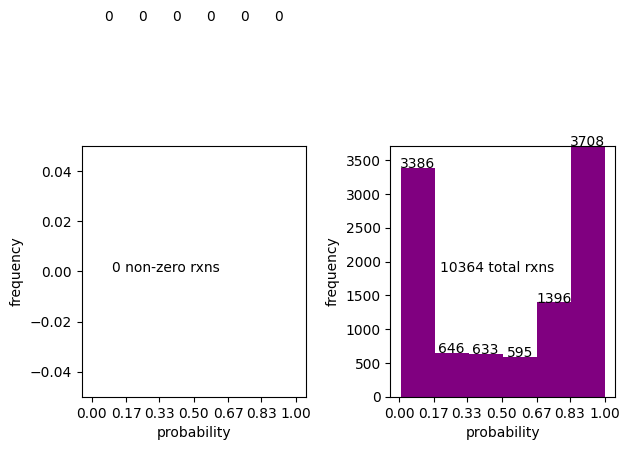

In [ ]:
nonZeroFlux = {ID: flux for ID, flux in fluxes_dic.items() if flux != 0}

from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot
fig, axs = pyplot.subplots(1, 2, tight_layout=True)
from re import sub
model_rxns = {model: [rxn.id for rxn in model.reactions] for model in megaModels}
rxnProbabilities = [round(float(model.reactions.get_by_id(sub("(\_c\d)", "_c0", rxnID)).notes["probability"]), 3)
                    for rxnID in nonZeroFlux for model, modelRxnIDs in model_rxns.items() if rxnID in modelRxnIDs]
counts1, bins1, patches1 = axs[0].hist(rxnProbabilities, bins=len(megaModels), color="green")
counts2, bins2, patches2 = axs[1].hist([round(float(rxn.notes["probability"]), 3) for model in megaModels for rxn in model.reactions],
                                        bins=len(megaModels), color="purple")

# Label each bar
for count1, bin1, patch1 in zip(counts1, bins1, patches1):
    # Center the text horizontally on the patch (bar)
    x = bin1 + patch1.get_width() / 2
    # Position the text slightly above the top of the bar
    y = patch1.get_height() + 0.1
    # Use the count as the label
    axs[0].text(x, y, str(int(count1)), ha='center')

for count2, bin2, patch2 in zip(counts2, bins2, patches2):
    # Center the text horizontally on the patch (bar)
    x = bin2 + patch2.get_width() / 2
    # Position the text slightly above the top of the bar
    y = patch2.get_height() + 0.1
    # Use the count as the label
    axs[1].text(x, y, str(int(count2)), ha='center')

# print(max(counts1), len(rxnProbabilities), max(counts2))
# axs[0].set_xlim([0, 1])  ;  axs[1].set_xlim([0, 1])
from numpy import linspace
x_axis_range = [round(x,2) for x in linspace(0, 1, num=len(megaModels)+1)]
axs[0].set_xticks(x_axis_range)  ;  axs[1].set_xticks(x_axis_range)

axs[0].set_ylim([0, max(counts1)]) ;  axs[1].set_ylim([0, max(counts2)])
axs[0].text(.1, max(counts1)/2, f"{len(rxnProbabilities)} non-zero rxns")
axs[1].text(.2, max(counts2)/2, f"{sum(map(len, model_rxns.values()))} total rxns")
axs[0].set_xlabel("probability") ; axs[1].set_xlabel("probability")
axs[0].set_ylabel("frequency")   ; axs[1].set_ylabel("frequency")
# pyplot.show()
fig.savefig("probabilities_histogram.jpg")

# locs, labels = pyplot.xticks()
# print(locs, labels)
# rounded_labels = [round(loc, 3) for loc in locs]
# pyplot.xticks(locs, rounded_labels)
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))



# from matplotlib import pyplot
# pyplot.bar(nonZeroFlux.keys(), nonZeroFlux.values())
# pyplot.xticks(rotation=90)
# pyplot.show()


In [ ]:
%run ../

constructed_model = build_from_species_models()